# import library

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from datetime import timedelta
from functools import reduce
from tqdm import tqdm
import seaborn as sns
# import lightgbm as lgbm
import optuna.integration.lightgbm as lgbm
import gc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import warnings
import datetime
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler


from sklearn.ensemble import RandomForestRegressor

warnings.simplefilter('ignore')

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

# read data

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

print(len(train.columns.tolist()))
print(len(test.columns.tolist()))

29
28


In [3]:
print(train.shape)
train.head()

(55583, 29)


id  accommodates                                          amenities  \
0   0             6  {TV,"Wireless Internet",Kitchen,"Free parking ...   
1   1             2  {TV,"Cable TV",Internet,"Wireless Internet","A...   
2   2             2  {TV,Internet,"Wireless Internet",Kitchen,"Indo...   
3   3             2  {TV,"Cable TV",Internet,"Wireless Internet","A...   
4   4             2  {TV,Internet,"Wireless Internet","Air conditio...   

   bathrooms  bed_type  bedrooms  beds cancellation_policy city cleaning_fee  \
0        2.0  Real Bed       1.0   4.0            flexible   LA            t   
1        1.0  Real Bed       1.0   1.0              strict   DC            t   
2        2.0  Real Bed       1.0   1.0              strict  NYC            t   
3        1.0  Real Bed       1.0   1.0              strict   SF            t   
4        1.0  Real Bed       1.0   1.0              strict  NYC            t   

                                         description first_review  \
0  My place is meant for family and a few friends...   2016-07-27   
1  This is a new listing for a lovely guest bedro...   2016-09-12   
2  We're looking forward to your stay at our apt....   2016-06-15   
3  BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...   2014-03-15   
4  Charming Apartment on the upper west side of M...   2015-08-05   

  host_has_profile_pic host_identity_verified host_response_rate  host_since  \
0                    t                      f                NaN  2016-07-13   
1                    t                      t               100%  2015-12-30   
2                    t                      f               100%  2016-05-21   
3                    t                      t               100%  2012-06-19   
4                    t                      t               100%  2015-03-25   

  instant_bookable last_review   latitude   longitude  \
0                f  2016-07-27  33.788931 -118.154761   
1                f  2017-03-31  38.934810  -76.978190   
2                t  2017-08-13  40.695118  -73.926240   
3                t  2017-09-03  37.796728 -122.411906   
4                f  2017-09-10  40.785050  -73.974691   

                                                name    neighbourhood  \
0                                      The Penthouse              NaN   
1                         Guest Bedroom in Brookland        Brookland   
2  Clean Modern Room in Lux Apt 1 Block From J Train         Bushwick   
3               BEST views + reviews! 5/5 stars*****         Nob Hill   
4                 Charming 1-bedroom - UWS Manhattan  Upper West Side   

   number_of_reviews property_type  review_scores_rating        room_type  \
0                  1     Apartment                  60.0     Private room   
1                  9         House                 100.0     Private room   
2                 27     Apartment                  83.0     Private room   
3                 38     Apartment                  95.0     Private room   
4                  5     Apartment                 100.0  Entire home/apt   

                                       thumbnail_url zipcode      y  
0                                                NaN   90804  138.0  
1  https://a0.muscache.com/im/pictures/e4d8b51f-6...   20018   42.0  
2  https://a0.muscache.com/im/pictures/5ffecc9b-d...     NaN   65.0  
3                                                NaN   94133  166.0  
4  https://a0.muscache.com/im/pictures/92879730/5...   10024  165.0

In [4]:
train['0train_1test_flag'] = 0
test['0train_1test_flag'] = 1
train_test = pd.concat([train.copy(),test.copy()])
train_test.head()

id  accommodates                                          amenities  \
0   0             6  {TV,"Wireless Internet",Kitchen,"Free parking ...   
1   1             2  {TV,"Cable TV",Internet,"Wireless Internet","A...   
2   2             2  {TV,Internet,"Wireless Internet",Kitchen,"Indo...   
3   3             2  {TV,"Cable TV",Internet,"Wireless Internet","A...   
4   4             2  {TV,Internet,"Wireless Internet","Air conditio...   

   bathrooms  bed_type  bedrooms  beds cancellation_policy city cleaning_fee  \
0        2.0  Real Bed       1.0   4.0            flexible   LA            t   
1        1.0  Real Bed       1.0   1.0              strict   DC            t   
2        2.0  Real Bed       1.0   1.0              strict  NYC            t   
3        1.0  Real Bed       1.0   1.0              strict   SF            t   
4        1.0  Real Bed       1.0   1.0              strict  NYC            t   

                                         description first_review  \
0  My place is meant for family and a few friends...   2016-07-27   
1  This is a new listing for a lovely guest bedro...   2016-09-12   
2  We're looking forward to your stay at our apt....   2016-06-15   
3  BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...   2014-03-15   
4  Charming Apartment on the upper west side of M...   2015-08-05   

  host_has_profile_pic host_identity_verified host_response_rate  host_since  \
0                    t                      f                NaN  2016-07-13   
1                    t                      t               100%  2015-12-30   
2                    t                      f               100%  2016-05-21   
3                    t                      t               100%  2012-06-19   
4                    t                      t               100%  2015-03-25   

  instant_bookable last_review   latitude   longitude  \
0                f  2016-07-27  33.788931 -118.154761   
1                f  2017-03-31  38.934810  -76.978190   
2                t  2017-08-13  40.695118  -73.926240   
3                t  2017-09-03  37.796728 -122.411906   
4                f  2017-09-10  40.785050  -73.974691   

                                                name    neighbourhood  \
0                                      The Penthouse              NaN   
1                         Guest Bedroom in Brookland        Brookland   
2  Clean Modern Room in Lux Apt 1 Block From J Train         Bushwick   
3               BEST views + reviews! 5/5 stars*****         Nob Hill   
4                 Charming 1-bedroom - UWS Manhattan  Upper West Side   

   number_of_reviews property_type  review_scores_rating        room_type  \
0                  1     Apartment                  60.0     Private room   
1                  9         House                 100.0     Private room   
2                 27     Apartment                  83.0     Private room   
3                 38     Apartment                  95.0     Private room   
4                  5     Apartment                 100.0  Entire home/apt   

                                       thumbnail_url zipcode      y  \
0                                                NaN   90804  138.0   
1  https://a0.muscache.com/im/pictures/e4d8b51f-6...   20018   42.0   
2  https://a0.muscache.com/im/pictures/5ffecc9b-d...     NaN   65.0   
3                                                NaN   94133  166.0   
4  https://a0.muscache.com/im/pictures/92879730/5...   10024  165.0   

   0train_1test_flag  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0

In [5]:
train_test.columns.tolist()

['id',
 'accommodates',
 'amenities',
 'bathrooms',
 'bed_type',
 'bedrooms',
 'beds',
 'cancellation_policy',
 'city',
 'cleaning_fee',
 'description',
 'first_review',
 'host_has_profile_pic',
 'host_identity_verified',
 'host_response_rate',
 'host_since',
 'instant_bookable',
 'last_review',
 'latitude',
 'longitude',
 'name',
 'neighbourhood',
 'number_of_reviews',
 'property_type',
 'review_scores_rating',
 'room_type',
 'thumbnail_url',
 'zipcode',
 'y',
 '0train_1test_flag']

In [6]:
# 明らかに要らないカラムを削除

train_test_cols = [
#     'id',
    'accommodates',
    'amenities',
    'bathrooms',
    'bed_type',
    'bedrooms',
    'beds',
    'cancellation_policy',
    'city',
    'cleaning_fee',
    'description',
    'first_review',
    'host_has_profile_pic',
    'host_identity_verified',
    'host_response_rate',
    'host_since',
    'instant_bookable',
    'last_review',
    'latitude',
    'longitude',
#     'name',
    'neighbourhood',
    'number_of_reviews',
    'property_type',
    'review_scores_rating',
    'room_type',
    'thumbnail_url',
    'zipcode',
    'y',
    '0train_1test_flag'
]

train_test = train_test[train_test_cols]

In [7]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74111 entries, 0 to 18527
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accommodates            74111 non-null  int64  
 1   amenities               74111 non-null  object 
 2   bathrooms               73911 non-null  float64
 3   bed_type                74111 non-null  object 
 4   bedrooms                74020 non-null  float64
 5   beds                    73980 non-null  float64
 6   cancellation_policy     74111 non-null  object 
 7   city                    74111 non-null  object 
 8   cleaning_fee            74111 non-null  object 
 9   description             74111 non-null  object 
 10  first_review            58247 non-null  object 
 11  host_has_profile_pic    73923 non-null  object 
 12  host_identity_verified  73923 non-null  object 
 13  host_response_rate      55812 non-null  object 
 14  host_since              73923 non-null

In [8]:
train_test.nunique()

accommodates                 16
amenities                 67122
bathrooms                    17
bed_type                      5
bedrooms                     11
beds                         18
cancellation_policy           5
city                          6
cleaning_fee                  2
description               73479
first_review               2554
host_has_profile_pic          2
host_identity_verified        2
host_response_rate           80
host_since                 3087
instant_bookable              2
last_review                1371
latitude                  74111
longitude                 74111
neighbourhood               619
number_of_reviews           371
property_type                35
review_scores_rating         54
room_type                     3
thumbnail_url             65883
zipcode                     769
y                           714
0train_1test_flag             2
dtype: int64

In [9]:
train_test.isnull().sum()

accommodates                  0
amenities                     0
bathrooms                   200
bed_type                      0
bedrooms                     91
beds                        131
cancellation_policy           0
city                          0
cleaning_fee                  0
description                   0
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
instant_bookable              0
last_review               15827
latitude                      0
longitude                     0
neighbourhood              6872
number_of_reviews             0
property_type                 0
review_scores_rating      16722
room_type                     0
thumbnail_url              8216
zipcode                     966
y                         18528
0train_1test_flag             0
dtype: int64

# train_EDA

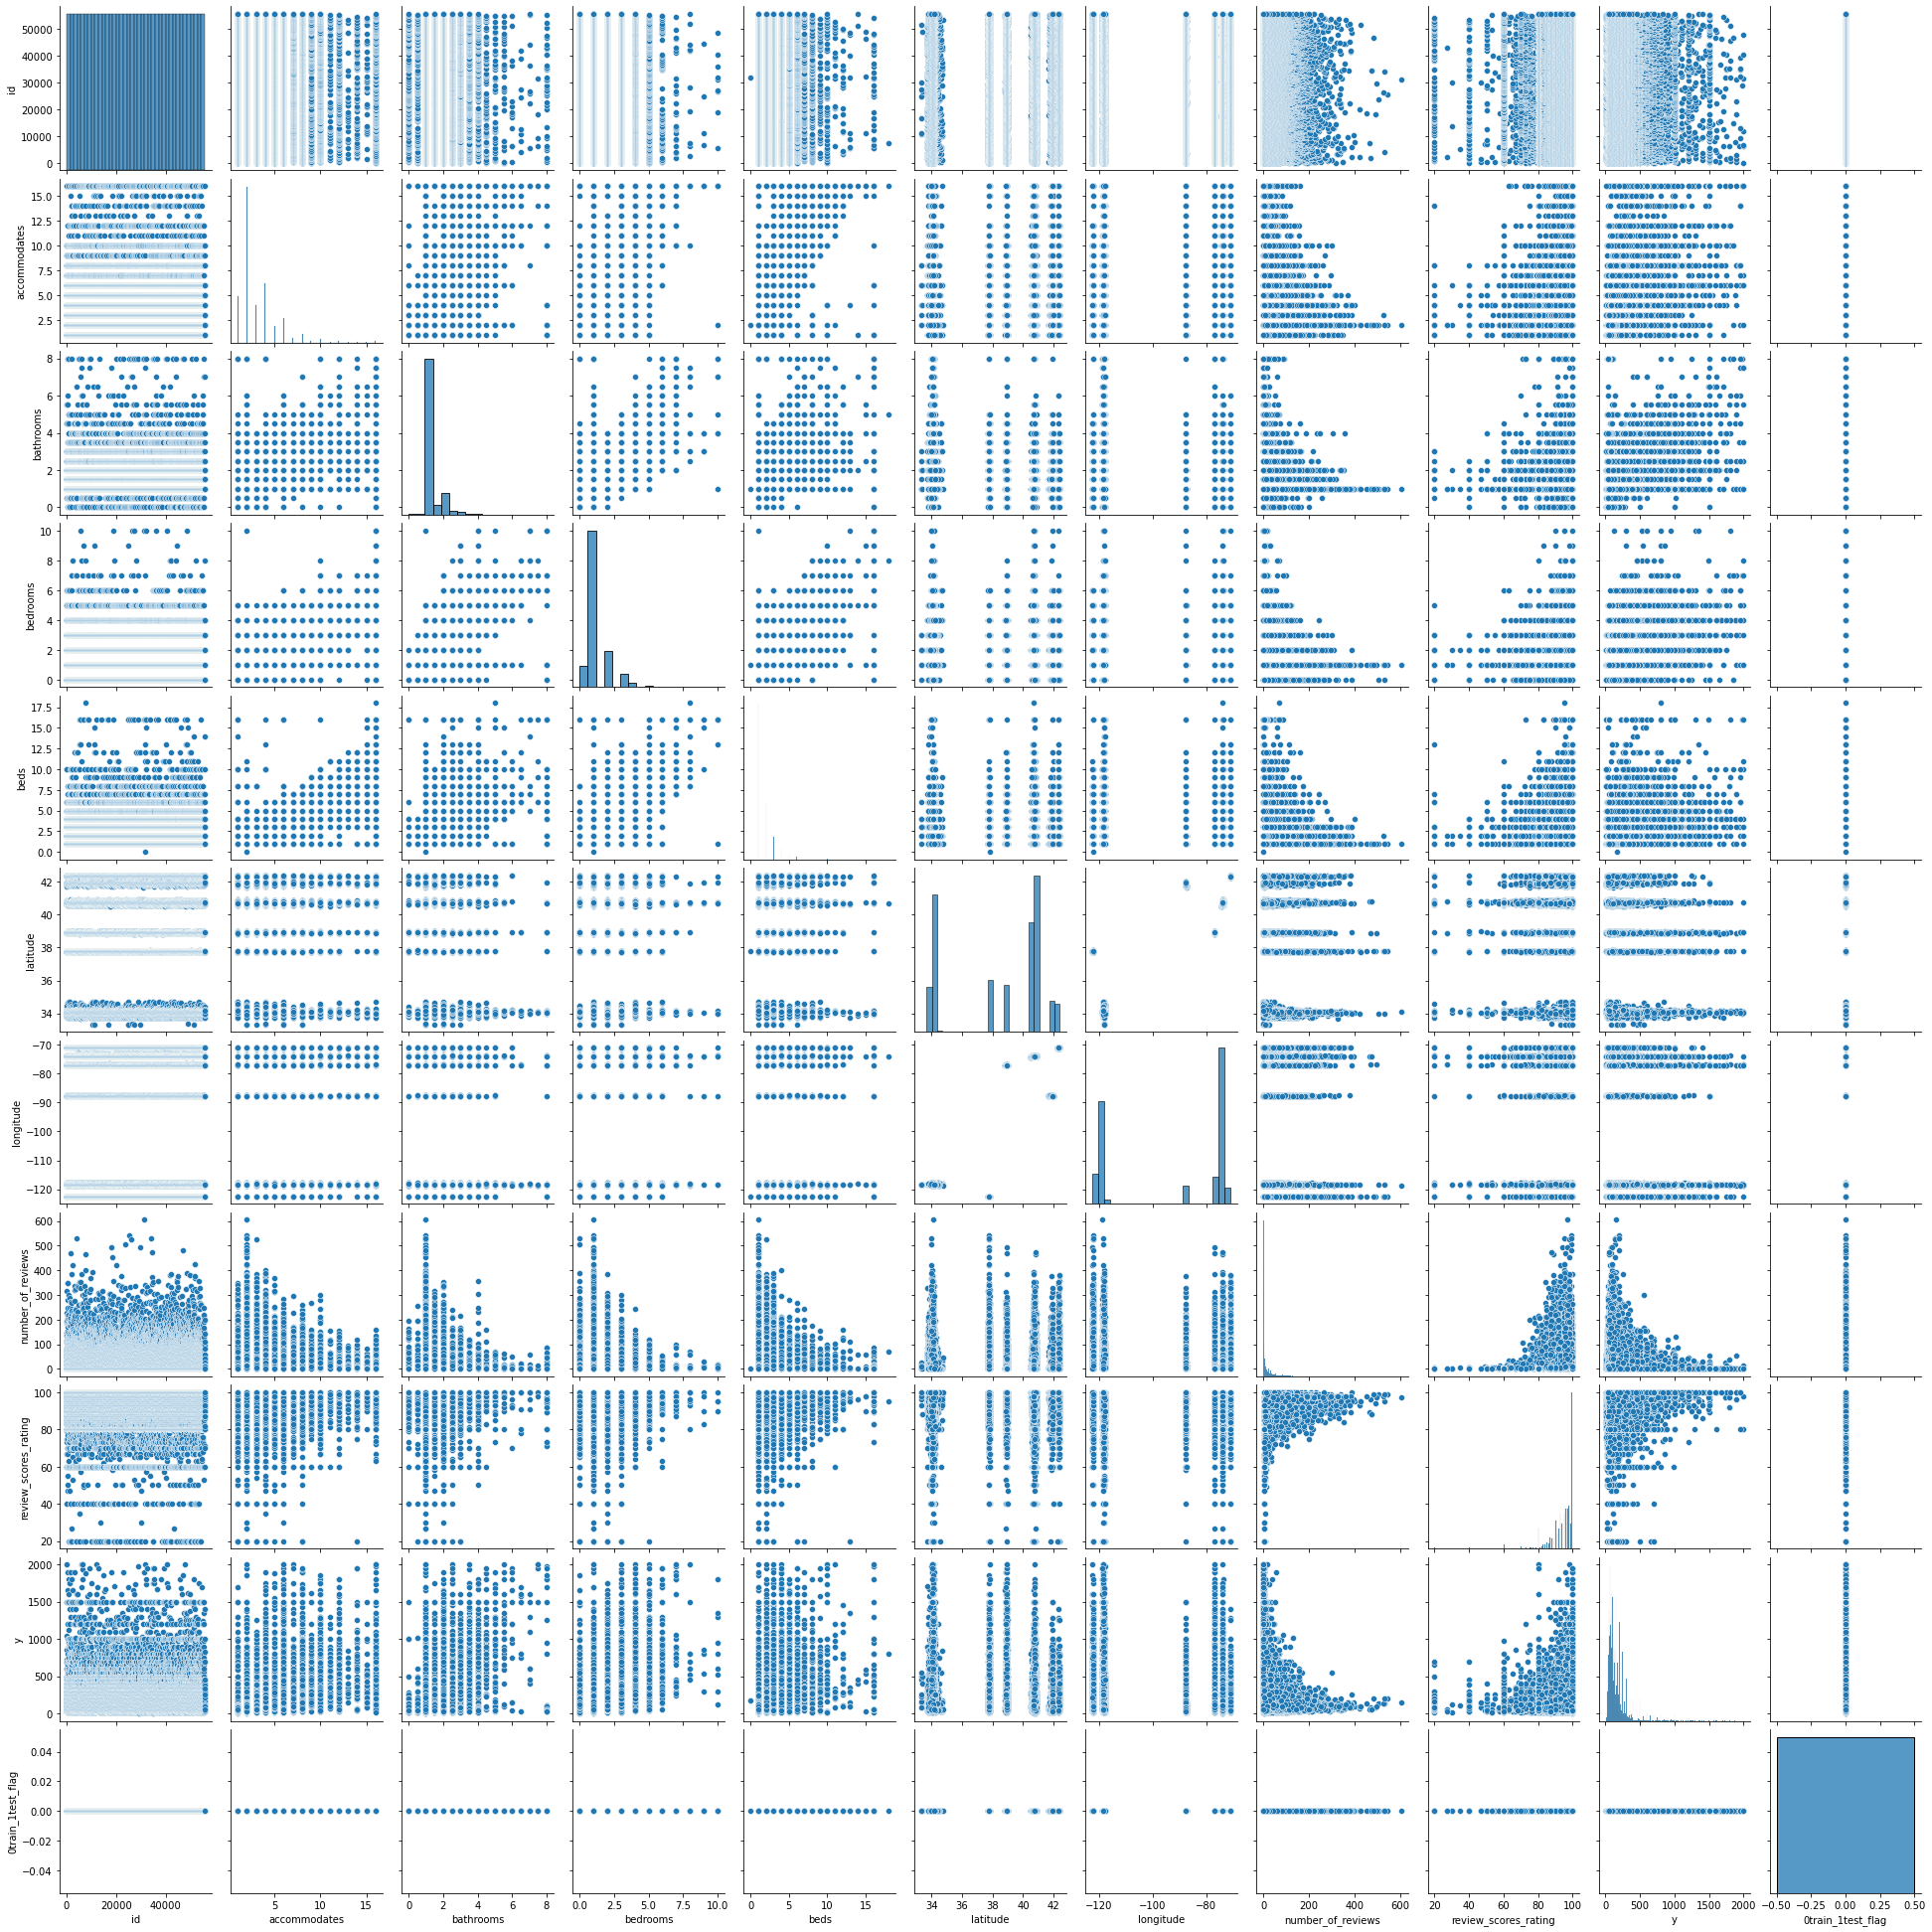

In [10]:
sns.pairplot(train)

In [11]:
train.corr()

id  accommodates  bathrooms  bedrooms      beds  \
id                    1.000000      0.005027   0.005182  0.002463  0.005736   
accommodates          0.005027      1.000000   0.502278  0.708510  0.806654   
bathrooms             0.005182      0.502278   1.000000  0.586366  0.524847   
bedrooms              0.002463      0.708510   0.586366  1.000000  0.708230   
beds                  0.005736      0.806654   0.524847  0.708230  1.000000   
latitude             -0.007358     -0.079395  -0.135427 -0.057502 -0.080307   
longitude            -0.005771     -0.086365  -0.132046 -0.074027 -0.082434   
number_of_reviews     0.004658      0.042320  -0.040262 -0.033761  0.030914   
review_scores_rating  0.002307     -0.017824   0.006698  0.009996 -0.027839   
y                    -0.001129      0.522330   0.456044  0.495830  0.435603   
0train_1test_flag          NaN           NaN        NaN       NaN       NaN   

                      latitude  longitude  number_of_reviews  \
id                   -0.007358  -0.005771           0.004658   
accommodates         -0.079395  -0.086365           0.042320   
bathrooms            -0.135427  -0.132046          -0.040262   
bedrooms             -0.057502  -0.074027          -0.033761   
beds                 -0.080307  -0.082434           0.030914   
latitude              1.000000   0.896581          -0.016439   
longitude             0.896581   1.000000          -0.048660   
number_of_reviews    -0.016439  -0.048660           1.000000   
review_scores_rating -0.035133  -0.050019           0.012144   
y                    -0.028940  -0.056236          -0.068944   
0train_1test_flag          NaN        NaN                NaN   

                      review_scores_rating         y  0train_1test_flag  
id                                0.002307 -0.001129                NaN  
accommodates                     -0.017824  0.522330                NaN  
bathrooms                         0.006698  0.456044                NaN  
bedrooms                          0.009996  0.495830                NaN  
beds                             -0.027839  0.435603                NaN  
latitude                         -0.035133 -0.028940                NaN  
longitude                        -0.050019 -0.056236                NaN  
number_of_reviews                 0.012144 -0.068944                NaN  
review_scores_rating              1.000000  0.065896                NaN  
y                                 0.065896  1.000000                NaN  
0train_1test_flag                      NaN       NaN                NaN

In [12]:
train.describe()

id  accommodates     bathrooms      bedrooms          beds  \
count  55583.000000  55583.000000  55436.000000  55512.000000  55487.000000   
mean   27791.000000      3.152906      1.236426      1.265312      1.711770   
std    16045.574343      2.153001      0.583074      0.849319      1.257822   
min        0.000000      1.000000      0.000000      0.000000      0.000000   
25%    13895.500000      2.000000      1.000000      1.000000      1.000000   
50%    27791.000000      2.000000      1.000000      1.000000      1.000000   
75%    41686.500000      4.000000      1.000000      1.000000      2.000000   
max    55582.000000     16.000000      8.000000     10.000000     18.000000   

           latitude     longitude  number_of_reviews  review_scores_rating  \
count  55583.000000  55583.000000       55583.000000          43027.000000   
mean      38.450812    -92.342406          20.937283             94.077928   
std        3.080869     21.687844          37.951889              7.802154   
min       33.338905   -122.511500           0.000000             20.000000   
25%       34.128205   -118.341876           1.000000             92.000000   
50%       40.663312    -76.995602           6.000000             96.000000   
75%       40.746146    -73.954703          23.000000            100.000000   
max       42.390437    -70.999166         605.000000            100.000000   

                  y  0train_1test_flag  
count  55583.000000            55583.0  
mean     160.163647                0.0  
std      168.087140                0.0  
min        1.000000                0.0  
25%       74.000000                0.0  
50%      111.000000                0.0  
75%      185.000000                0.0  
max     1999.000000                0.0

In [13]:
train['city'].unique()

array(['LA', 'DC', 'NYC', 'SF', 'Chicago', 'Boston'], dtype=object)

In [14]:
americacity_df = pd.DataFrame()
americacity_df['city'] = train['city'].unique()
americacity_df['population'] = [3792621, 601723, 8175133, 805235, 2695598, 617594]
americacity_df['cost_dollar'] = [2899, 3055, 3956, 4210, 2495, 3211]
americacity_df['pop_cost'] = americacity_df['population']/americacity_df['cost_dollar']
americacity_df.head(6)

city  population  cost_dollar     pop_cost
0       LA     3792621         2899  1308.251466
1       DC      601723         3055   196.963339
2      NYC     8175133         3956  2066.514914
3       SF      805235         4210   191.267221
4  Chicago     2695598         2495  1080.400000
5   Boston      617594         3211   192.336967

# preprocessing

## merge_data

In [15]:
print(train_test.shape)

train_test = pd.merge(
    train_test,
    americacity_df,
    on = 'city',
    how = 'left'
)

print(train_test.shape)

(74111, 28)
(74111, 31)


## amenity

In [16]:
train_test['amenities_count'] = train_test['amenities'].apply(lambda x: len(x))

In [17]:
amenities_list = set()
amenities_dict = dict()

for i in range(len(train_test)):
    print(i)
    for amenity in train_test['amenities'].iloc[i].split(','):
        amenity = amenity.replace('{', '')
        amenity = amenity.replace('}', '')  
        amenity = amenity.replace('"', '')
        amenity = amenity.replace(':', '')
        amenity = amenity.replace(' ', '')
        amenity = amenity.replace('　', '')
        
        
        if amenity != '':
            amenities_list.add(str(amenity))
            try:
                amenities_dict[amenity] += 1
            except:
                amenities_dict[amenity] = 0
print(amenities_dict)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095


3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938
3939
3940
3941
3942
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952
3953
3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966
3967
3968
3969
3970
3971
3972
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108


5733
5734
5735
5736
5737
5738
5739
5740
5741
5742
5743
5744
5745
5746
5747
5748
5749
5750
5751
5752
5753
5754
5755
5756
5757
5758
5759
5760
5761
5762
5763
5764
5765
5766
5767
5768
5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932


8039
8040
8041
8042
8043
8044
8045
8046
8047
8048
8049
8050
8051
8052
8053
8054
8055
8056
8057
8058
8059
8060
8061
8062
8063
8064
8065
8066
8067
8068
8069
8070
8071
8072
8073
8074
8075
8076
8077
8078
8079
8080
8081
8082
8083
8084
8085
8086
8087
8088
8089
8090
8091
8092
8093
8094
8095
8096
8097
8098
8099
8100
8101
8102
8103
8104
8105
8106
8107
8108
8109
8110
8111
8112
8113
8114
8115
8116
8117
8118
8119
8120
8121
8122
8123
8124
8125
8126
8127
8128
8129
8130
8131
8132
8133
8134
8135
8136
8137
8138
8139
8140
8141
8142
8143
8144
8145
8146
8147
8148
8149
8150
8151
8152
8153
8154
8155
8156
8157
8158
8159
8160
8161
8162
8163
8164
8165
8166
8167
8168
8169
8170
8171
8172
8173
8174
8175
8176
8177
8178
8179
8180
8181
8182
8183
8184
8185
8186
8187
8188
8189
8190
8191
8192
8193
8194
8195
8196
8197
8198
8199
8200
8201
8202
8203
8204
8205
8206
8207
8208
8209
8210
8211
8212
8213
8214
8215
8216
8217
8218
8219
8220
8221
8222
8223
8224
8225
8226
8227
8228
8229
8230
8231
8232
8233
8234
8235
8236
8237
8238


9921
9922
9923
9924
9925
9926
9927
9928
9929
9930
9931
9932
9933
9934
9935
9936
9937
9938
9939
9940
9941
9942
9943
9944
9945
9946
9947
9948
9949
9950
9951
9952
9953
9954
9955
9956
9957
9958
9959
9960
9961
9962
9963
9964
9965
9966
9967
9968
9969
9970
9971
9972
9973
9974
9975
9976
9977
9978
9979
9980
9981
9982
9983
9984
9985
9986
9987
9988
9989
9990
9991
9992
9993
9994
9995
9996
9997
9998
9999
10000
10001
10002
10003
10004
10005
10006
10007
10008
10009
10010
10011
10012
10013
10014
10015
10016
10017
10018
10019
10020
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10041
10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100

12016
12017
12018
12019
12020
12021
12022
12023
12024
12025
12026
12027
12028
12029
12030
12031
12032
12033
12034
12035
12036
12037
12038
12039
12040
12041
12042
12043
12044
12045
12046
12047
12048
12049
12050
12051
12052
12053
12054
12055
12056
12057
12058
12059
12060
12061
12062
12063
12064
12065
12066
12067
12068
12069
12070
12071
12072
12073
12074
12075
12076
12077
12078
12079
12080
12081
12082
12083
12084
12085
12086
12087
12088
12089
12090
12091
12092
12093
12094
12095
12096
12097
12098
12099
12100
12101
12102
12103
12104
12105
12106
12107
12108
12109
12110
12111
12112
12113
12114
12115
12116
12117
12118
12119
12120
12121
12122
12123
12124
12125
12126
12127
12128
12129
12130
12131
12132
12133
12134
12135
12136
12137
12138
12139
12140
12141
12142
12143
12144
12145
12146
12147
12148
12149
12150
12151
12152
12153
12154
12155
12156
12157
12158
12159
12160
12161
12162
12163
12164
12165
12166
12167
12168
12169
12170
12171
12172
12173
12174
12175
12176
12177
12178
12179
12180
12181
1218

13615
13616
13617
13618
13619
13620
13621
13622
13623
13624
13625
13626
13627
13628
13629
13630
13631
13632
13633
13634
13635
13636
13637
13638
13639
13640
13641
13642
13643
13644
13645
13646
13647
13648
13649
13650
13651
13652
13653
13654
13655
13656
13657
13658
13659
13660
13661
13662
13663
13664
13665
13666
13667
13668
13669
13670
13671
13672
13673
13674
13675
13676
13677
13678
13679
13680
13681
13682
13683
13684
13685
13686
13687
13688
13689
13690
13691
13692
13693
13694
13695
13696
13697
13698
13699
13700
13701
13702
13703
13704
13705
13706
13707
13708
13709
13710
13711
13712
13713
13714
13715
13716
13717
13718
13719
13720
13721
13722
13723
13724
13725
13726
13727
13728
13729
13730
13731
13732
13733
13734
13735
13736
13737
13738
13739
13740
13741
13742
13743
13744
13745
13746
13747
13748
13749
13750
13751
13752
13753
13754
13755
13756
13757
13758
13759
13760
13761
13762
13763
13764
13765
13766
13767
13768
13769
13770
13771
13772
13773
13774
13775
13776
13777
13778
13779
13780
1378

15862
15863
15864
15865
15866
15867
15868
15869
15870
15871
15872
15873
15874
15875
15876
15877
15878
15879
15880
15881
15882
15883
15884
15885
15886
15887
15888
15889
15890
15891
15892
15893
15894
15895
15896
15897
15898
15899
15900
15901
15902
15903
15904
15905
15906
15907
15908
15909
15910
15911
15912
15913
15914
15915
15916
15917
15918
15919
15920
15921
15922
15923
15924
15925
15926
15927
15928
15929
15930
15931
15932
15933
15934
15935
15936
15937
15938
15939
15940
15941
15942
15943
15944
15945
15946
15947
15948
15949
15950
15951
15952
15953
15954
15955
15956
15957
15958
15959
15960
15961
15962
15963
15964
15965
15966
15967
15968
15969
15970
15971
15972
15973
15974
15975
15976
15977
15978
15979
15980
15981
15982
15983
15984
15985
15986
15987
15988
15989
15990
15991
15992
15993
15994
15995
15996
15997
15998
15999
16000
16001
16002
16003
16004
16005
16006
16007
16008
16009
16010
16011
16012
16013
16014
16015
16016
16017
16018
16019
16020
16021
16022
16023
16024
16025
16026
16027
1602

17630
17631
17632
17633
17634
17635
17636
17637
17638
17639
17640
17641
17642
17643
17644
17645
17646
17647
17648
17649
17650
17651
17652
17653
17654
17655
17656
17657
17658
17659
17660
17661
17662
17663
17664
17665
17666
17667
17668
17669
17670
17671
17672
17673
17674
17675
17676
17677
17678
17679
17680
17681
17682
17683
17684
17685
17686
17687
17688
17689
17690
17691
17692
17693
17694
17695
17696
17697
17698
17699
17700
17701
17702
17703
17704
17705
17706
17707
17708
17709
17710
17711
17712
17713
17714
17715
17716
17717
17718
17719
17720
17721
17722
17723
17724
17725
17726
17727
17728
17729
17730
17731
17732
17733
17734
17735
17736
17737
17738
17739
17740
17741
17742
17743
17744
17745
17746
17747
17748
17749
17750
17751
17752
17753
17754
17755
17756
17757
17758
17759
17760
17761
17762
17763
17764
17765
17766
17767
17768
17769
17770
17771
17772
17773
17774
17775
17776
17777
17778
17779
17780
17781
17782
17783
17784
17785
17786
17787
17788
17789
17790
17791
17792
17793
17794
17795
1779

19861
19862
19863
19864
19865
19866
19867
19868
19869
19870
19871
19872
19873
19874
19875
19876
19877
19878
19879
19880
19881
19882
19883
19884
19885
19886
19887
19888
19889
19890
19891
19892
19893
19894
19895
19896
19897
19898
19899
19900
19901
19902
19903
19904
19905
19906
19907
19908
19909
19910
19911
19912
19913
19914
19915
19916
19917
19918
19919
19920
19921
19922
19923
19924
19925
19926
19927
19928
19929
19930
19931
19932
19933
19934
19935
19936
19937
19938
19939
19940
19941
19942
19943
19944
19945
19946
19947
19948
19949
19950
19951
19952
19953
19954
19955
19956
19957
19958
19959
19960
19961
19962
19963
19964
19965
19966
19967
19968
19969
19970
19971
19972
19973
19974
19975
19976
19977
19978
19979
19980
19981
19982
19983
19984
19985
19986
19987
19988
19989
19990
19991
19992
19993
19994
19995
19996
19997
19998
19999
20000
20001
20002
20003
20004
20005
20006
20007
20008
20009
20010
20011
20012
20013
20014
20015
20016
20017
20018
20019
20020
20021
20022
20023
20024
20025
20026
2002

21785
21786
21787
21788
21789
21790
21791
21792
21793
21794
21795
21796
21797
21798
21799
21800
21801
21802
21803
21804
21805
21806
21807
21808
21809
21810
21811
21812
21813
21814
21815
21816
21817
21818
21819
21820
21821
21822
21823
21824
21825
21826
21827
21828
21829
21830
21831
21832
21833
21834
21835
21836
21837
21838
21839
21840
21841
21842
21843
21844
21845
21846
21847
21848
21849
21850
21851
21852
21853
21854
21855
21856
21857
21858
21859
21860
21861
21862
21863
21864
21865
21866
21867
21868
21869
21870
21871
21872
21873
21874
21875
21876
21877
21878
21879
21880
21881
21882
21883
21884
21885
21886
21887
21888
21889
21890
21891
21892
21893
21894
21895
21896
21897
21898
21899
21900
21901
21902
21903
21904
21905
21906
21907
21908
21909
21910
21911
21912
21913
21914
21915
21916
21917
21918
21919
21920
21921
21922
21923
21924
21925
21926
21927
21928
21929
21930
21931
21932
21933
21934
21935
21936
21937
21938
21939
21940
21941
21942
21943
21944
21945
21946
21947
21948
21949
21950
2195

23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931
23932
23933
23934
23935
23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
23947
23948
23949
23950
23951
23952
23953
23954
23955
23956
23957
23958
23959
23960
23961
23962
23963
23964
23965
23966
23967
23968
23969
23970
23971
23972
23973
23974
23975
23976
23977
23978
23979
23980
23981
23982
23983
23984
23985
23986
23987
23988
23989
23990
23991
23992
23993
23994
23995
23996
23997
23998
23999
24000
24001
24002
24003
24004
24005
24006
24007
24008
24009
24010
24011
24012
24013
24014
24015
24016
24017
24018
24019
24020
24021
24022
24023
24024
24025
2402

25444
25445
25446
25447
25448
25449
25450
25451
25452
25453
25454
25455
25456
25457
25458
25459
25460
25461
25462
25463
25464
25465
25466
25467
25468
25469
25470
25471
25472
25473
25474
25475
25476
25477
25478
25479
25480
25481
25482
25483
25484
25485
25486
25487
25488
25489
25490
25491
25492
25493
25494
25495
25496
25497
25498
25499
25500
25501
25502
25503
25504
25505
25506
25507
25508
25509
25510
25511
25512
25513
25514
25515
25516
25517
25518
25519
25520
25521
25522
25523
25524
25525
25526
25527
25528
25529
25530
25531
25532
25533
25534
25535
25536
25537
25538
25539
25540
25541
25542
25543
25544
25545
25546
25547
25548
25549
25550
25551
25552
25553
25554
25555
25556
25557
25558
25559
25560
25561
25562
25563
25564
25565
25566
25567
25568
25569
25570
25571
25572
25573
25574
25575
25576
25577
25578
25579
25580
25581
25582
25583
25584
25585
25586
25587
25588
25589
25590
25591
25592
25593
25594
25595
25596
25597
25598
25599
25600
25601
25602
25603
25604
25605
25606
25607
25608
25609
2561

27720
27721
27722
27723
27724
27725
27726
27727
27728
27729
27730
27731
27732
27733
27734
27735
27736
27737
27738
27739
27740
27741
27742
27743
27744
27745
27746
27747
27748
27749
27750
27751
27752
27753
27754
27755
27756
27757
27758
27759
27760
27761
27762
27763
27764
27765
27766
27767
27768
27769
27770
27771
27772
27773
27774
27775
27776
27777
27778
27779
27780
27781
27782
27783
27784
27785
27786
27787
27788
27789
27790
27791
27792
27793
27794
27795
27796
27797
27798
27799
27800
27801
27802
27803
27804
27805
27806
27807
27808
27809
27810
27811
27812
27813
27814
27815
27816
27817
27818
27819
27820
27821
27822
27823
27824
27825
27826
27827
27828
27829
27830
27831
27832
27833
27834
27835
27836
27837
27838
27839
27840
27841
27842
27843
27844
27845
27846
27847
27848
27849
27850
27851
27852
27853
27854
27855
27856
27857
27858
27859
27860
27861
27862
27863
27864
27865
27866
27867
27868
27869
27870
27871
27872
27873
27874
27875
27876
27877
27878
27879
27880
27881
27882
27883
27884
27885
2788

29091
29092
29093
29094
29095
29096
29097
29098
29099
29100
29101
29102
29103
29104
29105
29106
29107
29108
29109
29110
29111
29112
29113
29114
29115
29116
29117
29118
29119
29120
29121
29122
29123
29124
29125
29126
29127
29128
29129
29130
29131
29132
29133
29134
29135
29136
29137
29138
29139
29140
29141
29142
29143
29144
29145
29146
29147
29148
29149
29150
29151
29152
29153
29154
29155
29156
29157
29158
29159
29160
29161
29162
29163
29164
29165
29166
29167
29168
29169
29170
29171
29172
29173
29174
29175
29176
29177
29178
29179
29180
29181
29182
29183
29184
29185
29186
29187
29188
29189
29190
29191
29192
29193
29194
29195
29196
29197
29198
29199
29200
29201
29202
29203
29204
29205
29206
29207
29208
29209
29210
29211
29212
29213
29214
29215
29216
29217
29218
29219
29220
29221
29222
29223
29224
29225
29226
29227
29228
29229
29230
29231
29232
29233
29234
29235
29236
29237
29238
29239
29240
29241
29242
29243
29244
29245
29246
29247
29248
29249
29250
29251
29252
29253
29254
29255
29256
2925

31128
31129
31130
31131
31132
31133
31134
31135
31136
31137
31138
31139
31140
31141
31142
31143
31144
31145
31146
31147
31148
31149
31150
31151
31152
31153
31154
31155
31156
31157
31158
31159
31160
31161
31162
31163
31164
31165
31166
31167
31168
31169
31170
31171
31172
31173
31174
31175
31176
31177
31178
31179
31180
31181
31182
31183
31184
31185
31186
31187
31188
31189
31190
31191
31192
31193
31194
31195
31196
31197
31198
31199
31200
31201
31202
31203
31204
31205
31206
31207
31208
31209
31210
31211
31212
31213
31214
31215
31216
31217
31218
31219
31220
31221
31222
31223
31224
31225
31226
31227
31228
31229
31230
31231
31232
31233
31234
31235
31236
31237
31238
31239
31240
31241
31242
31243
31244
31245
31246
31247
31248
31249
31250
31251
31252
31253
31254
31255
31256
31257
31258
31259
31260
31261
31262
31263
31264
31265
31266
31267
31268
31269
31270
31271
31272
31273
31274
31275
31276
31277
31278
31279
31280
31281
31282
31283
31284
31285
31286
31287
31288
31289
31290
31291
31292
31293
3129

32582
32583
32584
32585
32586
32587
32588
32589
32590
32591
32592
32593
32594
32595
32596
32597
32598
32599
32600
32601
32602
32603
32604
32605
32606
32607
32608
32609
32610
32611
32612
32613
32614
32615
32616
32617
32618
32619
32620
32621
32622
32623
32624
32625
32626
32627
32628
32629
32630
32631
32632
32633
32634
32635
32636
32637
32638
32639
32640
32641
32642
32643
32644
32645
32646
32647
32648
32649
32650
32651
32652
32653
32654
32655
32656
32657
32658
32659
32660
32661
32662
32663
32664
32665
32666
32667
32668
32669
32670
32671
32672
32673
32674
32675
32676
32677
32678
32679
32680
32681
32682
32683
32684
32685
32686
32687
32688
32689
32690
32691
32692
32693
32694
32695
32696
32697
32698
32699
32700
32701
32702
32703
32704
32705
32706
32707
32708
32709
32710
32711
32712
32713
32714
32715
32716
32717
32718
32719
32720
32721
32722
32723
32724
32725
32726
32727
32728
32729
32730
32731
32732
32733
32734
32735
32736
32737
32738
32739
32740
32741
32742
32743
32744
32745
32746
32747
3274

34687
34688
34689
34690
34691
34692
34693
34694
34695
34696
34697
34698
34699
34700
34701
34702
34703
34704
34705
34706
34707
34708
34709
34710
34711
34712
34713
34714
34715
34716
34717
34718
34719
34720
34721
34722
34723
34724
34725
34726
34727
34728
34729
34730
34731
34732
34733
34734
34735
34736
34737
34738
34739
34740
34741
34742
34743
34744
34745
34746
34747
34748
34749
34750
34751
34752
34753
34754
34755
34756
34757
34758
34759
34760
34761
34762
34763
34764
34765
34766
34767
34768
34769
34770
34771
34772
34773
34774
34775
34776
34777
34778
34779
34780
34781
34782
34783
34784
34785
34786
34787
34788
34789
34790
34791
34792
34793
34794
34795
34796
34797
34798
34799
34800
34801
34802
34803
34804
34805
34806
34807
34808
34809
34810
34811
34812
34813
34814
34815
34816
34817
34818
34819
34820
34821
34822
34823
34824
34825
34826
34827
34828
34829
34830
34831
34832
34833
34834
34835
34836
34837
34838
34839
34840
34841
34842
34843
34844
34845
34846
34847
34848
34849
34850
34851
34852
3485

36058
36059
36060
36061
36062
36063
36064
36065
36066
36067
36068
36069
36070
36071
36072
36073
36074
36075
36076
36077
36078
36079
36080
36081
36082
36083
36084
36085
36086
36087
36088
36089
36090
36091
36092
36093
36094
36095
36096
36097
36098
36099
36100
36101
36102
36103
36104
36105
36106
36107
36108
36109
36110
36111
36112
36113
36114
36115
36116
36117
36118
36119
36120
36121
36122
36123
36124
36125
36126
36127
36128
36129
36130
36131
36132
36133
36134
36135
36136
36137
36138
36139
36140
36141
36142
36143
36144
36145
36146
36147
36148
36149
36150
36151
36152
36153
36154
36155
36156
36157
36158
36159
36160
36161
36162
36163
36164
36165
36166
36167
36168
36169
36170
36171
36172
36173
36174
36175
36176
36177
36178
36179
36180
36181
36182
36183
36184
36185
36186
36187
36188
36189
36190
36191
36192
36193
36194
36195
36196
36197
36198
36199
36200
36201
36202
36203
36204
36205
36206
36207
36208
36209
36210
36211
36212
36213
36214
36215
36216
36217
36218
36219
36220
36221
36222
36223
3622

38229
38230
38231
38232
38233
38234
38235
38236
38237
38238
38239
38240
38241
38242
38243
38244
38245
38246
38247
38248
38249
38250
38251
38252
38253
38254
38255
38256
38257
38258
38259
38260
38261
38262
38263
38264
38265
38266
38267
38268
38269
38270
38271
38272
38273
38274
38275
38276
38277
38278
38279
38280
38281
38282
38283
38284
38285
38286
38287
38288
38289
38290
38291
38292
38293
38294
38295
38296
38297
38298
38299
38300
38301
38302
38303
38304
38305
38306
38307
38308
38309
38310
38311
38312
38313
38314
38315
38316
38317
38318
38319
38320
38321
38322
38323
38324
38325
38326
38327
38328
38329
38330
38331
38332
38333
38334
38335
38336
38337
38338
38339
38340
38341
38342
38343
38344
38345
38346
38347
38348
38349
38350
38351
38352
38353
38354
38355
38356
38357
38358
38359
38360
38361
38362
38363
38364
38365
38366
38367
38368
38369
38370
38371
38372
38373
38374
38375
38376
38377
38378
38379
38380
38381
38382
38383
38384
38385
38386
38387
38388
38389
38390
38391
38392
38393
38394
3839

39903
39904
39905
39906
39907
39908
39909
39910
39911
39912
39913
39914
39915
39916
39917
39918
39919
39920
39921
39922
39923
39924
39925
39926
39927
39928
39929
39930
39931
39932
39933
39934
39935
39936
39937
39938
39939
39940
39941
39942
39943
39944
39945
39946
39947
39948
39949
39950
39951
39952
39953
39954
39955
39956
39957
39958
39959
39960
39961
39962
39963
39964
39965
39966
39967
39968
39969
39970
39971
39972
39973
39974
39975
39976
39977
39978
39979
39980
39981
39982
39983
39984
39985
39986
39987
39988
39989
39990
39991
39992
39993
39994
39995
39996
39997
39998
39999
40000
40001
40002
40003
40004
40005
40006
40007
40008
40009
40010
40011
40012
40013
40014
40015
40016
40017
40018
40019
40020
40021
40022
40023
40024
40025
40026
40027
40028
40029
40030
40031
40032
40033
40034
40035
40036
40037
40038
40039
40040
40041
40042
40043
40044
40045
40046
40047
40048
40049
40050
40051
40052
40053
40054
40055
40056
40057
40058
40059
40060
40061
40062
40063
40064
40065
40066
40067
40068
4006

41921
41922
41923
41924
41925
41926
41927
41928
41929
41930
41931
41932
41933
41934
41935
41936
41937
41938
41939
41940
41941
41942
41943
41944
41945
41946
41947
41948
41949
41950
41951
41952
41953
41954
41955
41956
41957
41958
41959
41960
41961
41962
41963
41964
41965
41966
41967
41968
41969
41970
41971
41972
41973
41974
41975
41976
41977
41978
41979
41980
41981
41982
41983
41984
41985
41986
41987
41988
41989
41990
41991
41992
41993
41994
41995
41996
41997
41998
41999
42000
42001
42002
42003
42004
42005
42006
42007
42008
42009
42010
42011
42012
42013
42014
42015
42016
42017
42018
42019
42020
42021
42022
42023
42024
42025
42026
42027
42028
42029
42030
42031
42032
42033
42034
42035
42036
42037
42038
42039
42040
42041
42042
42043
42044
42045
42046
42047
42048
42049
42050
42051
42052
42053
42054
42055
42056
42057
42058
42059
42060
42061
42062
42063
42064
42065
42066
42067
42068
42069
42070
42071
42072
42073
42074
42075
42076
42077
42078
42079
42080
42081
42082
42083
42084
42085
42086
4208

45230
45231
45232
45233
45234
45235
45236
45237
45238
45239
45240
45241
45242
45243
45244
45245
45246
45247
45248
45249
45250
45251
45252
45253
45254
45255
45256
45257
45258
45259
45260
45261
45262
45263
45264
45265
45266
45267
45268
45269
45270
45271
45272
45273
45274
45275
45276
45277
45278
45279
45280
45281
45282
45283
45284
45285
45286
45287
45288
45289
45290
45291
45292
45293
45294
45295
45296
45297
45298
45299
45300
45301
45302
45303
45304
45305
45306
45307
45308
45309
45310
45311
45312
45313
45314
45315
45316
45317
45318
45319
45320
45321
45322
45323
45324
45325
45326
45327
45328
45329
45330
45331
45332
45333
45334
45335
45336
45337
45338
45339
45340
45341
45342
45343
45344
45345
45346
45347
45348
45349
45350
45351
45352
45353
45354
45355
45356
45357
45358
45359
45360
45361
45362
45363
45364
45365
45366
45367
45368
45369
45370
45371
45372
45373
45374
45375
45376
45377
45378
45379
45380
45381
45382
45383
45384
45385
45386
45387
45388
45389
45390
45391
45392
45393
45394
45395
4539

46992
46993
46994
46995
46996
46997
46998
46999
47000
47001
47002
47003
47004
47005
47006
47007
47008
47009
47010
47011
47012
47013
47014
47015
47016
47017
47018
47019
47020
47021
47022
47023
47024
47025
47026
47027
47028
47029
47030
47031
47032
47033
47034
47035
47036
47037
47038
47039
47040
47041
47042
47043
47044
47045
47046
47047
47048
47049
47050
47051
47052
47053
47054
47055
47056
47057
47058
47059
47060
47061
47062
47063
47064
47065
47066
47067
47068
47069
47070
47071
47072
47073
47074
47075
47076
47077
47078
47079
47080
47081
47082
47083
47084
47085
47086
47087
47088
47089
47090
47091
47092
47093
47094
47095
47096
47097
47098
47099
47100
47101
47102
47103
47104
47105
47106
47107
47108
47109
47110
47111
47112
47113
47114
47115
47116
47117
47118
47119
47120
47121
47122
47123
47124
47125
47126
47127
47128
47129
47130
47131
47132
47133
47134
47135
47136
47137
47138
47139
47140
47141
47142
47143
47144
47145
47146
47147
47148
47149
47150
47151
47152
47153
47154
47155
47156
47157
4715

48459
48460
48461
48462
48463
48464
48465
48466
48467
48468
48469
48470
48471
48472
48473
48474
48475
48476
48477
48478
48479
48480
48481
48482
48483
48484
48485
48486
48487
48488
48489
48490
48491
48492
48493
48494
48495
48496
48497
48498
48499
48500
48501
48502
48503
48504
48505
48506
48507
48508
48509
48510
48511
48512
48513
48514
48515
48516
48517
48518
48519
48520
48521
48522
48523
48524
48525
48526
48527
48528
48529
48530
48531
48532
48533
48534
48535
48536
48537
48538
48539
48540
48541
48542
48543
48544
48545
48546
48547
48548
48549
48550
48551
48552
48553
48554
48555
48556
48557
48558
48559
48560
48561
48562
48563
48564
48565
48566
48567
48568
48569
48570
48571
48572
48573
48574
48575
48576
48577
48578
48579
48580
48581
48582
48583
48584
48585
48586
48587
48588
48589
48590
48591
48592
48593
48594
48595
48596
48597
48598
48599
48600
48601
48602
48603
48604
48605
48606
48607
48608
48609
48610
48611
48612
48613
48614
48615
48616
48617
48618
48619
48620
48621
48622
48623
48624
4862

50492
50493
50494
50495
50496
50497
50498
50499
50500
50501
50502
50503
50504
50505
50506
50507
50508
50509
50510
50511
50512
50513
50514
50515
50516
50517
50518
50519
50520
50521
50522
50523
50524
50525
50526
50527
50528
50529
50530
50531
50532
50533
50534
50535
50536
50537
50538
50539
50540
50541
50542
50543
50544
50545
50546
50547
50548
50549
50550
50551
50552
50553
50554
50555
50556
50557
50558
50559
50560
50561
50562
50563
50564
50565
50566
50567
50568
50569
50570
50571
50572
50573
50574
50575
50576
50577
50578
50579
50580
50581
50582
50583
50584
50585
50586
50587
50588
50589
50590
50591
50592
50593
50594
50595
50596
50597
50598
50599
50600
50601
50602
50603
50604
50605
50606
50607
50608
50609
50610
50611
50612
50613
50614
50615
50616
50617
50618
50619
50620
50621
50622
50623
50624
50625
50626
50627
50628
50629
50630
50631
50632
50633
50634
50635
50636
50637
50638
50639
50640
50641
50642
50643
50644
50645
50646
50647
50648
50649
50650
50651
50652
50653
50654
50655
50656
50657
5065

52102
52103
52104
52105
52106
52107
52108
52109
52110
52111
52112
52113
52114
52115
52116
52117
52118
52119
52120
52121
52122
52123
52124
52125
52126
52127
52128
52129
52130
52131
52132
52133
52134
52135
52136
52137
52138
52139
52140
52141
52142
52143
52144
52145
52146
52147
52148
52149
52150
52151
52152
52153
52154
52155
52156
52157
52158
52159
52160
52161
52162
52163
52164
52165
52166
52167
52168
52169
52170
52171
52172
52173
52174
52175
52176
52177
52178
52179
52180
52181
52182
52183
52184
52185
52186
52187
52188
52189
52190
52191
52192
52193
52194
52195
52196
52197
52198
52199
52200
52201
52202
52203
52204
52205
52206
52207
52208
52209
52210
52211
52212
52213
52214
52215
52216
52217
52218
52219
52220
52221
52222
52223
52224
52225
52226
52227
52228
52229
52230
52231
52232
52233
52234
52235
52236
52237
52238
52239
52240
52241
52242
52243
52244
52245
52246
52247
52248
52249
52250
52251
52252
52253
52254
52255
52256
52257
52258
52259
52260
52261
52262
52263
52264
52265
52266
52267
5226

54327
54328
54329
54330
54331
54332
54333
54334
54335
54336
54337
54338
54339
54340
54341
54342
54343
54344
54345
54346
54347
54348
54349
54350
54351
54352
54353
54354
54355
54356
54357
54358
54359
54360
54361
54362
54363
54364
54365
54366
54367
54368
54369
54370
54371
54372
54373
54374
54375
54376
54377
54378
54379
54380
54381
54382
54383
54384
54385
54386
54387
54388
54389
54390
54391
54392
54393
54394
54395
54396
54397
54398
54399
54400
54401
54402
54403
54404
54405
54406
54407
54408
54409
54410
54411
54412
54413
54414
54415
54416
54417
54418
54419
54420
54421
54422
54423
54424
54425
54426
54427
54428
54429
54430
54431
54432
54433
54434
54435
54436
54437
54438
54439
54440
54441
54442
54443
54444
54445
54446
54447
54448
54449
54450
54451
54452
54453
54454
54455
54456
54457
54458
54459
54460
54461
54462
54463
54464
54465
54466
54467
54468
54469
54470
54471
54472
54473
54474
54475
54476
54477
54478
54479
54480
54481
54482
54483
54484
54485
54486
54487
54488
54489
54490
54491
54492
5449

55809
55810
55811
55812
55813
55814
55815
55816
55817
55818
55819
55820
55821
55822
55823
55824
55825
55826
55827
55828
55829
55830
55831
55832
55833
55834
55835
55836
55837
55838
55839
55840
55841
55842
55843
55844
55845
55846
55847
55848
55849
55850
55851
55852
55853
55854
55855
55856
55857
55858
55859
55860
55861
55862
55863
55864
55865
55866
55867
55868
55869
55870
55871
55872
55873
55874
55875
55876
55877
55878
55879
55880
55881
55882
55883
55884
55885
55886
55887
55888
55889
55890
55891
55892
55893
55894
55895
55896
55897
55898
55899
55900
55901
55902
55903
55904
55905
55906
55907
55908
55909
55910
55911
55912
55913
55914
55915
55916
55917
55918
55919
55920
55921
55922
55923
55924
55925
55926
55927
55928
55929
55930
55931
55932
55933
55934
55935
55936
55937
55938
55939
55940
55941
55942
55943
55944
55945
55946
55947
55948
55949
55950
55951
55952
55953
55954
55955
55956
55957
55958
55959
55960
55961
55962
55963
55964
55965
55966
55967
55968
55969
55970
55971
55972
55973
55974
5597

57899
57900
57901
57902
57903
57904
57905
57906
57907
57908
57909
57910
57911
57912
57913
57914
57915
57916
57917
57918
57919
57920
57921
57922
57923
57924
57925
57926
57927
57928
57929
57930
57931
57932
57933
57934
57935
57936
57937
57938
57939
57940
57941
57942
57943
57944
57945
57946
57947
57948
57949
57950
57951
57952
57953
57954
57955
57956
57957
57958
57959
57960
57961
57962
57963
57964
57965
57966
57967
57968
57969
57970
57971
57972
57973
57974
57975
57976
57977
57978
57979
57980
57981
57982
57983
57984
57985
57986
57987
57988
57989
57990
57991
57992
57993
57994
57995
57996
57997
57998
57999
58000
58001
58002
58003
58004
58005
58006
58007
58008
58009
58010
58011
58012
58013
58014
58015
58016
58017
58018
58019
58020
58021
58022
58023
58024
58025
58026
58027
58028
58029
58030
58031
58032
58033
58034
58035
58036
58037
58038
58039
58040
58041
58042
58043
58044
58045
58046
58047
58048
58049
58050
58051
58052
58053
58054
58055
58056
58057
58058
58059
58060
58061
58062
58063
58064
5806

59337
59338
59339
59340
59341
59342
59343
59344
59345
59346
59347
59348
59349
59350
59351
59352
59353
59354
59355
59356
59357
59358
59359
59360
59361
59362
59363
59364
59365
59366
59367
59368
59369
59370
59371
59372
59373
59374
59375
59376
59377
59378
59379
59380
59381
59382
59383
59384
59385
59386
59387
59388
59389
59390
59391
59392
59393
59394
59395
59396
59397
59398
59399
59400
59401
59402
59403
59404
59405
59406
59407
59408
59409
59410
59411
59412
59413
59414
59415
59416
59417
59418
59419
59420
59421
59422
59423
59424
59425
59426
59427
59428
59429
59430
59431
59432
59433
59434
59435
59436
59437
59438
59439
59440
59441
59442
59443
59444
59445
59446
59447
59448
59449
59450
59451
59452
59453
59454
59455
59456
59457
59458
59459
59460
59461
59462
59463
59464
59465
59466
59467
59468
59469
59470
59471
59472
59473
59474
59475
59476
59477
59478
59479
59480
59481
59482
59483
59484
59485
59486
59487
59488
59489
59490
59491
59492
59493
59494
59495
59496
59497
59498
59499
59500
59501
59502
5950

61482
61483
61484
61485
61486
61487
61488
61489
61490
61491
61492
61493
61494
61495
61496
61497
61498
61499
61500
61501
61502
61503
61504
61505
61506
61507
61508
61509
61510
61511
61512
61513
61514
61515
61516
61517
61518
61519
61520
61521
61522
61523
61524
61525
61526
61527
61528
61529
61530
61531
61532
61533
61534
61535
61536
61537
61538
61539
61540
61541
61542
61543
61544
61545
61546
61547
61548
61549
61550
61551
61552
61553
61554
61555
61556
61557
61558
61559
61560
61561
61562
61563
61564
61565
61566
61567
61568
61569
61570
61571
61572
61573
61574
61575
61576
61577
61578
61579
61580
61581
61582
61583
61584
61585
61586
61587
61588
61589
61590
61591
61592
61593
61594
61595
61596
61597
61598
61599
61600
61601
61602
61603
61604
61605
61606
61607
61608
61609
61610
61611
61612
61613
61614
61615
61616
61617
61618
61619
61620
61621
61622
61623
61624
61625
61626
61627
61628
61629
61630
61631
61632
61633
61634
61635
61636
61637
61638
61639
61640
61641
61642
61643
61644
61645
61646
61647
6164

64734
64735
64736
64737
64738
64739
64740
64741
64742
64743
64744
64745
64746
64747
64748
64749
64750
64751
64752
64753
64754
64755
64756
64757
64758
64759
64760
64761
64762
64763
64764
64765
64766
64767
64768
64769
64770
64771
64772
64773
64774
64775
64776
64777
64778
64779
64780
64781
64782
64783
64784
64785
64786
64787
64788
64789
64790
64791
64792
64793
64794
64795
64796
64797
64798
64799
64800
64801
64802
64803
64804
64805
64806
64807
64808
64809
64810
64811
64812
64813
64814
64815
64816
64817
64818
64819
64820
64821
64822
64823
64824
64825
64826
64827
64828
64829
64830
64831
64832
64833
64834
64835
64836
64837
64838
64839
64840
64841
64842
64843
64844
64845
64846
64847
64848
64849
64850
64851
64852
64853
64854
64855
64856
64857
64858
64859
64860
64861
64862
64863
64864
64865
64866
64867
64868
64869
64870
64871
64872
64873
64874
64875
64876
64877
64878
64879
64880
64881
64882
64883
64884
64885
64886
64887
64888
64889
64890
64891
64892
64893
64894
64895
64896
64897
64898
64899
6490

68110
68111
68112
68113
68114
68115
68116
68117
68118
68119
68120
68121
68122
68123
68124
68125
68126
68127
68128
68129
68130
68131
68132
68133
68134
68135
68136
68137
68138
68139
68140
68141
68142
68143
68144
68145
68146
68147
68148
68149
68150
68151
68152
68153
68154
68155
68156
68157
68158
68159
68160
68161
68162
68163
68164
68165
68166
68167
68168
68169
68170
68171
68172
68173
68174
68175
68176
68177
68178
68179
68180
68181
68182
68183
68184
68185
68186
68187
68188
68189
68190
68191
68192
68193
68194
68195
68196
68197
68198
68199
68200
68201
68202
68203
68204
68205
68206
68207
68208
68209
68210
68211
68212
68213
68214
68215
68216
68217
68218
68219
68220
68221
68222
68223
68224
68225
68226
68227
68228
68229
68230
68231
68232
68233
68234
68235
68236
68237
68238
68239
68240
68241
68242
68243
68244
68245
68246
68247
68248
68249
68250
68251
68252
68253
68254
68255
68256
68257
68258
68259
68260
68261
68262
68263
68264
68265
68266
68267
68268
68269
68270
68271
68272
68273
68274
68275
6827

69612
69613
69614
69615
69616
69617
69618
69619
69620
69621
69622
69623
69624
69625
69626
69627
69628
69629
69630
69631
69632
69633
69634
69635
69636
69637
69638
69639
69640
69641
69642
69643
69644
69645
69646
69647
69648
69649
69650
69651
69652
69653
69654
69655
69656
69657
69658
69659
69660
69661
69662
69663
69664
69665
69666
69667
69668
69669
69670
69671
69672
69673
69674
69675
69676
69677
69678
69679
69680
69681
69682
69683
69684
69685
69686
69687
69688
69689
69690
69691
69692
69693
69694
69695
69696
69697
69698
69699
69700
69701
69702
69703
69704
69705
69706
69707
69708
69709
69710
69711
69712
69713
69714
69715
69716
69717
69718
69719
69720
69721
69722
69723
69724
69725
69726
69727
69728
69729
69730
69731
69732
69733
69734
69735
69736
69737
69738
69739
69740
69741
69742
69743
69744
69745
69746
69747
69748
69749
69750
69751
69752
69753
69754
69755
69756
69757
69758
69759
69760
69761
69762
69763
69764
69765
69766
69767
69768
69769
69770
69771
69772
69773
69774
69775
69776
69777
6977

71744
71745
71746
71747
71748
71749
71750
71751
71752
71753
71754
71755
71756
71757
71758
71759
71760
71761
71762
71763
71764
71765
71766
71767
71768
71769
71770
71771
71772
71773
71774
71775
71776
71777
71778
71779
71780
71781
71782
71783
71784
71785
71786
71787
71788
71789
71790
71791
71792
71793
71794
71795
71796
71797
71798
71799
71800
71801
71802
71803
71804
71805
71806
71807
71808
71809
71810
71811
71812
71813
71814
71815
71816
71817
71818
71819
71820
71821
71822
71823
71824
71825
71826
71827
71828
71829
71830
71831
71832
71833
71834
71835
71836
71837
71838
71839
71840
71841
71842
71843
71844
71845
71846
71847
71848
71849
71850
71851
71852
71853
71854
71855
71856
71857
71858
71859
71860
71861
71862
71863
71864
71865
71866
71867
71868
71869
71870
71871
71872
71873
71874
71875
71876
71877
71878
71879
71880
71881
71882
71883
71884
71885
71886
71887
71888
71889
71890
71891
71892
71893
71894
71895
71896
71897
71898
71899
71900
71901
71902
71903
71904
71905
71906
71907
71908
71909
7191

73255
73256
73257
73258
73259
73260
73261
73262
73263
73264
73265
73266
73267
73268
73269
73270
73271
73272
73273
73274
73275
73276
73277
73278
73279
73280
73281
73282
73283
73284
73285
73286
73287
73288
73289
73290
73291
73292
73293
73294
73295
73296
73297
73298
73299
73300
73301
73302
73303
73304
73305
73306
73307
73308
73309
73310
73311
73312
73313
73314
73315
73316
73317
73318
73319
73320
73321
73322
73323
73324
73325
73326
73327
73328
73329
73330
73331
73332
73333
73334
73335
73336
73337
73338
73339
73340
73341
73342
73343
73344
73345
73346
73347
73348
73349
73350
73351
73352
73353
73354
73355
73356
73357
73358
73359
73360
73361
73362
73363
73364
73365
73366
73367
73368
73369
73370
73371
73372
73373
73374
73375
73376
73377
73378
73379
73380
73381
73382
73383
73384
73385
73386
73387
73388
73389
73390
73391
73392
73393
73394
73395
73396
73397
73398
73399
73400
73401
73402
73403
73404
73405
73406
73407
73408
73409
73410
73411
73412
73413
73414
73415
73416
73417
73418
73419
73420
7342

In [18]:
for amenity in amenities_list:
    train_test[amenity] = 0

In [19]:
for i in range(len(train_test)):
    print(i)
    for amenity in train_test['amenities'].iloc[i].split(','):
        amenity = amenity.replace('{', '')
        amenity = amenity.replace('}', '')  
        amenity = amenity.replace('"', '')
        amenity = amenity.replace(':', '')
        amenity = amenity.replace(' ', '')
        amenity = amenity.replace('　', '')
        
        if amenity != '':
            train_test[amenity].iloc[i] = amenities_dict[amenity]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067


3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710


5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377


6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061


8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720


10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292
10293
10294
10295
10296
10297
10298
10299
10300
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10311
10312
10313
10314
10315
10316
10317
10318
10319
10320
10321
10322
10323
10324
10325
10326
10327
10328
10329
10330
10331
10332
10333
10334
10335
10336
10337
10338
10339
10340
10341
10342
10343
10344
10345
10346
10347
10348
10349
10350
10351
10352
10353
10354
10355
1035

11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
11746
11747
11748
11749
11750
11751
11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
11763
11764
11765
11766
11767
11768
1176

13015
13016
13017
13018
13019
13020
13021
13022
13023
13024
13025
13026
13027
13028
13029
13030
13031
13032
13033
13034
13035
13036
13037
13038
13039
13040
13041
13042
13043
13044
13045
13046
13047
13048
13049
13050
13051
13052
13053
13054
13055
13056
13057
13058
13059
13060
13061
13062
13063
13064
13065
13066
13067
13068
13069
13070
13071
13072
13073
13074
13075
13076
13077
13078
13079
13080
13081
13082
13083
13084
13085
13086
13087
13088
13089
13090
13091
13092
13093
13094
13095
13096
13097
13098
13099
13100
13101
13102
13103
13104
13105
13106
13107
13108
13109
13110
13111
13112
13113
13114
13115
13116
13117
13118
13119
13120
13121
13122
13123
13124
13125
13126
13127
13128
13129
13130
13131
13132
13133
13134
13135
13136
13137
13138
13139
13140
13141
13142
13143
13144
13145
13146
13147
13148
13149
13150
13151
13152
13153
13154
13155
13156
13157
13158
13159
13160
13161
13162
13163
13164
13165
13166
13167
13168
13169
13170
13171
13172
13173
13174
13175
13176
13177
13178
13179
13180
1318

14439
14440
14441
14442
14443
14444
14445
14446
14447
14448
14449
14450
14451
14452
14453
14454
14455
14456
14457
14458
14459
14460
14461
14462
14463
14464
14465
14466
14467
14468
14469
14470
14471
14472
14473
14474
14475
14476
14477
14478
14479
14480
14481
14482
14483
14484
14485
14486
14487
14488
14489
14490
14491
14492
14493
14494
14495
14496
14497
14498
14499
14500
14501
14502
14503
14504
14505
14506
14507
14508
14509
14510
14511
14512
14513
14514
14515
14516
14517
14518
14519
14520
14521
14522
14523
14524
14525
14526
14527
14528
14529
14530
14531
14532
14533
14534
14535
14536
14537
14538
14539
14540
14541
14542
14543
14544
14545
14546
14547
14548
14549
14550
14551
14552
14553
14554
14555
14556
14557
14558
14559
14560
14561
14562
14563
14564
14565
14566
14567
14568
14569
14570
14571
14572
14573
14574
14575
14576
14577
14578
14579
14580
14581
14582
14583
14584
14585
14586
14587
14588
14589
14590
14591
14592
14593
14594
14595
14596
14597
14598
14599
14600
14601
14602
14603
14604
1460

15833
15834
15835
15836
15837
15838
15839
15840
15841
15842
15843
15844
15845
15846
15847
15848
15849
15850
15851
15852
15853
15854
15855
15856
15857
15858
15859
15860
15861
15862
15863
15864
15865
15866
15867
15868
15869
15870
15871
15872
15873
15874
15875
15876
15877
15878
15879
15880
15881
15882
15883
15884
15885
15886
15887
15888
15889
15890
15891
15892
15893
15894
15895
15896
15897
15898
15899
15900
15901
15902
15903
15904
15905
15906
15907
15908
15909
15910
15911
15912
15913
15914
15915
15916
15917
15918
15919
15920
15921
15922
15923
15924
15925
15926
15927
15928
15929
15930
15931
15932
15933
15934
15935
15936
15937
15938
15939
15940
15941
15942
15943
15944
15945
15946
15947
15948
15949
15950
15951
15952
15953
15954
15955
15956
15957
15958
15959
15960
15961
15962
15963
15964
15965
15966
15967
15968
15969
15970
15971
15972
15973
15974
15975
15976
15977
15978
15979
15980
15981
15982
15983
15984
15985
15986
15987
15988
15989
15990
15991
15992
15993
15994
15995
15996
15997
15998
1599

17211
17212
17213
17214
17215
17216
17217
17218
17219
17220
17221
17222
17223
17224
17225
17226
17227
17228
17229
17230
17231
17232
17233
17234
17235
17236
17237
17238
17239
17240
17241
17242
17243
17244
17245
17246
17247
17248
17249
17250
17251
17252
17253
17254
17255
17256
17257
17258
17259
17260
17261
17262
17263
17264
17265
17266
17267
17268
17269
17270
17271
17272
17273
17274
17275
17276
17277
17278
17279
17280
17281
17282
17283
17284
17285
17286
17287
17288
17289
17290
17291
17292
17293
17294
17295
17296
17297
17298
17299
17300
17301
17302
17303
17304
17305
17306
17307
17308
17309
17310
17311
17312
17313
17314
17315
17316
17317
17318
17319
17320
17321
17322
17323
17324
17325
17326
17327
17328
17329
17330
17331
17332
17333
17334
17335
17336
17337
17338
17339
17340
17341
17342
17343
17344
17345
17346
17347
17348
17349
17350
17351
17352
17353
17354
17355
17356
17357
17358
17359
17360
17361
17362
17363
17364
17365
17366
17367
17368
17369
17370
17371
17372
17373
17374
17375
17376
1737

18598
18599
18600
18601
18602
18603
18604
18605
18606
18607
18608
18609
18610
18611
18612
18613
18614
18615
18616
18617
18618
18619
18620
18621
18622
18623
18624
18625
18626
18627
18628
18629
18630
18631
18632
18633
18634
18635
18636
18637
18638
18639
18640
18641
18642
18643
18644
18645
18646
18647
18648
18649
18650
18651
18652
18653
18654
18655
18656
18657
18658
18659
18660
18661
18662
18663
18664
18665
18666
18667
18668
18669
18670
18671
18672
18673
18674
18675
18676
18677
18678
18679
18680
18681
18682
18683
18684
18685
18686
18687
18688
18689
18690
18691
18692
18693
18694
18695
18696
18697
18698
18699
18700
18701
18702
18703
18704
18705
18706
18707
18708
18709
18710
18711
18712
18713
18714
18715
18716
18717
18718
18719
18720
18721
18722
18723
18724
18725
18726
18727
18728
18729
18730
18731
18732
18733
18734
18735
18736
18737
18738
18739
18740
18741
18742
18743
18744
18745
18746
18747
18748
18749
18750
18751
18752
18753
18754
18755
18756
18757
18758
18759
18760
18761
18762
18763
1876

19979
19980
19981
19982
19983
19984
19985
19986
19987
19988
19989
19990
19991
19992
19993
19994
19995
19996
19997
19998
19999
20000
20001
20002
20003
20004
20005
20006
20007
20008
20009
20010
20011
20012
20013
20014
20015
20016
20017
20018
20019
20020
20021
20022
20023
20024
20025
20026
20027
20028
20029
20030
20031
20032
20033
20034
20035
20036
20037
20038
20039
20040
20041
20042
20043
20044
20045
20046
20047
20048
20049
20050
20051
20052
20053
20054
20055
20056
20057
20058
20059
20060
20061
20062
20063
20064
20065
20066
20067
20068
20069
20070
20071
20072
20073
20074
20075
20076
20077
20078
20079
20080
20081
20082
20083
20084
20085
20086
20087
20088
20089
20090
20091
20092
20093
20094
20095
20096
20097
20098
20099
20100
20101
20102
20103
20104
20105
20106
20107
20108
20109
20110
20111
20112
20113
20114
20115
20116
20117
20118
20119
20120
20121
20122
20123
20124
20125
20126
20127
20128
20129
20130
20131
20132
20133
20134
20135
20136
20137
20138
20139
20140
20141
20142
20143
20144
2014

21389
21390
21391
21392
21393
21394
21395
21396
21397
21398
21399
21400
21401
21402
21403
21404
21405
21406
21407
21408
21409
21410
21411
21412
21413
21414
21415
21416
21417
21418
21419
21420
21421
21422
21423
21424
21425
21426
21427
21428
21429
21430
21431
21432
21433
21434
21435
21436
21437
21438
21439
21440
21441
21442
21443
21444
21445
21446
21447
21448
21449
21450
21451
21452
21453
21454
21455
21456
21457
21458
21459
21460
21461
21462
21463
21464
21465
21466
21467
21468
21469
21470
21471
21472
21473
21474
21475
21476
21477
21478
21479
21480
21481
21482
21483
21484
21485
21486
21487
21488
21489
21490
21491
21492
21493
21494
21495
21496
21497
21498
21499
21500
21501
21502
21503
21504
21505
21506
21507
21508
21509
21510
21511
21512
21513
21514
21515
21516
21517
21518
21519
21520
21521
21522
21523
21524
21525
21526
21527
21528
21529
21530
21531
21532
21533
21534
21535
21536
21537
21538
21539
21540
21541
21542
21543
21544
21545
21546
21547
21548
21549
21550
21551
21552
21553
21554
2155

22797
22798
22799
22800
22801
22802
22803
22804
22805
22806
22807
22808
22809
22810
22811
22812
22813
22814
22815
22816
22817
22818
22819
22820
22821
22822
22823
22824
22825
22826
22827
22828
22829
22830
22831
22832
22833
22834
22835
22836
22837
22838
22839
22840
22841
22842
22843
22844
22845
22846
22847
22848
22849
22850
22851
22852
22853
22854
22855
22856
22857
22858
22859
22860
22861
22862
22863
22864
22865
22866
22867
22868
22869
22870
22871
22872
22873
22874
22875
22876
22877
22878
22879
22880
22881
22882
22883
22884
22885
22886
22887
22888
22889
22890
22891
22892
22893
22894
22895
22896
22897
22898
22899
22900
22901
22902
22903
22904
22905
22906
22907
22908
22909
22910
22911
22912
22913
22914
22915
22916
22917
22918
22919
22920
22921
22922
22923
22924
22925
22926
22927
22928
22929
22930
22931
22932
22933
22934
22935
22936
22937
22938
22939
22940
22941
22942
22943
22944
22945
22946
22947
22948
22949
22950
22951
22952
22953
22954
22955
22956
22957
22958
22959
22960
22961
22962
2296

24188
24189
24190
24191
24192
24193
24194
24195
24196
24197
24198
24199
24200
24201
24202
24203
24204
24205
24206
24207
24208
24209
24210
24211
24212
24213
24214
24215
24216
24217
24218
24219
24220
24221
24222
24223
24224
24225
24226
24227
24228
24229
24230
24231
24232
24233
24234
24235
24236
24237
24238
24239
24240
24241
24242
24243
24244
24245
24246
24247
24248
24249
24250
24251
24252
24253
24254
24255
24256
24257
24258
24259
24260
24261
24262
24263
24264
24265
24266
24267
24268
24269
24270
24271
24272
24273
24274
24275
24276
24277
24278
24279
24280
24281
24282
24283
24284
24285
24286
24287
24288
24289
24290
24291
24292
24293
24294
24295
24296
24297
24298
24299
24300
24301
24302
24303
24304
24305
24306
24307
24308
24309
24310
24311
24312
24313
24314
24315
24316
24317
24318
24319
24320
24321
24322
24323
24324
24325
24326
24327
24328
24329
24330
24331
24332
24333
24334
24335
24336
24337
24338
24339
24340
24341
24342
24343
24344
24345
24346
24347
24348
24349
24350
24351
24352
24353
2435

25558
25559
25560
25561
25562
25563
25564
25565
25566
25567
25568
25569
25570
25571
25572
25573
25574
25575
25576
25577
25578
25579
25580
25581
25582
25583
25584
25585
25586
25587
25588
25589
25590
25591
25592
25593
25594
25595
25596
25597
25598
25599
25600
25601
25602
25603
25604
25605
25606
25607
25608
25609
25610
25611
25612
25613
25614
25615
25616
25617
25618
25619
25620
25621
25622
25623
25624
25625
25626
25627
25628
25629
25630
25631
25632
25633
25634
25635
25636
25637
25638
25639
25640
25641
25642
25643
25644
25645
25646
25647
25648
25649
25650
25651
25652
25653
25654
25655
25656
25657
25658
25659
25660
25661
25662
25663
25664
25665
25666
25667
25668
25669
25670
25671
25672
25673
25674
25675
25676
25677
25678
25679
25680
25681
25682
25683
25684
25685
25686
25687
25688
25689
25690
25691
25692
25693
25694
25695
25696
25697
25698
25699
25700
25701
25702
25703
25704
25705
25706
25707
25708
25709
25710
25711
25712
25713
25714
25715
25716
25717
25718
25719
25720
25721
25722
25723
2572

26932
26933
26934
26935
26936
26937
26938
26939
26940
26941
26942
26943
26944
26945
26946
26947
26948
26949
26950
26951
26952
26953
26954
26955
26956
26957
26958
26959
26960
26961
26962
26963
26964
26965
26966
26967
26968
26969
26970
26971
26972
26973
26974
26975
26976
26977
26978
26979
26980
26981
26982
26983
26984
26985
26986
26987
26988
26989
26990
26991
26992
26993
26994
26995
26996
26997
26998
26999
27000
27001
27002
27003
27004
27005
27006
27007
27008
27009
27010
27011
27012
27013
27014
27015
27016
27017
27018
27019
27020
27021
27022
27023
27024
27025
27026
27027
27028
27029
27030
27031
27032
27033
27034
27035
27036
27037
27038
27039
27040
27041
27042
27043
27044
27045
27046
27047
27048
27049
27050
27051
27052
27053
27054
27055
27056
27057
27058
27059
27060
27061
27062
27063
27064
27065
27066
27067
27068
27069
27070
27071
27072
27073
27074
27075
27076
27077
27078
27079
27080
27081
27082
27083
27084
27085
27086
27087
27088
27089
27090
27091
27092
27093
27094
27095
27096
27097
2709

28298
28299
28300
28301
28302
28303
28304
28305
28306
28307
28308
28309
28310
28311
28312
28313
28314
28315
28316
28317
28318
28319
28320
28321
28322
28323
28324
28325
28326
28327
28328
28329
28330
28331
28332
28333
28334
28335
28336
28337
28338
28339
28340
28341
28342
28343
28344
28345
28346
28347
28348
28349
28350
28351
28352
28353
28354
28355
28356
28357
28358
28359
28360
28361
28362
28363
28364
28365
28366
28367
28368
28369
28370
28371
28372
28373
28374
28375
28376
28377
28378
28379
28380
28381
28382
28383
28384
28385
28386
28387
28388
28389
28390
28391
28392
28393
28394
28395
28396
28397
28398
28399
28400
28401
28402
28403
28404
28405
28406
28407
28408
28409
28410
28411
28412
28413
28414
28415
28416
28417
28418
28419
28420
28421
28422
28423
28424
28425
28426
28427
28428
28429
28430
28431
28432
28433
28434
28435
28436
28437
28438
28439
28440
28441
28442
28443
28444
28445
28446
28447
28448
28449
28450
28451
28452
28453
28454
28455
28456
28457
28458
28459
28460
28461
28462
28463
2846

29700
29701
29702
29703
29704
29705
29706
29707
29708
29709
29710
29711
29712
29713
29714
29715
29716
29717
29718
29719
29720
29721
29722
29723
29724
29725
29726
29727
29728
29729
29730
29731
29732
29733
29734
29735
29736
29737
29738
29739
29740
29741
29742
29743
29744
29745
29746
29747
29748
29749
29750
29751
29752
29753
29754
29755
29756
29757
29758
29759
29760
29761
29762
29763
29764
29765
29766
29767
29768
29769
29770
29771
29772
29773
29774
29775
29776
29777
29778
29779
29780
29781
29782
29783
29784
29785
29786
29787
29788
29789
29790
29791
29792
29793
29794
29795
29796
29797
29798
29799
29800
29801
29802
29803
29804
29805
29806
29807
29808
29809
29810
29811
29812
29813
29814
29815
29816
29817
29818
29819
29820
29821
29822
29823
29824
29825
29826
29827
29828
29829
29830
29831
29832
29833
29834
29835
29836
29837
29838
29839
29840
29841
29842
29843
29844
29845
29846
29847
29848
29849
29850
29851
29852
29853
29854
29855
29856
29857
29858
29859
29860
29861
29862
29863
29864
29865
2986

31083
31084
31085
31086
31087
31088
31089
31090
31091
31092
31093
31094
31095
31096
31097
31098
31099
31100
31101
31102
31103
31104
31105
31106
31107
31108
31109
31110
31111
31112
31113
31114
31115
31116
31117
31118
31119
31120
31121
31122
31123
31124
31125
31126
31127
31128
31129
31130
31131
31132
31133
31134
31135
31136
31137
31138
31139
31140
31141
31142
31143
31144
31145
31146
31147
31148
31149
31150
31151
31152
31153
31154
31155
31156
31157
31158
31159
31160
31161
31162
31163
31164
31165
31166
31167
31168
31169
31170
31171
31172
31173
31174
31175
31176
31177
31178
31179
31180
31181
31182
31183
31184
31185
31186
31187
31188
31189
31190
31191
31192
31193
31194
31195
31196
31197
31198
31199
31200
31201
31202
31203
31204
31205
31206
31207
31208
31209
31210
31211
31212
31213
31214
31215
31216
31217
31218
31219
31220
31221
31222
31223
31224
31225
31226
31227
31228
31229
31230
31231
31232
31233
31234
31235
31236
31237
31238
31239
31240
31241
31242
31243
31244
31245
31246
31247
31248
3124

32455
32456
32457
32458
32459
32460
32461
32462
32463
32464
32465
32466
32467
32468
32469
32470
32471
32472
32473
32474
32475
32476
32477
32478
32479
32480
32481
32482
32483
32484
32485
32486
32487
32488
32489
32490
32491
32492
32493
32494
32495
32496
32497
32498
32499
32500
32501
32502
32503
32504
32505
32506
32507
32508
32509
32510
32511
32512
32513
32514
32515
32516
32517
32518
32519
32520
32521
32522
32523
32524
32525
32526
32527
32528
32529
32530
32531
32532
32533
32534
32535
32536
32537
32538
32539
32540
32541
32542
32543
32544
32545
32546
32547
32548
32549
32550
32551
32552
32553
32554
32555
32556
32557
32558
32559
32560
32561
32562
32563
32564
32565
32566
32567
32568
32569
32570
32571
32572
32573
32574
32575
32576
32577
32578
32579
32580
32581
32582
32583
32584
32585
32586
32587
32588
32589
32590
32591
32592
32593
32594
32595
32596
32597
32598
32599
32600
32601
32602
32603
32604
32605
32606
32607
32608
32609
32610
32611
32612
32613
32614
32615
32616
32617
32618
32619
32620
3262

33886
33887
33888
33889
33890
33891
33892
33893
33894
33895
33896
33897
33898
33899
33900
33901
33902
33903
33904
33905
33906
33907
33908
33909
33910
33911
33912
33913
33914
33915
33916
33917
33918
33919
33920
33921
33922
33923
33924
33925
33926
33927
33928
33929
33930
33931
33932
33933
33934
33935
33936
33937
33938
33939
33940
33941
33942
33943
33944
33945
33946
33947
33948
33949
33950
33951
33952
33953
33954
33955
33956
33957
33958
33959
33960
33961
33962
33963
33964
33965
33966
33967
33968
33969
33970
33971
33972
33973
33974
33975
33976
33977
33978
33979
33980
33981
33982
33983
33984
33985
33986
33987
33988
33989
33990
33991
33992
33993
33994
33995
33996
33997
33998
33999
34000
34001
34002
34003
34004
34005
34006
34007
34008
34009
34010
34011
34012
34013
34014
34015
34016
34017
34018
34019
34020
34021
34022
34023
34024
34025
34026
34027
34028
34029
34030
34031
34032
34033
34034
34035
34036
34037
34038
34039
34040
34041
34042
34043
34044
34045
34046
34047
34048
34049
34050
34051
3405

35262
35263
35264
35265
35266
35267
35268
35269
35270
35271
35272
35273
35274
35275
35276
35277
35278
35279
35280
35281
35282
35283
35284
35285
35286
35287
35288
35289
35290
35291
35292
35293
35294
35295
35296
35297
35298
35299
35300
35301
35302
35303
35304
35305
35306
35307
35308
35309
35310
35311
35312
35313
35314
35315
35316
35317
35318
35319
35320
35321
35322
35323
35324
35325
35326
35327
35328
35329
35330
35331
35332
35333
35334
35335
35336
35337
35338
35339
35340
35341
35342
35343
35344
35345
35346
35347
35348
35349
35350
35351
35352
35353
35354
35355
35356
35357
35358
35359
35360
35361
35362
35363
35364
35365
35366
35367
35368
35369
35370
35371
35372
35373
35374
35375
35376
35377
35378
35379
35380
35381
35382
35383
35384
35385
35386
35387
35388
35389
35390
35391
35392
35393
35394
35395
35396
35397
35398
35399
35400
35401
35402
35403
35404
35405
35406
35407
35408
35409
35410
35411
35412
35413
35414
35415
35416
35417
35418
35419
35420
35421
35422
35423
35424
35425
35426
35427
3542

36675
36676
36677
36678
36679
36680
36681
36682
36683
36684
36685
36686
36687
36688
36689
36690
36691
36692
36693
36694
36695
36696
36697
36698
36699
36700
36701
36702
36703
36704
36705
36706
36707
36708
36709
36710
36711
36712
36713
36714
36715
36716
36717
36718
36719
36720
36721
36722
36723
36724
36725
36726
36727
36728
36729
36730
36731
36732
36733
36734
36735
36736
36737
36738
36739
36740
36741
36742
36743
36744
36745
36746
36747
36748
36749
36750
36751
36752
36753
36754
36755
36756
36757
36758
36759
36760
36761
36762
36763
36764
36765
36766
36767
36768
36769
36770
36771
36772
36773
36774
36775
36776
36777
36778
36779
36780
36781
36782
36783
36784
36785
36786
36787
36788
36789
36790
36791
36792
36793
36794
36795
36796
36797
36798
36799
36800
36801
36802
36803
36804
36805
36806
36807
36808
36809
36810
36811
36812
36813
36814
36815
36816
36817
36818
36819
36820
36821
36822
36823
36824
36825
36826
36827
36828
36829
36830
36831
36832
36833
36834
36835
36836
36837
36838
36839
36840
3684

38052
38053
38054
38055
38056
38057
38058
38059
38060
38061
38062
38063
38064
38065
38066
38067
38068
38069
38070
38071
38072
38073
38074
38075
38076
38077
38078
38079
38080
38081
38082
38083
38084
38085
38086
38087
38088
38089
38090
38091
38092
38093
38094
38095
38096
38097
38098
38099
38100
38101
38102
38103
38104
38105
38106
38107
38108
38109
38110
38111
38112
38113
38114
38115
38116
38117
38118
38119
38120
38121
38122
38123
38124
38125
38126
38127
38128
38129
38130
38131
38132
38133
38134
38135
38136
38137
38138
38139
38140
38141
38142
38143
38144
38145
38146
38147
38148
38149
38150
38151
38152
38153
38154
38155
38156
38157
38158
38159
38160
38161
38162
38163
38164
38165
38166
38167
38168
38169
38170
38171
38172
38173
38174
38175
38176
38177
38178
38179
38180
38181
38182
38183
38184
38185
38186
38187
38188
38189
38190
38191
38192
38193
38194
38195
38196
38197
38198
38199
38200
38201
38202
38203
38204
38205
38206
38207
38208
38209
38210
38211
38212
38213
38214
38215
38216
38217
3821

39464
39465
39466
39467
39468
39469
39470
39471
39472
39473
39474
39475
39476
39477
39478
39479
39480
39481
39482
39483
39484
39485
39486
39487
39488
39489
39490
39491
39492
39493
39494
39495
39496
39497
39498
39499
39500
39501
39502
39503
39504
39505
39506
39507
39508
39509
39510
39511
39512
39513
39514
39515
39516
39517
39518
39519
39520
39521
39522
39523
39524
39525
39526
39527
39528
39529
39530
39531
39532
39533
39534
39535
39536
39537
39538
39539
39540
39541
39542
39543
39544
39545
39546
39547
39548
39549
39550
39551
39552
39553
39554
39555
39556
39557
39558
39559
39560
39561
39562
39563
39564
39565
39566
39567
39568
39569
39570
39571
39572
39573
39574
39575
39576
39577
39578
39579
39580
39581
39582
39583
39584
39585
39586
39587
39588
39589
39590
39591
39592
39593
39594
39595
39596
39597
39598
39599
39600
39601
39602
39603
39604
39605
39606
39607
39608
39609
39610
39611
39612
39613
39614
39615
39616
39617
39618
39619
39620
39621
39622
39623
39624
39625
39626
39627
39628
39629
3963

40852
40853
40854
40855
40856
40857
40858
40859
40860
40861
40862
40863
40864
40865
40866
40867
40868
40869
40870
40871
40872
40873
40874
40875
40876
40877
40878
40879
40880
40881
40882
40883
40884
40885
40886
40887
40888
40889
40890
40891
40892
40893
40894
40895
40896
40897
40898
40899
40900
40901
40902
40903
40904
40905
40906
40907
40908
40909
40910
40911
40912
40913
40914
40915
40916
40917
40918
40919
40920
40921
40922
40923
40924
40925
40926
40927
40928
40929
40930
40931
40932
40933
40934
40935
40936
40937
40938
40939
40940
40941
40942
40943
40944
40945
40946
40947
40948
40949
40950
40951
40952
40953
40954
40955
40956
40957
40958
40959
40960
40961
40962
40963
40964
40965
40966
40967
40968
40969
40970
40971
40972
40973
40974
40975
40976
40977
40978
40979
40980
40981
40982
40983
40984
40985
40986
40987
40988
40989
40990
40991
40992
40993
40994
40995
40996
40997
40998
40999
41000
41001
41002
41003
41004
41005
41006
41007
41008
41009
41010
41011
41012
41013
41014
41015
41016
41017
4101

42244
42245
42246
42247
42248
42249
42250
42251
42252
42253
42254
42255
42256
42257
42258
42259
42260
42261
42262
42263
42264
42265
42266
42267
42268
42269
42270
42271
42272
42273
42274
42275
42276
42277
42278
42279
42280
42281
42282
42283
42284
42285
42286
42287
42288
42289
42290
42291
42292
42293
42294
42295
42296
42297
42298
42299
42300
42301
42302
42303
42304
42305
42306
42307
42308
42309
42310
42311
42312
42313
42314
42315
42316
42317
42318
42319
42320
42321
42322
42323
42324
42325
42326
42327
42328
42329
42330
42331
42332
42333
42334
42335
42336
42337
42338
42339
42340
42341
42342
42343
42344
42345
42346
42347
42348
42349
42350
42351
42352
42353
42354
42355
42356
42357
42358
42359
42360
42361
42362
42363
42364
42365
42366
42367
42368
42369
42370
42371
42372
42373
42374
42375
42376
42377
42378
42379
42380
42381
42382
42383
42384
42385
42386
42387
42388
42389
42390
42391
42392
42393
42394
42395
42396
42397
42398
42399
42400
42401
42402
42403
42404
42405
42406
42407
42408
42409
4241

43665
43666
43667
43668
43669
43670
43671
43672
43673
43674
43675
43676
43677
43678
43679
43680
43681
43682
43683
43684
43685
43686
43687
43688
43689
43690
43691
43692
43693
43694
43695
43696
43697
43698
43699
43700
43701
43702
43703
43704
43705
43706
43707
43708
43709
43710
43711
43712
43713
43714
43715
43716
43717
43718
43719
43720
43721
43722
43723
43724
43725
43726
43727
43728
43729
43730
43731
43732
43733
43734
43735
43736
43737
43738
43739
43740
43741
43742
43743
43744
43745
43746
43747
43748
43749
43750
43751
43752
43753
43754
43755
43756
43757
43758
43759
43760
43761
43762
43763
43764
43765
43766
43767
43768
43769
43770
43771
43772
43773
43774
43775
43776
43777
43778
43779
43780
43781
43782
43783
43784
43785
43786
43787
43788
43789
43790
43791
43792
43793
43794
43795
43796
43797
43798
43799
43800
43801
43802
43803
43804
43805
43806
43807
43808
43809
43810
43811
43812
43813
43814
43815
43816
43817
43818
43819
43820
43821
43822
43823
43824
43825
43826
43827
43828
43829
43830
4383

45032
45033
45034
45035
45036
45037
45038
45039
45040
45041
45042
45043
45044
45045
45046
45047
45048
45049
45050
45051
45052
45053
45054
45055
45056
45057
45058
45059
45060
45061
45062
45063
45064
45065
45066
45067
45068
45069
45070
45071
45072
45073
45074
45075
45076
45077
45078
45079
45080
45081
45082
45083
45084
45085
45086
45087
45088
45089
45090
45091
45092
45093
45094
45095
45096
45097
45098
45099
45100
45101
45102
45103
45104
45105
45106
45107
45108
45109
45110
45111
45112
45113
45114
45115
45116
45117
45118
45119
45120
45121
45122
45123
45124
45125
45126
45127
45128
45129
45130
45131
45132
45133
45134
45135
45136
45137
45138
45139
45140
45141
45142
45143
45144
45145
45146
45147
45148
45149
45150
45151
45152
45153
45154
45155
45156
45157
45158
45159
45160
45161
45162
45163
45164
45165
45166
45167
45168
45169
45170
45171
45172
45173
45174
45175
45176
45177
45178
45179
45180
45181
45182
45183
45184
45185
45186
45187
45188
45189
45190
45191
45192
45193
45194
45195
45196
45197
4519

46404
46405
46406
46407
46408
46409
46410
46411
46412
46413
46414
46415
46416
46417
46418
46419
46420
46421
46422
46423
46424
46425
46426
46427
46428
46429
46430
46431
46432
46433
46434
46435
46436
46437
46438
46439
46440
46441
46442
46443
46444
46445
46446
46447
46448
46449
46450
46451
46452
46453
46454
46455
46456
46457
46458
46459
46460
46461
46462
46463
46464
46465
46466
46467
46468
46469
46470
46471
46472
46473
46474
46475
46476
46477
46478
46479
46480
46481
46482
46483
46484
46485
46486
46487
46488
46489
46490
46491
46492
46493
46494
46495
46496
46497
46498
46499
46500
46501
46502
46503
46504
46505
46506
46507
46508
46509
46510
46511
46512
46513
46514
46515
46516
46517
46518
46519
46520
46521
46522
46523
46524
46525
46526
46527
46528
46529
46530
46531
46532
46533
46534
46535
46536
46537
46538
46539
46540
46541
46542
46543
46544
46545
46546
46547
46548
46549
46550
46551
46552
46553
46554
46555
46556
46557
46558
46559
46560
46561
46562
46563
46564
46565
46566
46567
46568
46569
4657

47832
47833
47834
47835
47836
47837
47838
47839
47840
47841
47842
47843
47844
47845
47846
47847
47848
47849
47850
47851
47852
47853
47854
47855
47856
47857
47858
47859
47860
47861
47862
47863
47864
47865
47866
47867
47868
47869
47870
47871
47872
47873
47874
47875
47876
47877
47878
47879
47880
47881
47882
47883
47884
47885
47886
47887
47888
47889
47890
47891
47892
47893
47894
47895
47896
47897
47898
47899
47900
47901
47902
47903
47904
47905
47906
47907
47908
47909
47910
47911
47912
47913
47914
47915
47916
47917
47918
47919
47920
47921
47922
47923
47924
47925
47926
47927
47928
47929
47930
47931
47932
47933
47934
47935
47936
47937
47938
47939
47940
47941
47942
47943
47944
47945
47946
47947
47948
47949
47950
47951
47952
47953
47954
47955
47956
47957
47958
47959
47960
47961
47962
47963
47964
47965
47966
47967
47968
47969
47970
47971
47972
47973
47974
47975
47976
47977
47978
47979
47980
47981
47982
47983
47984
47985
47986
47987
47988
47989
47990
47991
47992
47993
47994
47995
47996
47997
4799

49213
49214
49215
49216
49217
49218
49219
49220
49221
49222
49223
49224
49225
49226
49227
49228
49229
49230
49231
49232
49233
49234
49235
49236
49237
49238
49239
49240
49241
49242
49243
49244
49245
49246
49247
49248
49249
49250
49251
49252
49253
49254
49255
49256
49257
49258
49259
49260
49261
49262
49263
49264
49265
49266
49267
49268
49269
49270
49271
49272
49273
49274
49275
49276
49277
49278
49279
49280
49281
49282
49283
49284
49285
49286
49287
49288
49289
49290
49291
49292
49293
49294
49295
49296
49297
49298
49299
49300
49301
49302
49303
49304
49305
49306
49307
49308
49309
49310
49311
49312
49313
49314
49315
49316
49317
49318
49319
49320
49321
49322
49323
49324
49325
49326
49327
49328
49329
49330
49331
49332
49333
49334
49335
49336
49337
49338
49339
49340
49341
49342
49343
49344
49345
49346
49347
49348
49349
49350
49351
49352
49353
49354
49355
49356
49357
49358
49359
49360
49361
49362
49363
49364
49365
49366
49367
49368
49369
49370
49371
49372
49373
49374
49375
49376
49377
49378
4937

50579
50580
50581
50582
50583
50584
50585
50586
50587
50588
50589
50590
50591
50592
50593
50594
50595
50596
50597
50598
50599
50600
50601
50602
50603
50604
50605
50606
50607
50608
50609
50610
50611
50612
50613
50614
50615
50616
50617
50618
50619
50620
50621
50622
50623
50624
50625
50626
50627
50628
50629
50630
50631
50632
50633
50634
50635
50636
50637
50638
50639
50640
50641
50642
50643
50644
50645
50646
50647
50648
50649
50650
50651
50652
50653
50654
50655
50656
50657
50658
50659
50660
50661
50662
50663
50664
50665
50666
50667
50668
50669
50670
50671
50672
50673
50674
50675
50676
50677
50678
50679
50680
50681
50682
50683
50684
50685
50686
50687
50688
50689
50690
50691
50692
50693
50694
50695
50696
50697
50698
50699
50700
50701
50702
50703
50704
50705
50706
50707
50708
50709
50710
50711
50712
50713
50714
50715
50716
50717
50718
50719
50720
50721
50722
50723
50724
50725
50726
50727
50728
50729
50730
50731
50732
50733
50734
50735
50736
50737
50738
50739
50740
50741
50742
50743
50744
5074

51955
51956
51957
51958
51959
51960
51961
51962
51963
51964
51965
51966
51967
51968
51969
51970
51971
51972
51973
51974
51975
51976
51977
51978
51979
51980
51981
51982
51983
51984
51985
51986
51987
51988
51989
51990
51991
51992
51993
51994
51995
51996
51997
51998
51999
52000
52001
52002
52003
52004
52005
52006
52007
52008
52009
52010
52011
52012
52013
52014
52015
52016
52017
52018
52019
52020
52021
52022
52023
52024
52025
52026
52027
52028
52029
52030
52031
52032
52033
52034
52035
52036
52037
52038
52039
52040
52041
52042
52043
52044
52045
52046
52047
52048
52049
52050
52051
52052
52053
52054
52055
52056
52057
52058
52059
52060
52061
52062
52063
52064
52065
52066
52067
52068
52069
52070
52071
52072
52073
52074
52075
52076
52077
52078
52079
52080
52081
52082
52083
52084
52085
52086
52087
52088
52089
52090
52091
52092
52093
52094
52095
52096
52097
52098
52099
52100
52101
52102
52103
52104
52105
52106
52107
52108
52109
52110
52111
52112
52113
52114
52115
52116
52117
52118
52119
52120
5212

53375
53376
53377
53378
53379
53380
53381
53382
53383
53384
53385
53386
53387
53388
53389
53390
53391
53392
53393
53394
53395
53396
53397
53398
53399
53400
53401
53402
53403
53404
53405
53406
53407
53408
53409
53410
53411
53412
53413
53414
53415
53416
53417
53418
53419
53420
53421
53422
53423
53424
53425
53426
53427
53428
53429
53430
53431
53432
53433
53434
53435
53436
53437
53438
53439
53440
53441
53442
53443
53444
53445
53446
53447
53448
53449
53450
53451
53452
53453
53454
53455
53456
53457
53458
53459
53460
53461
53462
53463
53464
53465
53466
53467
53468
53469
53470
53471
53472
53473
53474
53475
53476
53477
53478
53479
53480
53481
53482
53483
53484
53485
53486
53487
53488
53489
53490
53491
53492
53493
53494
53495
53496
53497
53498
53499
53500
53501
53502
53503
53504
53505
53506
53507
53508
53509
53510
53511
53512
53513
53514
53515
53516
53517
53518
53519
53520
53521
53522
53523
53524
53525
53526
53527
53528
53529
53530
53531
53532
53533
53534
53535
53536
53537
53538
53539
53540
5354

54770
54771
54772
54773
54774
54775
54776
54777
54778
54779
54780
54781
54782
54783
54784
54785
54786
54787
54788
54789
54790
54791
54792
54793
54794
54795
54796
54797
54798
54799
54800
54801
54802
54803
54804
54805
54806
54807
54808
54809
54810
54811
54812
54813
54814
54815
54816
54817
54818
54819
54820
54821
54822
54823
54824
54825
54826
54827
54828
54829
54830
54831
54832
54833
54834
54835
54836
54837
54838
54839
54840
54841
54842
54843
54844
54845
54846
54847
54848
54849
54850
54851
54852
54853
54854
54855
54856
54857
54858
54859
54860
54861
54862
54863
54864
54865
54866
54867
54868
54869
54870
54871
54872
54873
54874
54875
54876
54877
54878
54879
54880
54881
54882
54883
54884
54885
54886
54887
54888
54889
54890
54891
54892
54893
54894
54895
54896
54897
54898
54899
54900
54901
54902
54903
54904
54905
54906
54907
54908
54909
54910
54911
54912
54913
54914
54915
54916
54917
54918
54919
54920
54921
54922
54923
54924
54925
54926
54927
54928
54929
54930
54931
54932
54933
54934
54935
5493

56171
56172
56173
56174
56175
56176
56177
56178
56179
56180
56181
56182
56183
56184
56185
56186
56187
56188
56189
56190
56191
56192
56193
56194
56195
56196
56197
56198
56199
56200
56201
56202
56203
56204
56205
56206
56207
56208
56209
56210
56211
56212
56213
56214
56215
56216
56217
56218
56219
56220
56221
56222
56223
56224
56225
56226
56227
56228
56229
56230
56231
56232
56233
56234
56235
56236
56237
56238
56239
56240
56241
56242
56243
56244
56245
56246
56247
56248
56249
56250
56251
56252
56253
56254
56255
56256
56257
56258
56259
56260
56261
56262
56263
56264
56265
56266
56267
56268
56269
56270
56271
56272
56273
56274
56275
56276
56277
56278
56279
56280
56281
56282
56283
56284
56285
56286
56287
56288
56289
56290
56291
56292
56293
56294
56295
56296
56297
56298
56299
56300
56301
56302
56303
56304
56305
56306
56307
56308
56309
56310
56311
56312
56313
56314
56315
56316
56317
56318
56319
56320
56321
56322
56323
56324
56325
56326
56327
56328
56329
56330
56331
56332
56333
56334
56335
56336
5633

57593
57594
57595
57596
57597
57598
57599
57600
57601
57602
57603
57604
57605
57606
57607
57608
57609
57610
57611
57612
57613
57614
57615
57616
57617
57618
57619
57620
57621
57622
57623
57624
57625
57626
57627
57628
57629
57630
57631
57632
57633
57634
57635
57636
57637
57638
57639
57640
57641
57642
57643
57644
57645
57646
57647
57648
57649
57650
57651
57652
57653
57654
57655
57656
57657
57658
57659
57660
57661
57662
57663
57664
57665
57666
57667
57668
57669
57670
57671
57672
57673
57674
57675
57676
57677
57678
57679
57680
57681
57682
57683
57684
57685
57686
57687
57688
57689
57690
57691
57692
57693
57694
57695
57696
57697
57698
57699
57700
57701
57702
57703
57704
57705
57706
57707
57708
57709
57710
57711
57712
57713
57714
57715
57716
57717
57718
57719
57720
57721
57722
57723
57724
57725
57726
57727
57728
57729
57730
57731
57732
57733
57734
57735
57736
57737
57738
57739
57740
57741
57742
57743
57744
57745
57746
57747
57748
57749
57750
57751
57752
57753
57754
57755
57756
57757
57758
5775

58985
58986
58987
58988
58989
58990
58991
58992
58993
58994
58995
58996
58997
58998
58999
59000
59001
59002
59003
59004
59005
59006
59007
59008
59009
59010
59011
59012
59013
59014
59015
59016
59017
59018
59019
59020
59021
59022
59023
59024
59025
59026
59027
59028
59029
59030
59031
59032
59033
59034
59035
59036
59037
59038
59039
59040
59041
59042
59043
59044
59045
59046
59047
59048
59049
59050
59051
59052
59053
59054
59055
59056
59057
59058
59059
59060
59061
59062
59063
59064
59065
59066
59067
59068
59069
59070
59071
59072
59073
59074
59075
59076
59077
59078
59079
59080
59081
59082
59083
59084
59085
59086
59087
59088
59089
59090
59091
59092
59093
59094
59095
59096
59097
59098
59099
59100
59101
59102
59103
59104
59105
59106
59107
59108
59109
59110
59111
59112
59113
59114
59115
59116
59117
59118
59119
59120
59121
59122
59123
59124
59125
59126
59127
59128
59129
59130
59131
59132
59133
59134
59135
59136
59137
59138
59139
59140
59141
59142
59143
59144
59145
59146
59147
59148
59149
59150
5915

60410
60411
60412
60413
60414
60415
60416
60417
60418
60419
60420
60421
60422
60423
60424
60425
60426
60427
60428
60429
60430
60431
60432
60433
60434
60435
60436
60437
60438
60439
60440
60441
60442
60443
60444
60445
60446
60447
60448
60449
60450
60451
60452
60453
60454
60455
60456
60457
60458
60459
60460
60461
60462
60463
60464
60465
60466
60467
60468
60469
60470
60471
60472
60473
60474
60475
60476
60477
60478
60479
60480
60481
60482
60483
60484
60485
60486
60487
60488
60489
60490
60491
60492
60493
60494
60495
60496
60497
60498
60499
60500
60501
60502
60503
60504
60505
60506
60507
60508
60509
60510
60511
60512
60513
60514
60515
60516
60517
60518
60519
60520
60521
60522
60523
60524
60525
60526
60527
60528
60529
60530
60531
60532
60533
60534
60535
60536
60537
60538
60539
60540
60541
60542
60543
60544
60545
60546
60547
60548
60549
60550
60551
60552
60553
60554
60555
60556
60557
60558
60559
60560
60561
60562
60563
60564
60565
60566
60567
60568
60569
60570
60571
60572
60573
60574
60575
6057

61823
61824
61825
61826
61827
61828
61829
61830
61831
61832
61833
61834
61835
61836
61837
61838
61839
61840
61841
61842
61843
61844
61845
61846
61847
61848
61849
61850
61851
61852
61853
61854
61855
61856
61857
61858
61859
61860
61861
61862
61863
61864
61865
61866
61867
61868
61869
61870
61871
61872
61873
61874
61875
61876
61877
61878
61879
61880
61881
61882
61883
61884
61885
61886
61887
61888
61889
61890
61891
61892
61893
61894
61895
61896
61897
61898
61899
61900
61901
61902
61903
61904
61905
61906
61907
61908
61909
61910
61911
61912
61913
61914
61915
61916
61917
61918
61919
61920
61921
61922
61923
61924
61925
61926
61927
61928
61929
61930
61931
61932
61933
61934
61935
61936
61937
61938
61939
61940
61941
61942
61943
61944
61945
61946
61947
61948
61949
61950
61951
61952
61953
61954
61955
61956
61957
61958
61959
61960
61961
61962
61963
61964
61965
61966
61967
61968
61969
61970
61971
61972
61973
61974
61975
61976
61977
61978
61979
61980
61981
61982
61983
61984
61985
61986
61987
61988
6198

63223
63224
63225
63226
63227
63228
63229
63230
63231
63232
63233
63234
63235
63236
63237
63238
63239
63240
63241
63242
63243
63244
63245
63246
63247
63248
63249
63250
63251
63252
63253
63254
63255
63256
63257
63258
63259
63260
63261
63262
63263
63264
63265
63266
63267
63268
63269
63270
63271
63272
63273
63274
63275
63276
63277
63278
63279
63280
63281
63282
63283
63284
63285
63286
63287
63288
63289
63290
63291
63292
63293
63294
63295
63296
63297
63298
63299
63300
63301
63302
63303
63304
63305
63306
63307
63308
63309
63310
63311
63312
63313
63314
63315
63316
63317
63318
63319
63320
63321
63322
63323
63324
63325
63326
63327
63328
63329
63330
63331
63332
63333
63334
63335
63336
63337
63338
63339
63340
63341
63342
63343
63344
63345
63346
63347
63348
63349
63350
63351
63352
63353
63354
63355
63356
63357
63358
63359
63360
63361
63362
63363
63364
63365
63366
63367
63368
63369
63370
63371
63372
63373
63374
63375
63376
63377
63378
63379
63380
63381
63382
63383
63384
63385
63386
63387
63388
6338

64589
64590
64591
64592
64593
64594
64595
64596
64597
64598
64599
64600
64601
64602
64603
64604
64605
64606
64607
64608
64609
64610
64611
64612
64613
64614
64615
64616
64617
64618
64619
64620
64621
64622
64623
64624
64625
64626
64627
64628
64629
64630
64631
64632
64633
64634
64635
64636
64637
64638
64639
64640
64641
64642
64643
64644
64645
64646
64647
64648
64649
64650
64651
64652
64653
64654
64655
64656
64657
64658
64659
64660
64661
64662
64663
64664
64665
64666
64667
64668
64669
64670
64671
64672
64673
64674
64675
64676
64677
64678
64679
64680
64681
64682
64683
64684
64685
64686
64687
64688
64689
64690
64691
64692
64693
64694
64695
64696
64697
64698
64699
64700
64701
64702
64703
64704
64705
64706
64707
64708
64709
64710
64711
64712
64713
64714
64715
64716
64717
64718
64719
64720
64721
64722
64723
64724
64725
64726
64727
64728
64729
64730
64731
64732
64733
64734
64735
64736
64737
64738
64739
64740
64741
64742
64743
64744
64745
64746
64747
64748
64749
64750
64751
64752
64753
64754
6475

66001
66002
66003
66004
66005
66006
66007
66008
66009
66010
66011
66012
66013
66014
66015
66016
66017
66018
66019
66020
66021
66022
66023
66024
66025
66026
66027
66028
66029
66030
66031
66032
66033
66034
66035
66036
66037
66038
66039
66040
66041
66042
66043
66044
66045
66046
66047
66048
66049
66050
66051
66052
66053
66054
66055
66056
66057
66058
66059
66060
66061
66062
66063
66064
66065
66066
66067
66068
66069
66070
66071
66072
66073
66074
66075
66076
66077
66078
66079
66080
66081
66082
66083
66084
66085
66086
66087
66088
66089
66090
66091
66092
66093
66094
66095
66096
66097
66098
66099
66100
66101
66102
66103
66104
66105
66106
66107
66108
66109
66110
66111
66112
66113
66114
66115
66116
66117
66118
66119
66120
66121
66122
66123
66124
66125
66126
66127
66128
66129
66130
66131
66132
66133
66134
66135
66136
66137
66138
66139
66140
66141
66142
66143
66144
66145
66146
66147
66148
66149
66150
66151
66152
66153
66154
66155
66156
66157
66158
66159
66160
66161
66162
66163
66164
66165
66166
6616

67378
67379
67380
67381
67382
67383
67384
67385
67386
67387
67388
67389
67390
67391
67392
67393
67394
67395
67396
67397
67398
67399
67400
67401
67402
67403
67404
67405
67406
67407
67408
67409
67410
67411
67412
67413
67414
67415
67416
67417
67418
67419
67420
67421
67422
67423
67424
67425
67426
67427
67428
67429
67430
67431
67432
67433
67434
67435
67436
67437
67438
67439
67440
67441
67442
67443
67444
67445
67446
67447
67448
67449
67450
67451
67452
67453
67454
67455
67456
67457
67458
67459
67460
67461
67462
67463
67464
67465
67466
67467
67468
67469
67470
67471
67472
67473
67474
67475
67476
67477
67478
67479
67480
67481
67482
67483
67484
67485
67486
67487
67488
67489
67490
67491
67492
67493
67494
67495
67496
67497
67498
67499
67500
67501
67502
67503
67504
67505
67506
67507
67508
67509
67510
67511
67512
67513
67514
67515
67516
67517
67518
67519
67520
67521
67522
67523
67524
67525
67526
67527
67528
67529
67530
67531
67532
67533
67534
67535
67536
67537
67538
67539
67540
67541
67542
67543
6754

68768
68769
68770
68771
68772
68773
68774
68775
68776
68777
68778
68779
68780
68781
68782
68783
68784
68785
68786
68787
68788
68789
68790
68791
68792
68793
68794
68795
68796
68797
68798
68799
68800
68801
68802
68803
68804
68805
68806
68807
68808
68809
68810
68811
68812
68813
68814
68815
68816
68817
68818
68819
68820
68821
68822
68823
68824
68825
68826
68827
68828
68829
68830
68831
68832
68833
68834
68835
68836
68837
68838
68839
68840
68841
68842
68843
68844
68845
68846
68847
68848
68849
68850
68851
68852
68853
68854
68855
68856
68857
68858
68859
68860
68861
68862
68863
68864
68865
68866
68867
68868
68869
68870
68871
68872
68873
68874
68875
68876
68877
68878
68879
68880
68881
68882
68883
68884
68885
68886
68887
68888
68889
68890
68891
68892
68893
68894
68895
68896
68897
68898
68899
68900
68901
68902
68903
68904
68905
68906
68907
68908
68909
68910
68911
68912
68913
68914
68915
68916
68917
68918
68919
68920
68921
68922
68923
68924
68925
68926
68927
68928
68929
68930
68931
68932
68933
6893

70152
70153
70154
70155
70156
70157
70158
70159
70160
70161
70162
70163
70164
70165
70166
70167
70168
70169
70170
70171
70172
70173
70174
70175
70176
70177
70178
70179
70180
70181
70182
70183
70184
70185
70186
70187
70188
70189
70190
70191
70192
70193
70194
70195
70196
70197
70198
70199
70200
70201
70202
70203
70204
70205
70206
70207
70208
70209
70210
70211
70212
70213
70214
70215
70216
70217
70218
70219
70220
70221
70222
70223
70224
70225
70226
70227
70228
70229
70230
70231
70232
70233
70234
70235
70236
70237
70238
70239
70240
70241
70242
70243
70244
70245
70246
70247
70248
70249
70250
70251
70252
70253
70254
70255
70256
70257
70258
70259
70260
70261
70262
70263
70264
70265
70266
70267
70268
70269
70270
70271
70272
70273
70274
70275
70276
70277
70278
70279
70280
70281
70282
70283
70284
70285
70286
70287
70288
70289
70290
70291
70292
70293
70294
70295
70296
70297
70298
70299
70300
70301
70302
70303
70304
70305
70306
70307
70308
70309
70310
70311
70312
70313
70314
70315
70316
70317
7031

71560
71561
71562
71563
71564
71565
71566
71567
71568
71569
71570
71571
71572
71573
71574
71575
71576
71577
71578
71579
71580
71581
71582
71583
71584
71585
71586
71587
71588
71589
71590
71591
71592
71593
71594
71595
71596
71597
71598
71599
71600
71601
71602
71603
71604
71605
71606
71607
71608
71609
71610
71611
71612
71613
71614
71615
71616
71617
71618
71619
71620
71621
71622
71623
71624
71625
71626
71627
71628
71629
71630
71631
71632
71633
71634
71635
71636
71637
71638
71639
71640
71641
71642
71643
71644
71645
71646
71647
71648
71649
71650
71651
71652
71653
71654
71655
71656
71657
71658
71659
71660
71661
71662
71663
71664
71665
71666
71667
71668
71669
71670
71671
71672
71673
71674
71675
71676
71677
71678
71679
71680
71681
71682
71683
71684
71685
71686
71687
71688
71689
71690
71691
71692
71693
71694
71695
71696
71697
71698
71699
71700
71701
71702
71703
71704
71705
71706
71707
71708
71709
71710
71711
71712
71713
71714
71715
71716
71717
71718
71719
71720
71721
71722
71723
71724
71725
7172

72962
72963
72964
72965
72966
72967
72968
72969
72970
72971
72972
72973
72974
72975
72976
72977
72978
72979
72980
72981
72982
72983
72984
72985
72986
72987
72988
72989
72990
72991
72992
72993
72994
72995
72996
72997
72998
72999
73000
73001
73002
73003
73004
73005
73006
73007
73008
73009
73010
73011
73012
73013
73014
73015
73016
73017
73018
73019
73020
73021
73022
73023
73024
73025
73026
73027
73028
73029
73030
73031
73032
73033
73034
73035
73036
73037
73038
73039
73040
73041
73042
73043
73044
73045
73046
73047
73048
73049
73050
73051
73052
73053
73054
73055
73056
73057
73058
73059
73060
73061
73062
73063
73064
73065
73066
73067
73068
73069
73070
73071
73072
73073
73074
73075
73076
73077
73078
73079
73080
73081
73082
73083
73084
73085
73086
73087
73088
73089
73090
73091
73092
73093
73094
73095
73096
73097
73098
73099
73100
73101
73102
73103
73104
73105
73106
73107
73108
73109
73110
73111
73112
73113
73114
73115
73116
73117
73118
73119
73120
73121
73122
73123
73124
73125
73126
73127
7312

In [20]:
train_test['amenities_sum'] = 0
for amenity in amenities_list:
    train_test['amenities_sum'] += train_test[amenity]

In [21]:
train_test = train_test.drop(columns = 'amenities')
train_test.head()

accommodates  bathrooms  bed_type  bedrooms  beds cancellation_policy city  \
0             6        2.0  Real Bed       1.0   4.0            flexible   LA   
1             2        1.0  Real Bed       1.0   1.0              strict   DC   
2             2        2.0  Real Bed       1.0   1.0              strict  NYC   
3             2        1.0  Real Bed       1.0   1.0              strict   SF   
4             2        1.0  Real Bed       1.0   1.0              strict  NYC   

  cleaning_fee                                        description  \
0            t  My place is meant for family and a few friends...   
1            t  This is a new listing for a lovely guest bedro...   
2            t  We're looking forward to your stay at our apt....   
3            t  BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...   
4            t  Charming Apartment on the upper west side of M...   

  first_review host_has_profile_pic host_identity_verified host_response_rate  \
0   2016-07-27                    t                      f                NaN   
1   2016-09-12                    t                      t               100%   
2   2016-06-15                    t                      f               100%   
3   2014-03-15                    t                      t               100%   
4   2015-08-05                    t                      t               100%   

   host_since instant_bookable last_review   latitude   longitude  \
0  2016-07-13                f  2016-07-27  33.788931 -118.154761   
1  2015-12-30                f  2017-03-31  38.934810  -76.978190   
2  2016-05-21                t  2017-08-13  40.695118  -73.926240   
3  2012-06-19                t  2017-09-03  37.796728 -122.411906   
4  2015-03-25                f  2017-09-10  40.785050  -73.974691   

     neighbourhood  number_of_reviews property_type  review_scores_rating  \
0              NaN                  1     Apartment                  60.0   
1        Brookland                  9         House                 100.0   
2         Bushwick                 27     Apartment                  83.0   
3         Nob Hill                 38     Apartment                  95.0   
4  Upper West Side                  5     Apartment                 100.0   

         room_type                                      thumbnail_url zipcode  \
0     Private room                                                NaN   90804   
1     Private room  https://a0.muscache.com/im/pictures/e4d8b51f-6...   20018   
2     Private room  https://a0.muscache.com/im/pictures/5ffecc9b-d...     NaN   
3     Private room                                                NaN   94133   
4  Entire home/apt  https://a0.muscache.com/im/pictures/92879730/5...   10024   

       y  0train_1test_flag  population  cost_dollar     pop_cost  \
0  138.0                  0     3792621         2899  1308.251466   
1   42.0                  0      601723         3055   196.963339   
2   65.0                  0     8175133         3956  2066.514914   
3  166.0                  0      805235         4210   191.267221   
4  165.0                  0     8175133         3956  2066.514914   

   amenities_count  Wideentryway  Fireplaceguards  Elevatorinbuilding  \
0               89             0                0                   0   
1              371             0                0                   0   
2              470             0                0                   0   
3              235             0                0                   0   
4              235             0                0                   0   

   Handorpapertowel  Hotwater  Luggagedropoffallowed  Otherpet(s)  \
0                 0         0                      0            0   
1                 0         0                      0            0   
2                 0         0                      0            0   
3                 0         0                      0            0   
4                 0         0                     

## host_response_rate

In [22]:
train_test['host_response_rate'] = train_test['host_response_rate'].str.split('%', expand = True)[0]
train_test['host_response_rate'] = train_test['host_response_rate'].fillna(0)
train_test['host_response_rate'] = train_test['host_response_rate'].astype(int)
train_test.head()

accommodates  bathrooms  bed_type  bedrooms  beds cancellation_policy city  \
0             6        2.0  Real Bed       1.0   4.0            flexible   LA   
1             2        1.0  Real Bed       1.0   1.0              strict   DC   
2             2        2.0  Real Bed       1.0   1.0              strict  NYC   
3             2        1.0  Real Bed       1.0   1.0              strict   SF   
4             2        1.0  Real Bed       1.0   1.0              strict  NYC   

  cleaning_fee                                        description  \
0            t  My place is meant for family and a few friends...   
1            t  This is a new listing for a lovely guest bedro...   
2            t  We're looking forward to your stay at our apt....   
3            t  BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...   
4            t  Charming Apartment on the upper west side of M...   

  first_review host_has_profile_pic host_identity_verified  \
0   2016-07-27                    t                      f   
1   2016-09-12                    t                      t   
2   2016-06-15                    t                      f   
3   2014-03-15                    t                      t   
4   2015-08-05                    t                      t   

   host_response_rate  host_since instant_bookable last_review   latitude  \
0                   0  2016-07-13                f  2016-07-27  33.788931   
1                 100  2015-12-30                f  2017-03-31  38.934810   
2                 100  2016-05-21                t  2017-08-13  40.695118   
3                 100  2012-06-19                t  2017-09-03  37.796728   
4                 100  2015-03-25                f  2017-09-10  40.785050   

    longitude    neighbourhood  number_of_reviews property_type  \
0 -118.154761              NaN                  1     Apartment   
1  -76.978190        Brookland                  9         House   
2  -73.926240         Bushwick                 27     Apartment   
3 -122.411906         Nob Hill                 38     Apartment   
4  -73.974691  Upper West Side                  5     Apartment   

   review_scores_rating        room_type  \
0                  60.0     Private room   
1                 100.0     Private room   
2                  83.0     Private room   
3                  95.0     Private room   
4                 100.0  Entire home/apt   

                                       thumbnail_url zipcode      y  \
0                                                NaN   90804  138.0   
1  https://a0.muscache.com/im/pictures/e4d8b51f-6...   20018   42.0   
2  https://a0.muscache.com/im/pictures/5ffecc9b-d...     NaN   65.0   
3                                                NaN   94133  166.0   
4  https://a0.muscache.com/im/pictures/92879730/5...   10024  165.0   

   0train_1test_flag  population  cost_dollar     pop_cost  amenities_count  \
0                  0     3792621         2899  1308.251466               89   
1                  0      601723         3055   196.963339              371   
2                  0     8175133         3956  2066.514914              470   
3                  0      805235         4210   191.267221              235   
4                  0     8175133         3956  2066.514914              235   

   Wideentryway  Fireplaceguards  Elevatorinbuilding  Handorpapertowel  \
0             0                0                   0                 0   
1             0                0                   0                 0   
2             0                0                   0                 0   
3             0                0                   0                 0   
4             0                0                   0                 0   

   Hotwater  Luggagedropoffallowed  Otherpet(s)  Patioorbalcony  Essentials  \
0         0                      0            0               0           0   
1         0                      0            0               0       64004   
2         0  

## zipcode

In [23]:
train_test['zipcode'] = train_test['zipcode'].fillna('00000')
train_test['zipcode_head1'] = train_test['zipcode'].apply(lambda x:str(x)[:1])
train_test['zipcode_head2'] = train_test['zipcode'].apply(lambda x:str(x)[:2])
train_test['zipcode_tail3'] = train_test['zipcode'].apply(lambda x:str(x)[2:])
train_test['zipcode_tail4'] = train_test['zipcode'].apply(lambda x:str(x)[1:])
train_test.head()

accommodates  bathrooms  bed_type  bedrooms  beds cancellation_policy city  \
0             6        2.0  Real Bed       1.0   4.0            flexible   LA   
1             2        1.0  Real Bed       1.0   1.0              strict   DC   
2             2        2.0  Real Bed       1.0   1.0              strict  NYC   
3             2        1.0  Real Bed       1.0   1.0              strict   SF   
4             2        1.0  Real Bed       1.0   1.0              strict  NYC   

  cleaning_fee                                        description  \
0            t  My place is meant for family and a few friends...   
1            t  This is a new listing for a lovely guest bedro...   
2            t  We're looking forward to your stay at our apt....   
3            t  BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...   
4            t  Charming Apartment on the upper west side of M...   

  first_review host_has_profile_pic host_identity_verified  \
0   2016-07-27                    t                      f   
1   2016-09-12                    t                      t   
2   2016-06-15                    t                      f   
3   2014-03-15                    t                      t   
4   2015-08-05                    t                      t   

   host_response_rate  host_since instant_bookable last_review   latitude  \
0                   0  2016-07-13                f  2016-07-27  33.788931   
1                 100  2015-12-30                f  2017-03-31  38.934810   
2                 100  2016-05-21                t  2017-08-13  40.695118   
3                 100  2012-06-19                t  2017-09-03  37.796728   
4                 100  2015-03-25                f  2017-09-10  40.785050   

    longitude    neighbourhood  number_of_reviews property_type  \
0 -118.154761              NaN                  1     Apartment   
1  -76.978190        Brookland                  9         House   
2  -73.926240         Bushwick                 27     Apartment   
3 -122.411906         Nob Hill                 38     Apartment   
4  -73.974691  Upper West Side                  5     Apartment   

   review_scores_rating        room_type  \
0                  60.0     Private room   
1                 100.0     Private room   
2                  83.0     Private room   
3                  95.0     Private room   
4                 100.0  Entire home/apt   

                                       thumbnail_url zipcode      y  \
0                                                NaN   90804  138.0   
1  https://a0.muscache.com/im/pictures/e4d8b51f-6...   20018   42.0   
2  https://a0.muscache.com/im/pictures/5ffecc9b-d...   00000   65.0   
3                                                NaN   94133  166.0   
4  https://a0.muscache.com/im/pictures/92879730/5...   10024  165.0   

   0train_1test_flag  population  cost_dollar     pop_cost  amenities_count  \
0                  0     3792621         2899  1308.251466               89   
1                  0      601723         3055   196.963339              371   
2                  0     8175133         3956  2066.514914              470   
3                  0      805235         4210   191.267221              235   
4                  0     8175133         3956  2066.514914              235   

   Wideentryway  Fireplaceguards  Elevatorinbuilding  Handorpapertowel  \
0             0                0                   0                 0   
1             0                0                   0                 0   
2             0                0                   0                 0   
3             0                0                   0                 0   
4             0                0                   0                 0   

   Hotwater  Luggagedropoffallowed  Otherpet(s)  Patioorbalcony  Essentials  \
0         0                      0            0               0           0   
1         0                      0            0               0       64004   
2         0  

## url

In [24]:
train_test['is_url'] = train_test['thumbnail_url'].apply(lambda x:0 if x is np.nan else 1)
train_test = train_test.drop(columns = 'thumbnail_url')
train_test.head()

accommodates  bathrooms  bed_type  bedrooms  beds cancellation_policy city  \
0             6        2.0  Real Bed       1.0   4.0            flexible   LA   
1             2        1.0  Real Bed       1.0   1.0              strict   DC   
2             2        2.0  Real Bed       1.0   1.0              strict  NYC   
3             2        1.0  Real Bed       1.0   1.0              strict   SF   
4             2        1.0  Real Bed       1.0   1.0              strict  NYC   

  cleaning_fee                                        description  \
0            t  My place is meant for family and a few friends...   
1            t  This is a new listing for a lovely guest bedro...   
2            t  We're looking forward to your stay at our apt....   
3            t  BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...   
4            t  Charming Apartment on the upper west side of M...   

  first_review host_has_profile_pic host_identity_verified  \
0   2016-07-27                    t                      f   
1   2016-09-12                    t                      t   
2   2016-06-15                    t                      f   
3   2014-03-15                    t                      t   
4   2015-08-05                    t                      t   

   host_response_rate  host_since instant_bookable last_review   latitude  \
0                   0  2016-07-13                f  2016-07-27  33.788931   
1                 100  2015-12-30                f  2017-03-31  38.934810   
2                 100  2016-05-21                t  2017-08-13  40.695118   
3                 100  2012-06-19                t  2017-09-03  37.796728   
4                 100  2015-03-25                f  2017-09-10  40.785050   

    longitude    neighbourhood  number_of_reviews property_type  \
0 -118.154761              NaN                  1     Apartment   
1  -76.978190        Brookland                  9         House   
2  -73.926240         Bushwick                 27     Apartment   
3 -122.411906         Nob Hill                 38     Apartment   
4  -73.974691  Upper West Side                  5     Apartment   

   review_scores_rating        room_type zipcode      y  0train_1test_flag  \
0                  60.0     Private room   90804  138.0                  0   
1                 100.0     Private room   20018   42.0                  0   
2                  83.0     Private room   00000   65.0                  0   
3                  95.0     Private room   94133  166.0                  0   
4                 100.0  Entire home/apt   10024  165.0                  0   

   population  cost_dollar     pop_cost  amenities_count  Wideentryway  \
0     3792621         2899  1308.251466               89             0   
1      601723         3055   196.963339              371             0   
2     8175133         3956  2066.514914              470             0   
3      805235         4210   191.267221              235             0   
4     8175133         3956  2066.514914              235             0   

   Fireplaceguards  Elevatorinbuilding  Handorpapertowel  Hotwater  \
0                0                   0                 0         0   
1                0                   0                 0         0   
2                0                   0                 0         0   
3                0                   0                 0         0   
4                0                   0                 0         0   

   Luggagedropoffallowed  Otherpet(s)  Patioorbalcony  Essentials  Shampoo  \
0                      0            0               0           0        0   
1                      0            0               0       64004    49464   
2                      0            0               0       64004    49464   
3                      0            0               0       64004    49464   
4                      0            0               0       64004    49464   

   Grab-railsforshowerandtoilet  Widehallwayclearance  Doo

In [25]:
train_test['description_count'] = train_test['description'].apply(lambda x: len(x))
train_test = train_test.drop(columns = 'description')

## date

In [26]:
train_test['first_review'] = pd.to_datetime(train_test['first_review'])
train_test['host_since'] = pd.to_datetime(train_test['host_since'])
train_test['last_review'] = pd.to_datetime(train_test['last_review'])

train_test['first_review'] = train_test['first_review'].fillna(train_test['first_review'].min())
train_test['host_since'] = train_test['host_since'].fillna(train_test['host_since'].min())
train_test['last_review'] = train_test['last_review'].fillna(train_test['last_review'].max())

In [27]:
train_test['first_last'] = (
    train_test['last_review'] 
    -train_test['first_review']
).dt.days

train_test['first_lastmax'] = (
    train_test['last_review'].max() 
    -train_test['first_review']
).dt.days

train_test['host_last'] = (
    train_test['last_review']
    -train_test['host_since']
).dt.days

train_test['host_lastmax'] = (
    train_test['last_review'].max()
    -train_test['host_since']
).dt.days

train_test.head()

accommodates  bathrooms  bed_type  bedrooms  beds cancellation_policy city  \
0             6        2.0  Real Bed       1.0   4.0            flexible   LA   
1             2        1.0  Real Bed       1.0   1.0              strict   DC   
2             2        2.0  Real Bed       1.0   1.0              strict  NYC   
3             2        1.0  Real Bed       1.0   1.0              strict   SF   
4             2        1.0  Real Bed       1.0   1.0              strict  NYC   

  cleaning_fee first_review host_has_profile_pic host_identity_verified  \
0            t   2016-07-27                    t                      f   
1            t   2016-09-12                    t                      t   
2            t   2016-06-15                    t                      f   
3            t   2014-03-15                    t                      t   
4            t   2015-08-05                    t                      t   

   host_response_rate host_since instant_bookable last_review   latitude  \
0                   0 2016-07-13                f  2016-07-27  33.788931   
1                 100 2015-12-30                f  2017-03-31  38.934810   
2                 100 2016-05-21                t  2017-08-13  40.695118   
3                 100 2012-06-19                t  2017-09-03  37.796728   
4                 100 2015-03-25                f  2017-09-10  40.785050   

    longitude    neighbourhood  number_of_reviews property_type  \
0 -118.154761              NaN                  1     Apartment   
1  -76.978190        Brookland                  9         House   
2  -73.926240         Bushwick                 27     Apartment   
3 -122.411906         Nob Hill                 38     Apartment   
4  -73.974691  Upper West Side                  5     Apartment   

   review_scores_rating        room_type zipcode      y  0train_1test_flag  \
0                  60.0     Private room   90804  138.0                  0   
1                 100.0     Private room   20018   42.0                  0   
2                  83.0     Private room   00000   65.0                  0   
3                  95.0     Private room   94133  166.0                  0   
4                 100.0  Entire home/apt   10024  165.0                  0   

   population  cost_dollar     pop_cost  amenities_count  Wideentryway  \
0     3792621         2899  1308.251466               89             0   
1      601723         3055   196.963339              371             0   
2     8175133         3956  2066.514914              470             0   
3      805235         4210   191.267221              235             0   
4     8175133         3956  2066.514914              235             0   

   Fireplaceguards  Elevatorinbuilding  Handorpapertowel  Hotwater  \
0                0                   0                 0         0   
1                0                   0                 0         0   
2                0                   0                 0         0   
3                0                   0                 0         0   
4                0                   0                 0         0   

   Luggagedropoffallowed  Otherpet(s)  Patioorbalcony  Essentials  Shampoo  \
0                      0            0               0           0        0   
1                      0            0               0       64004    49464   
2                      0            0               0       64004    49464   
3                      0            0               0       64004    49464   
4                      0            0               0       64004    49464   

   Grab-railsforshowerandtoilet  Widehallwayclearance  Doorman  \
0                             0                     0        0   
1                             0                     0        0   
2                             0                     0        0   
3                             0                     0        0   
4                             0                     0        0   

   S

In [28]:
train_test = train_test.drop(columns = ['first_review', 'host_since', 'last_review'])

In [29]:
train_test.head()

accommodates  bathrooms  bed_type  bedrooms  beds cancellation_policy city  \
0             6        2.0  Real Bed       1.0   4.0            flexible   LA   
1             2        1.0  Real Bed       1.0   1.0              strict   DC   
2             2        2.0  Real Bed       1.0   1.0              strict  NYC   
3             2        1.0  Real Bed       1.0   1.0              strict   SF   
4             2        1.0  Real Bed       1.0   1.0              strict  NYC   

  cleaning_fee host_has_profile_pic host_identity_verified  \
0            t                    t                      f   
1            t                    t                      t   
2            t                    t                      f   
3            t                    t                      t   
4            t                    t                      t   

   host_response_rate instant_bookable   latitude   longitude  \
0                   0                f  33.788931 -118.154761   
1                 100                f  38.934810  -76.978190   
2                 100                t  40.695118  -73.926240   
3                 100                t  37.796728 -122.411906   
4                 100                f  40.785050  -73.974691   

     neighbourhood  number_of_reviews property_type  review_scores_rating  \
0              NaN                  1     Apartment                  60.0   
1        Brookland                  9         House                 100.0   
2         Bushwick                 27     Apartment                  83.0   
3         Nob Hill                 38     Apartment                  95.0   
4  Upper West Side                  5     Apartment                 100.0   

         room_type zipcode      y  0train_1test_flag  population  cost_dollar  \
0     Private room   90804  138.0                  0     3792621         2899   
1     Private room   20018   42.0                  0      601723         3055   
2     Private room   00000   65.0                  0     8175133         3956   
3     Private room   94133  166.0                  0      805235         4210   
4  Entire home/apt   10024  165.0                  0     8175133         3956   

      pop_cost  amenities_count  Wideentryway  Fireplaceguards  \
0  1308.251466               89             0                0   
1   196.963339              371             0                0   
2  2066.514914              470             0                0   
3   191.267221              235             0                0   
4  2066.514914              235             0                0   

   Elevatorinbuilding  Handorpapertowel  Hotwater  Luggagedropoffallowed  \
0                   0                 0         0                      0   
1                   0                 0         0                      0   
2                   0                 0         0                      0   
3                   0                 0         0                      0   
4                   0                 0         0                      0   

   Otherpet(s)  Patioorbalcony  Essentials  Shampoo  \
0            0               0           0        0   
1            0               0       64004    49464   
2            0               0       64004    49464   
3            0               0       64004    49464   
4            0               0       64004    49464   

   Grab-railsforshowerandtoilet  Widehallwayclearance  Doorman  \
0                             0                     0        0   
1                             0                     0        0   
2                             0                     0        0   
3                             0                     0        0   
4                             0                     0        0   

   Singlelevelhome  Freeparkingonstreet  Bathtubwithshowerchair  \
0                0                    0                       0   
1                0                    0                       0   
2                0 

## latitude, longitude

In [30]:
for column_spot in ['latitude', 'longitude']:
    train_test['std_' + column_spot] = (train_test[column_spot] - train_test[column_spot].mean()) / train_test[column_spot].std()
    
train_test['amemid_latitude'] = train_test['latitude'] - 38
train_test['amemid_longitude'] = train_test['longitude'] + 97
train_test.head()

accommodates  bathrooms  bed_type  bedrooms  beds cancellation_policy city  \
0             6        2.0  Real Bed       1.0   4.0            flexible   LA   
1             2        1.0  Real Bed       1.0   1.0              strict   DC   
2             2        2.0  Real Bed       1.0   1.0              strict  NYC   
3             2        1.0  Real Bed       1.0   1.0              strict   SF   
4             2        1.0  Real Bed       1.0   1.0              strict  NYC   

  cleaning_fee host_has_profile_pic host_identity_verified  \
0            t                    t                      f   
1            t                    t                      t   
2            t                    t                      f   
3            t                    t                      t   
4            t                    t                      t   

   host_response_rate instant_bookable   latitude   longitude  \
0                   0                f  33.788931 -118.154761   
1                 100                f  38.934810  -76.978190   
2                 100                t  40.695118  -73.926240   
3                 100                t  37.796728 -122.411906   
4                 100                f  40.785050  -73.974691   

     neighbourhood  number_of_reviews property_type  review_scores_rating  \
0              NaN                  1     Apartment                  60.0   
1        Brookland                  9         House                 100.0   
2         Bushwick                 27     Apartment                  83.0   
3         Nob Hill                 38     Apartment                  95.0   
4  Upper West Side                  5     Apartment                 100.0   

         room_type zipcode      y  0train_1test_flag  population  cost_dollar  \
0     Private room   90804  138.0                  0     3792621         2899   
1     Private room   20018   42.0                  0      601723         3055   
2     Private room   00000   65.0                  0     8175133         3956   
3     Private room   94133  166.0                  0      805235         4210   
4  Entire home/apt   10024  165.0                  0     8175133         3956   

      pop_cost  amenities_count  Wideentryway  Fireplaceguards  \
0  1308.251466               89             0                0   
1   196.963339              371             0                0   
2  2066.514914              470             0                0   
3   191.267221              235             0                0   
4  2066.514914              235             0                0   

   Elevatorinbuilding  Handorpapertowel  Hotwater  Luggagedropoffallowed  \
0                   0                 0         0                      0   
1                   0                 0         0                      0   
2                   0                 0         0                      0   
3                   0                 0         0                      0   
4                   0                 0         0                      0   

   Otherpet(s)  Patioorbalcony  Essentials  Shampoo  \
0            0               0           0        0   
1            0               0       64004    49464   
2            0               0       64004    49464   
3            0               0       64004    49464   
4            0               0       64004    49464   

   Grab-railsforshowerandtoilet  Widehallwayclearance  Doorman  \
0                             0                     0        0   
1                             0                     0        0   
2                             0                     0        0   
3                             0                     0        0   
4                             0                     0        0   

   Singlelevelhome  Freeparkingonstreet  Bathtubwithshowerchair  \
0                0                    0                       0   
1                0                    0                       0   
2                0 

## Encoding

In [31]:
dummy_cols = [
    'bed_type',
    'cancellation_policy',
    'city',
    'cleaning_fee',
    'host_has_profile_pic',
    'host_identity_verified',
    'instant_bookable',
    'property_type',
    'room_type'
]

In [32]:
train_test = pd.get_dummies(train_test, columns = dummy_cols)
train_test.head()

accommodates  bathrooms  bedrooms  beds  host_response_rate   latitude  \
0             6        2.0       1.0   4.0                   0  33.788931   
1             2        1.0       1.0   1.0                 100  38.934810   
2             2        2.0       1.0   1.0                 100  40.695118   
3             2        1.0       1.0   1.0                 100  37.796728   
4             2        1.0       1.0   1.0                 100  40.785050   

    longitude    neighbourhood  number_of_reviews  review_scores_rating  \
0 -118.154761              NaN                  1                  60.0   
1  -76.978190        Brookland                  9                 100.0   
2  -73.926240         Bushwick                 27                  83.0   
3 -122.411906         Nob Hill                 38                  95.0   
4  -73.974691  Upper West Side                  5                 100.0   

  zipcode      y  0train_1test_flag  population  cost_dollar     pop_cost  \
0   90804  138.0                  0     3792621         2899  1308.251466   
1   20018   42.0                  0      601723         3055   196.963339   
2   00000   65.0                  0     8175133         3956  2066.514914   
3   94133  166.0                  0      805235         4210   191.267221   
4   10024  165.0                  0     8175133         3956  2066.514914   

   amenities_count  Wideentryway  Fireplaceguards  Elevatorinbuilding  \
0               89             0                0                   0   
1              371             0                0                   0   
2              470             0                0                   0   
3              235             0                0                   0   
4              235             0                0                   0   

   Handorpapertowel  Hotwater  Luggagedropoffallowed  Otherpet(s)  \
0                 0         0                      0            0   
1                 0         0                      0            0   
2                 0         0                      0            0   
3                 0         0                      0            0   
4                 0         0                      0            0   

   Patioorbalcony  Essentials  Shampoo  Grab-railsforshowerandtoilet  \
0               0           0        0                             0   
1               0       64004    49464                             0   
2               0       64004    49464                             0   
3               0       64004    49464                             0   
4               0       64004    49464                             0   

   Widehallwayclearance  Doorman  Singlelevelhome  Freeparkingonstreet  \
0                     0        0                0                    0   
1                     0        0                0                    0   
2                     0        0                0                    0   
3                     0        0                0                    0   
4                     0        0                0                    0   

   Bathtubwithshowerchair  Lockonbedroomdoor  Wideclearancetoshower&toilet  \
0                       0                  0                             0   
1                       0              17982                             0   
2                       0              17982                             0   
3                       0                  0                             0   
4                       0                  0                             0   

   Dog(s)  Outletcovers  Accessible-heightbed  Cleaningbeforecheckout  \
0       0             0                     0                       0   
1       0             0                     0                       0   
2       0             0                     0                       0   
3       0             0                     0                       0   
4       0             0                     0               

In [33]:
label_cols = [
    'zipcode',
    'zipcode_head1',
    'zipcode_head2',
    'zipcode_tail3',
    'zipcode_tail4',
    'neighbourhood'
]

In [34]:
train_test['neighbourhood'] = train_test['neighbourhood'].astype(str)
train_test['neighbourhood'] = train_test['neighbourhood'].fillna(train_test['neighbourhood'].mode())

le = LabelEncoder()

for label_col in label_cols:
    le = LabelEncoder()
    train_test[label_col] = le.fit_transform(train_test[label_col])

In [35]:
train_test.head()

accommodates  bathrooms  bedrooms  beds  host_response_rate   latitude  \
0             6        2.0       1.0   4.0                   0  33.788931   
1             2        1.0       1.0   1.0                 100  38.934810   
2             2        2.0       1.0   1.0                 100  40.695118   
3             2        1.0       1.0   1.0                 100  37.796728   
4             2        1.0       1.0   1.0                 100  40.785050   

    longitude  neighbourhood  number_of_reviews  review_scores_rating  \
0 -118.154761            619                  1                  60.0   
1  -76.978190             74                  9                 100.0   
2  -73.926240             84                 27                  83.0   
3 -122.411906            390                 38                  95.0   
4  -73.974691            556                  5                 100.0   

   zipcode      y  0train_1test_flag  population  cost_dollar     pop_cost  \
0      580  138.0                  0     3792621         2899  1308.251466   
1      349   42.0                  0      601723         3055   196.963339   
2        1   65.0                  0     8175133         3956  2066.514914   
3      763  166.0                  0      805235         4210   191.267221   
4       80  165.0                  0     8175133         3956  2066.514914   

   amenities_count  Wideentryway  Fireplaceguards  Elevatorinbuilding  \
0               89             0                0                   0   
1              371             0                0                   0   
2              470             0                0                   0   
3              235             0                0                   0   
4              235             0                0                   0   

   Handorpapertowel  Hotwater  Luggagedropoffallowed  Otherpet(s)  \
0                 0         0                      0            0   
1                 0         0                      0            0   
2                 0         0                      0            0   
3                 0         0                      0            0   
4                 0         0                      0            0   

   Patioorbalcony  Essentials  Shampoo  Grab-railsforshowerandtoilet  \
0               0           0        0                             0   
1               0       64004    49464                             0   
2               0       64004    49464                             0   
3               0       64004    49464                             0   
4               0       64004    49464                             0   

   Widehallwayclearance  Doorman  Singlelevelhome  Freeparkingonstreet  \
0                     0        0                0                    0   
1                     0        0                0                    0   
2                     0        0                0                    0   
3                     0        0                0                    0   
4                     0        0                0                    0   

   Bathtubwithshowerchair  Lockonbedroomdoor  Wideclearancetoshower&toilet  \
0                       0                  0                             0   
1                       0              17982                             0   
2                       0              17982                             0   
3                       0                  0                             0   
4                       0                  0                             0   

   Dog(s)  Outletcovers  Accessible-heightbed  Cleaningbeforecheckout  \
0       0             0                     0                       0   
1       0             0                     0                       0   
2       0             0                     0                       0   
3       0             0                     0                       0   
4       0             0                     0                     

## feature_eng

In [36]:
def change_inf(x):
    if (x == np.inf) or (x == -np.inf):
        x = ''
    return x

In [37]:
train_test['bathrooms_per_person'] = train_test['bathrooms'] / train_test['accommodates']
train_test['bedrooms_per_person'] = train_test['bedrooms'] / train_test['accommodates']
train_test['beds_per_person'] = train_test['beds'] / train_test['accommodates']

train_test['log_bathrooms'] = np.log(train_test['bathrooms']+1)
train_test['log_bedrooms'] = np.log(train_test['bedrooms']+1)
train_test['log_beds'] = np.log(train_test['beds']+1)
train_test['log_number_of_reviews'] = np.log(train_test['number_of_reviews']+1)

train_test.head()

accommodates  bathrooms  bedrooms  beds  host_response_rate   latitude  \
0             6        2.0       1.0   4.0                   0  33.788931   
1             2        1.0       1.0   1.0                 100  38.934810   
2             2        2.0       1.0   1.0                 100  40.695118   
3             2        1.0       1.0   1.0                 100  37.796728   
4             2        1.0       1.0   1.0                 100  40.785050   

    longitude  neighbourhood  number_of_reviews  review_scores_rating  \
0 -118.154761            619                  1                  60.0   
1  -76.978190             74                  9                 100.0   
2  -73.926240             84                 27                  83.0   
3 -122.411906            390                 38                  95.0   
4  -73.974691            556                  5                 100.0   

   zipcode      y  0train_1test_flag  population  cost_dollar     pop_cost  \
0      580  138.0                  0     3792621         2899  1308.251466   
1      349   42.0                  0      601723         3055   196.963339   
2        1   65.0                  0     8175133         3956  2066.514914   
3      763  166.0                  0      805235         4210   191.267221   
4       80  165.0                  0     8175133         3956  2066.514914   

   amenities_count  Wideentryway  Fireplaceguards  Elevatorinbuilding  \
0               89             0                0                   0   
1              371             0                0                   0   
2              470             0                0                   0   
3              235             0                0                   0   
4              235             0                0                   0   

   Handorpapertowel  Hotwater  Luggagedropoffallowed  Otherpet(s)  \
0                 0         0                      0            0   
1                 0         0                      0            0   
2                 0         0                      0            0   
3                 0         0                      0            0   
4                 0         0                      0            0   

   Patioorbalcony  Essentials  Shampoo  Grab-railsforshowerandtoilet  \
0               0           0        0                             0   
1               0       64004    49464                             0   
2               0       64004    49464                             0   
3               0       64004    49464                             0   
4               0       64004    49464                             0   

   Widehallwayclearance  Doorman  Singlelevelhome  Freeparkingonstreet  \
0                     0        0                0                    0   
1                     0        0                0                    0   
2                     0        0                0                    0   
3                     0        0                0                    0   
4                     0        0                0                    0   

   Bathtubwithshowerchair  Lockonbedroomdoor  Wideclearancetoshower&toilet  \
0                       0                  0                             0   
1                       0              17982                             0   
2                       0              17982                             0   
3                       0                  0                             0   
4                       0                  0                             0   

   Dog(s)  Outletcovers  Accessible-heightbed  Cleaningbeforecheckout  \
0       0             0                     0                       0   
1       0             0                     0                       0   
2       0             0                     0                       0   
3       0             0                     0                       0   
4       0             0                     0                     

# k_fold

In [38]:
preprocessed_train = train_test[train_test['0train_1test_flag'] == 0].drop(columns = '0train_1test_flag')
preprocessed_test = train_test[train_test['0train_1test_flag'] == 1].drop(columns = ['0train_1test_flag', 'y'])

y = preprocessed_train['y']
x = preprocessed_train.drop(columns = 'y')

In [39]:
fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(x, y))

## preprocessed_EDA

In [40]:
preprocessed_train.columns.tolist()

['accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'host_response_rate',
 'latitude',
 'longitude',
 'neighbourhood',
 'number_of_reviews',
 'review_scores_rating',
 'zipcode',
 'y',
 'population',
 'cost_dollar',
 'pop_cost',
 'amenities_count',
 'Wideentryway',
 'Fireplaceguards',
 'Elevatorinbuilding',
 'Handorpapertowel',
 'Hotwater',
 'Luggagedropoffallowed',
 'Otherpet(s)',
 'Patioorbalcony',
 'Essentials',
 'Shampoo',
 'Grab-railsforshowerandtoilet',
 'Widehallwayclearance',
 'Doorman',
 'Singlelevelhome',
 'Freeparkingonstreet',
 'Bathtubwithshowerchair',
 'Lockonbedroomdoor',
 'Wideclearancetoshower&toilet',
 'Dog(s)',
 'Outletcovers',
 'Accessible-heightbed',
 'Cleaningbeforecheckout',
 'Changingtable',
 'Room-darkeningshades',
 'Flatsmoothpathwaytofrontdoor',
 'Tablecornerguards',
 'Bathtowel',
 'Buzzer/wirelessintercom',
 'Smokingallowed',
 'Babysitterrecommendations',
 'Freeparkingonpremises',
 'Gardenorbackyard',
 'Children’sdinnerware',
 'Laptopfriendlyworkspace',
 'P

In [41]:
display(preprocessed_train.corr().sort_values('y')['y'].head(10))
lowcorr10 = preprocessed_train.corr().sort_values('y')['y'].head(10).index

room_type_Private room                    -0.359343
bathrooms_per_person                      -0.215334
translationmissingen.hosting_amenity_49   -0.165655
translationmissingen.hosting_amenity_50   -0.157324
pop_cost                                  -0.142593
bedrooms_per_person                       -0.127729
population                                -0.125990
is_url                                    -0.120517
log_number_of_reviews                     -0.115169
property_type_Apartment                   -0.113184
Name: y, dtype: float64

In [42]:
display(preprocessed_train.corr().sort_values('y', ascending = False)['y'].head(10))
highcorr10 = preprocessed_train.corr().sort_values('y', ascending = False)['y'].head(10).index

y                            1.000000
accommodates                 0.522330
bedrooms                     0.495830
bathrooms                    0.456044
log_beds                     0.446216
log_bathrooms                0.439520
beds                         0.435603
log_bedrooms                 0.405151
room_type_Entire home/apt    0.389777
Family/kidfriendly           0.210635
Name: y, dtype: float64

# model

In [43]:
def fit_lgbm(x, y, cv, params: dict=None, verbose=100):
        
    oofs = []
    models = []
    scores = []
    
    for i, (idx_train, idx_valid) in enumerate(cv): 
        
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = x[idx_train], y[idx_train]
        x_valid, y_valid = x[idx_valid], y[idx_valid]
        
        oof_pred = np.zeros(len(y_valid), dtype=np.float32)
        
        trains = lgbm.Dataset(x_train, y_train)
        valids = lgbm.Dataset(x_valid, y_valid)

        model = lgbm.train(
            params, 
            trains,
            valid_sets = valids,
            num_boost_round = 1000,
            verbose_eval = False,
            early_stopping_rounds = 10
        )

        
        oof_pred = model.predict(x_valid)
        oof_pred = np.where(oof_pred < 0, 0, oof_pred)
        
        score = np.sqrt(mse(oof_pred, y_valid))
        print('*'*50)
        print('*'*50)
        print('*'*50)
        
        print('rmse:', score)
        
        print('*'*50)
        print('*'*50)
        print('*'*50)
        
        oofs.append(oof_pred)
        models.append(model)
        scores.append(score)
        
    return oofs, models, scores

params = {
    'objective':'rmse',
    'metric':'rmse'
}

oofs, models, scores = fit_lgbm(
    x.values, 
    y,
    cv,
    params
)

[I 2021-08-09 23:45:32,608] A new study created in memory with name: no-name-90aa4daf-07f9-4028-a416-ec193e5d4818
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


feature_fraction, val_score: 104.358576:  14%|######1                                    | 1/7 [00:01<00:08,  1.46s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


feature_fraction, val_score: 103.797103:  29%|############2                              | 2/7 [00:02<00:06,  1.32s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


feature_fraction, val_score: 103.797103:  43%|##################4                        | 3/7 [00:03<00:05,  1.29s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


feature_fraction, val_score: 103.797103:  57%|########################5                  | 4/7 [00:05<00:04,  1.35s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


feature_fraction, val_score: 103.797103:  71%|##############################7            | 5/7 [00:06<00:02,  1.24s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


feature_fraction, val_score: 103.797103:  86%|####################################8      | 6/7 [00:07<00:01,  1.24s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


num_leaves, val_score: 103.797103:   0%|                                                        | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


num_leaves, val_score: 103.797103:   5%|##4                                             | 1/20 [00:01<00:24,  1.28s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


num_leaves, val_score: 103.797103:  10%|####8                                           | 2/20 [00:02<00:24,  1.34s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


num_leaves, val_score: 103.614777:  15%|#######2                                        | 3/20 [00:05<00:28,  1.65s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


num_leaves, val_score: 103.614777:  20%|#########6                                      | 4/20 [00:06<00:25,  1.61s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


num_leaves, val_score: 103.614777:  25%|############                                    | 5/20 [00:07<00:22,  1.49s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


num_leaves, val_score: 103.614777:  30%|##############4                                 | 6/20 [00:09<00:19,  1.41s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


num_leaves, val_score: 103.614777:  35%|################7                               | 7/20 [00:10<00:18,  1.42s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


num_leaves, val_score: 103.614777:  40%|###################2                            | 8/20 [00:12<00:17,  1.45s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


num_leaves, val_score: 103.086806:  45%|#####################6                          | 9/20 [00:13<00:16,  1.53s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


num_leaves, val_score: 103.086806:  50%|#######################5                       | 10/20 [00:16<00:17,  1.79s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


num_leaves, val_score: 103.086806:  55%|#########################8                     | 11/20 [00:18<00:18,  2.01s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


num_leaves, val_score: 103.086806:  60%|############################2                  | 12/20 [00:20<00:14,  1.85s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


num_leaves, val_score: 103.086806:  65%|##############################5                | 13/20 [00:21<00:11,  1.68s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


num_leaves, val_score: 103.086806:  70%|################################9              | 14/20 [00:23<00:11,  1.87s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


num_leaves, val_score: 103.075558:  75%|###################################2           | 15/20 [00:25<00:09,  1.92s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


num_leaves, val_score: 103.075558:  80%|#####################################6         | 16/20 [00:27<00:07,  1.93s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


num_leaves, val_score: 103.075558:  85%|#######################################9       | 17/20 [00:29<00:05,  1.90s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


num_leaves, val_score: 103.075558:  90%|##########################################3    | 18/20 [00:31<00:03,  1.76s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


num_leaves, val_score: 103.075558:  95%|############################################6  | 19/20 [00:32<00:01,  1.63s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


bagging, val_score: 103.075558:   0%|                                                           | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


bagging, val_score: 103.075558:  10%|#####1                                             | 1/10 [00:02<00:18,  2.01s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


bagging, val_score: 103.075558:  20%|##########2                                        | 2/10 [00:03<00:15,  1.94s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


bagging, val_score: 103.075558:  30%|###############3                                   | 3/10 [00:05<00:13,  1.95s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


bagging, val_score: 103.075558:  40%|####################4                              | 4/10 [00:08<00:13,  2.27s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


bagging, val_score: 103.075558:  50%|#########################5                         | 5/10 [00:11<00:11,  2.30s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


bagging, val_score: 103.075558:  60%|##############################6                    | 6/10 [00:12<00:08,  2.08s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


bagging, val_score: 103.075558:  70%|###################################6               | 7/10 [00:14<00:06,  2.05s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


bagging, val_score: 103.075558:  80%|########################################8          | 8/10 [00:16<00:04,  2.02s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


bagging, val_score: 103.075558:  90%|#############################################9     | 9/10 [00:18<00:01,  1.95s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


feature_fraction_stage2, val_score: 103.075558:   0%|                                            | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


feature_fraction_stage2, val_score: 103.075558:  17%|######                              | 1/6 [00:01<00:08,  1.69s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


feature_fraction_stage2, val_score: 103.075558:  33%|############                        | 2/6 [00:03<00:07,  1.87s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


feature_fraction_stage2, val_score: 103.075558:  50%|##################                  | 3/6 [00:06<00:06,  2.16s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


feature_fraction_stage2, val_score: 103.075558:  67%|########################            | 4/6 [00:09<00:04,  2.22s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


feature_fraction_stage2, val_score: 103.075558:  83%|##############################      | 5/6 [00:12<00:02,  2.50s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


regularization_factors, val_score: 103.075558:   0%|                                            | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


regularization_factors, val_score: 103.075558:   5%|#8                                  | 1/20 [00:02<00:46,  2.46s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


regularization_factors, val_score: 103.075558:  10%|###6                                | 2/20 [00:05<00:45,  2.55s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


regularization_factors, val_score: 103.075558:  15%|#####3                              | 3/20 [00:07<00:42,  2.52s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


regularization_factors, val_score: 103.075558:  20%|#######2                            | 4/20 [00:10<00:41,  2.58s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


regularization_factors, val_score: 103.075558:  25%|#########                           | 5/20 [00:12<00:38,  2.56s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


regularization_factors, val_score: 103.075558:  30%|##########7                         | 6/20 [00:15<00:36,  2.61s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


regularization_factors, val_score: 103.075196:  35%|############6                       | 7/20 [00:18<00:35,  2.70s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


regularization_factors, val_score: 103.075196:  40%|##############4                     | 8/20 [00:21<00:33,  2.76s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


regularization_factors, val_score: 103.075196:  45%|################2                   | 9/20 [00:24<00:30,  2.77s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


regularization_factors, val_score: 103.075196:  50%|#################5                 | 10/20 [00:26<00:25,  2.60s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


regularization_factors, val_score: 103.075196:  55%|###################2               | 11/20 [00:28<00:22,  2.54s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


regularization_factors, val_score: 103.075196:  60%|#####################              | 12/20 [00:31<00:19,  2.47s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


regularization_factors, val_score: 103.075196:  65%|######################7            | 13/20 [00:34<00:18,  2.64s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


regularization_factors, val_score: 103.075196:  70%|########################5          | 14/20 [00:36<00:15,  2.54s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


regularization_factors, val_score: 103.000024:  75%|##########################2        | 15/20 [00:39<00:13,  2.77s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


regularization_factors, val_score: 103.000024:  80%|############################       | 16/20 [00:42<00:11,  2.75s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


regularization_factors, val_score: 103.000024:  85%|#############################7     | 17/20 [00:45<00:08,  2.72s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


regularization_factors, val_score: 103.000024:  90%|###############################5   | 18/20 [00:47<00:05,  2.56s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


regularization_factors, val_score: 102.995330:  95%|#################################2 | 19/20 [00:50<00:02,  2.60s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


min_data_in_leaf, val_score: 102.995330:   0%|                                                   | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


min_data_in_leaf, val_score: 102.995330:  20%|########6                                  | 1/5 [00:04<00:16,  4.21s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


min_data_in_leaf, val_score: 102.995330:  40%|#################2                         | 2/5 [00:07<00:11,  3.91s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


min_data_in_leaf, val_score: 102.995330:  60%|#########################8                 | 3/5 [00:10<00:07,  3.75s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


min_data_in_leaf, val_score: 102.995330:  80%|##################################4        | 4/5 [00:13<00:03,  3.50s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5617
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 218
[LightGBM] [Info] Start training from score 160.322853


min_data_in_leaf, val_score: 102.995330: 100%|###########################################| 5/5 [00:16<00:00,  3.32s/it]
[I 2021-08-09 23:48:01,833] A new study created in memory with name: no-name-5e2f01bd-a2fe-4243-a1f8-17e43298da76
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

**************************************************
**************************************************
**************************************************
rmse: 102.99388948062628
**************************************************
**************************************************
**************************************************
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


feature_fraction, val_score: 100.957760:  14%|######1                                    | 1/7 [00:01<00:10,  1.70s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


feature_fraction, val_score: 100.957760:  29%|############2                              | 2/7 [00:03<00:08,  1.63s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


feature_fraction, val_score: 100.957760:  43%|##################4                        | 3/7 [00:04<00:06,  1.55s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


feature_fraction, val_score: 100.600102:  57%|########################5                  | 4/7 [00:06<00:04,  1.53s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


feature_fraction, val_score: 100.600102:  71%|##############################7            | 5/7 [00:07<00:02,  1.40s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


feature_fraction, val_score: 100.578836:  86%|####################################8      | 6/7 [00:08<00:01,  1.49s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


num_leaves, val_score: 100.578836:   0%|                                                        | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


num_leaves, val_score: 100.446041:   5%|##4                                             | 1/20 [00:01<00:33,  1.74s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


num_leaves, val_score: 100.446041:  10%|####8                                           | 2/20 [00:04<00:34,  1.92s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


num_leaves, val_score: 99.812462:  15%|#######3                                         | 3/20 [00:05<00:32,  1.91s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


num_leaves, val_score: 99.812462:  20%|#########8                                       | 4/20 [00:08<00:33,  2.11s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


num_leaves, val_score: 99.812462:  25%|############2                                    | 5/20 [00:10<00:29,  1.98s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


num_leaves, val_score: 99.812462:  30%|##############7                                  | 6/20 [00:11<00:25,  1.82s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


num_leaves, val_score: 99.812462:  35%|#################1                               | 7/20 [00:12<00:20,  1.60s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


num_leaves, val_score: 99.812462:  40%|###################6                             | 8/20 [00:15<00:23,  1.97s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


num_leaves, val_score: 99.812462:  45%|######################                           | 9/20 [00:16<00:18,  1.71s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


num_leaves, val_score: 99.812462:  50%|########################                        | 10/20 [00:18<00:17,  1.73s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


num_leaves, val_score: 99.812462:  55%|##########################4                     | 11/20 [00:20<00:16,  1.87s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


num_leaves, val_score: 99.260614:  60%|############################8                   | 12/20 [00:23<00:16,  2.05s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


num_leaves, val_score: 99.260614:  65%|###############################2                | 13/20 [00:24<00:13,  1.95s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


num_leaves, val_score: 99.260614:  70%|#################################5              | 14/20 [00:27<00:12,  2.08s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


num_leaves, val_score: 99.260614:  75%|####################################            | 15/20 [00:29<00:10,  2.15s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


num_leaves, val_score: 99.260614:  80%|######################################4         | 16/20 [00:30<00:07,  1.84s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


num_leaves, val_score: 99.260614:  85%|########################################8       | 17/20 [00:32<00:05,  1.92s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


num_leaves, val_score: 99.260614:  90%|###########################################2    | 18/20 [00:34<00:03,  1.87s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


num_leaves, val_score: 99.260614:  95%|#############################################5  | 19/20 [00:37<00:02,  2.09s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


bagging, val_score: 99.260614:   0%|                                                            | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


bagging, val_score: 99.260614:  10%|#####2                                              | 1/10 [00:01<00:10,  1.18s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


bagging, val_score: 99.260614:  20%|##########4                                         | 2/10 [00:02<00:09,  1.17s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


bagging, val_score: 99.260614:  30%|###############6                                    | 3/10 [00:04<00:09,  1.32s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


bagging, val_score: 99.260614:  40%|####################8                               | 4/10 [00:05<00:08,  1.46s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


bagging, val_score: 99.260614:  50%|##########################                          | 5/10 [00:07<00:07,  1.51s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


bagging, val_score: 99.260614:  60%|###############################2                    | 6/10 [00:09<00:06,  1.56s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


bagging, val_score: 99.260614:  70%|####################################4               | 7/10 [00:11<00:05,  1.75s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


bagging, val_score: 99.260614:  80%|#########################################6          | 8/10 [00:14<00:04,  2.15s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


bagging, val_score: 99.260614:  90%|##############################################8     | 9/10 [00:15<00:01,  1.84s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


feature_fraction_stage2, val_score: 99.260614:   0%|                                             | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


feature_fraction_stage2, val_score: 99.260614:  17%|######1                              | 1/6 [00:01<00:09,  1.87s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


feature_fraction_stage2, val_score: 99.260614:  33%|############3                        | 2/6 [00:03<00:07,  1.77s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


feature_fraction_stage2, val_score: 99.260614:  50%|##################5                  | 3/6 [00:05<00:05,  1.86s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


feature_fraction_stage2, val_score: 99.260614:  67%|########################6            | 4/6 [00:07<00:03,  1.82s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


feature_fraction_stage2, val_score: 99.260614:  83%|##############################8      | 5/6 [00:09<00:01,  1.93s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


regularization_factors, val_score: 99.260614:   0%|                                             | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


regularization_factors, val_score: 99.260380:   5%|#8                                   | 1/20 [00:02<00:50,  2.64s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


regularization_factors, val_score: 99.260380:  10%|###7                                 | 2/20 [00:04<00:44,  2.50s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


regularization_factors, val_score: 99.260380:  15%|#####5                               | 3/20 [00:06<00:39,  2.35s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


regularization_factors, val_score: 99.260380:  20%|#######4                             | 4/20 [00:09<00:36,  2.30s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


regularization_factors, val_score: 99.260380:  25%|#########2                           | 5/20 [00:10<00:31,  2.08s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


regularization_factors, val_score: 99.260380:  30%|###########1                         | 6/20 [00:12<00:29,  2.10s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


regularization_factors, val_score: 99.260380:  35%|############9                        | 7/20 [00:15<00:29,  2.29s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


regularization_factors, val_score: 99.260380:  40%|##############8                      | 8/20 [00:17<00:25,  2.11s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


regularization_factors, val_score: 99.260380:  45%|################6                    | 9/20 [00:19<00:22,  2.06s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


regularization_factors, val_score: 99.260380:  50%|##################                  | 10/20 [00:22<00:23,  2.32s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


regularization_factors, val_score: 99.260330:  55%|###################8                | 11/20 [00:24<00:21,  2.43s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


regularization_factors, val_score: 99.260330:  60%|#####################5              | 12/20 [00:27<00:20,  2.51s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


regularization_factors, val_score: 99.260330:  65%|#######################4            | 13/20 [00:30<00:18,  2.60s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


regularization_factors, val_score: 99.260330:  70%|#########################2          | 14/20 [00:33<00:15,  2.66s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


regularization_factors, val_score: 99.260330:  75%|###########################         | 15/20 [00:35<00:13,  2.69s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


regularization_factors, val_score: 99.260330:  80%|############################8       | 16/20 [00:37<00:09,  2.37s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


regularization_factors, val_score: 99.260330:  85%|##############################6     | 17/20 [00:39<00:06,  2.24s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


regularization_factors, val_score: 99.260330:  90%|################################4   | 18/20 [00:41<00:04,  2.29s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


regularization_factors, val_score: 99.260330:  95%|##################################1 | 19/20 [00:43<00:02,  2.20s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


min_data_in_leaf, val_score: 99.260330:   0%|                                                    | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


min_data_in_leaf, val_score: 99.260330:  20%|########8                                   | 1/5 [00:01<00:07,  1.93s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


min_data_in_leaf, val_score: 99.260330:  40%|#################6                          | 2/5 [00:03<00:05,  1.89s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


min_data_in_leaf, val_score: 99.260330:  60%|##########################4                 | 3/5 [00:05<00:03,  1.81s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


min_data_in_leaf, val_score: 99.260330:  80%|###################################2        | 4/5 [00:07<00:02,  2.01s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 220
[LightGBM] [Info] Start training from score 159.874174


min_data_in_leaf, val_score: 99.260330: 100%|############################################| 5/5 [00:10<00:00,  2.05s/it]
[I 2021-08-09 23:50:17,312] A new study created in memory with name: no-name-380398fe-d6cb-4a18-96d4-581a9995f248
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

**************************************************
**************************************************
**************************************************
rmse: 99.25837021463485
**************************************************
**************************************************
**************************************************
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


feature_fraction, val_score: 101.830897:  14%|######1                                    | 1/7 [00:01<00:07,  1.21s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


feature_fraction, val_score: 101.473163:  29%|############2                              | 2/7 [00:02<00:06,  1.34s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


feature_fraction, val_score: 101.038962:  43%|##################4                        | 3/7 [00:04<00:05,  1.42s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


feature_fraction, val_score: 101.038962:  57%|########################5                  | 4/7 [00:05<00:04,  1.40s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


feature_fraction, val_score: 101.038962:  71%|##############################7            | 5/7 [00:07<00:03,  1.52s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


feature_fraction, val_score: 101.038962:  86%|####################################8      | 6/7 [00:08<00:01,  1.38s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


num_leaves, val_score: 101.038962:   0%|                                                        | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


num_leaves, val_score: 101.038962:   5%|##4                                             | 1/20 [00:01<00:35,  1.89s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


num_leaves, val_score: 101.038962:  10%|####8                                           | 2/20 [00:03<00:33,  1.86s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


num_leaves, val_score: 101.038962:  15%|#######2                                        | 3/20 [00:05<00:30,  1.76s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


num_leaves, val_score: 101.038962:  20%|#########6                                      | 4/20 [00:07<00:30,  1.88s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


num_leaves, val_score: 101.038962:  25%|############                                    | 5/20 [00:09<00:28,  1.93s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


num_leaves, val_score: 101.038962:  30%|##############4                                 | 6/20 [00:10<00:24,  1.75s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


num_leaves, val_score: 101.038962:  35%|################7                               | 7/20 [00:12<00:23,  1.82s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


num_leaves, val_score: 101.038962:  40%|###################2                            | 8/20 [00:14<00:20,  1.69s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


num_leaves, val_score: 101.038962:  45%|#####################6                          | 9/20 [00:16<00:20,  1.85s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


num_leaves, val_score: 101.038962:  50%|#######################5                       | 10/20 [00:19<00:22,  2.25s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


num_leaves, val_score: 101.038962:  55%|#########################8                     | 11/20 [00:21<00:20,  2.23s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


num_leaves, val_score: 101.038962:  60%|############################2                  | 12/20 [00:23<00:15,  1.97s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


num_leaves, val_score: 101.038962:  65%|##############################5                | 13/20 [00:24<00:12,  1.84s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


num_leaves, val_score: 101.038962:  70%|################################9              | 14/20 [00:25<00:09,  1.65s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


num_leaves, val_score: 101.038962:  75%|###################################2           | 15/20 [00:28<00:09,  1.90s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


num_leaves, val_score: 101.038962:  80%|#####################################6         | 16/20 [00:31<00:08,  2.15s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


num_leaves, val_score: 101.038962:  85%|#######################################9       | 17/20 [00:33<00:06,  2.31s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


num_leaves, val_score: 101.038962:  90%|##########################################3    | 18/20 [00:36<00:04,  2.48s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


num_leaves, val_score: 101.038962:  95%|############################################6  | 19/20 [00:38<00:02,  2.17s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


bagging, val_score: 101.038962:   0%|                                                           | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


bagging, val_score: 101.038962:  10%|#####1                                             | 1/10 [00:01<00:12,  1.43s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


bagging, val_score: 101.038962:  20%|##########2                                        | 2/10 [00:02<00:11,  1.38s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


bagging, val_score: 101.038962:  30%|###############3                                   | 3/10 [00:03<00:08,  1.25s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


bagging, val_score: 101.038962:  40%|####################4                              | 4/10 [00:04<00:07,  1.17s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


bagging, val_score: 101.038962:  50%|#########################5                         | 5/10 [00:05<00:05,  1.15s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


bagging, val_score: 101.038962:  60%|##############################6                    | 6/10 [00:06<00:04,  1.15s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


bagging, val_score: 101.038962:  70%|###################################6               | 7/10 [00:07<00:03,  1.13s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


bagging, val_score: 101.038962:  80%|########################################8          | 8/10 [00:09<00:02,  1.29s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


bagging, val_score: 101.038962:  90%|#############################################9     | 9/10 [00:10<00:01,  1.31s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


feature_fraction_stage2, val_score: 101.038962:   0%|                                            | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


feature_fraction_stage2, val_score: 101.038962:  33%|############                        | 1/3 [00:01<00:02,  1.49s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


feature_fraction_stage2, val_score: 101.038962:  67%|########################            | 2/3 [00:02<00:01,  1.49s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


regularization_factors, val_score: 101.038962:   0%|                                            | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


regularization_factors, val_score: 100.364696:   5%|#8                                  | 1/20 [00:02<00:46,  2.43s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


regularization_factors, val_score: 100.364696:  10%|###6                                | 2/20 [00:03<00:38,  2.16s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


regularization_factors, val_score: 100.364696:  15%|#####3                              | 3/20 [00:05<00:34,  2.00s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


regularization_factors, val_score: 100.364696:  20%|#######2                            | 4/20 [00:07<00:29,  1.87s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


regularization_factors, val_score: 100.364696:  25%|#########                           | 5/20 [00:08<00:27,  1.81s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


regularization_factors, val_score: 100.364696:  30%|##########7                         | 6/20 [00:10<00:26,  1.90s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


regularization_factors, val_score: 100.364696:  35%|############6                       | 7/20 [00:12<00:24,  1.86s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


regularization_factors, val_score: 100.364696:  40%|##############4                     | 8/20 [00:14<00:21,  1.77s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


regularization_factors, val_score: 100.364696:  45%|################2                   | 9/20 [00:15<00:18,  1.70s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


regularization_factors, val_score: 100.364696:  50%|#################5                 | 10/20 [00:17<00:16,  1.68s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


regularization_factors, val_score: 100.364696:  55%|###################2               | 11/20 [00:19<00:15,  1.74s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


regularization_factors, val_score: 100.364696:  60%|#####################              | 12/20 [00:21<00:15,  1.95s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


regularization_factors, val_score: 100.364696:  65%|######################7            | 13/20 [00:24<00:14,  2.11s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


regularization_factors, val_score: 100.364696:  70%|########################5          | 14/20 [00:25<00:11,  1.94s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


regularization_factors, val_score: 100.364696:  75%|##########################2        | 15/20 [00:28<00:11,  2.20s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


regularization_factors, val_score: 100.364696:  80%|############################       | 16/20 [00:30<00:08,  2.19s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


regularization_factors, val_score: 100.364696:  85%|#############################7     | 17/20 [00:32<00:06,  2.03s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


regularization_factors, val_score: 100.364696:  90%|###############################5   | 18/20 [00:34<00:04,  2.18s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


regularization_factors, val_score: 100.364696:  95%|#################################2 | 19/20 [00:37<00:02,  2.14s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


min_data_in_leaf, val_score: 100.364696:   0%|                                                   | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


min_data_in_leaf, val_score: 100.364696:  20%|########6                                  | 1/5 [00:01<00:07,  1.86s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


min_data_in_leaf, val_score: 100.364696:  40%|#################2                         | 2/5 [00:03<00:04,  1.67s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


min_data_in_leaf, val_score: 100.364696:  60%|#########################8                 | 3/5 [00:04<00:03,  1.62s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


min_data_in_leaf, val_score: 100.364696:  80%|##################################4        | 4/5 [00:06<00:01,  1.85s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 221
[LightGBM] [Info] Start training from score 161.101966


min_data_in_leaf, val_score: 100.364696: 100%|###########################################| 5/5 [00:08<00:00,  1.73s/it]
[I 2021-08-09 23:52:13,806] A new study created in memory with name: no-name-c2b7973d-64d5-4ce6-a113-3dc616a475e6
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

**************************************************
**************************************************
**************************************************
rmse: 100.36272583549999
**************************************************
**************************************************
**************************************************
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


feature_fraction, val_score: 102.745883:  14%|######1                                    | 1/7 [00:01<00:07,  1.30s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


feature_fraction, val_score: 102.745883:  29%|############2                              | 2/7 [00:02<00:06,  1.22s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


feature_fraction, val_score: 102.745883:  43%|##################4                        | 3/7 [00:03<00:04,  1.15s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


feature_fraction, val_score: 102.745883:  57%|########################5                  | 4/7 [00:04<00:03,  1.27s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


feature_fraction, val_score: 102.745883:  71%|##############################7            | 5/7 [00:06<00:02,  1.23s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


feature_fraction, val_score: 102.745883:  86%|####################################8      | 6/7 [00:07<00:01,  1.17s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


num_leaves, val_score: 102.745883:   0%|                                                        | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


num_leaves, val_score: 102.745883:   5%|##4                                             | 1/20 [00:02<00:43,  2.27s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


num_leaves, val_score: 102.745883:  10%|####8                                           | 2/20 [00:03<00:35,  1.97s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


num_leaves, val_score: 102.745883:  15%|#######2                                        | 3/20 [00:05<00:34,  2.04s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


num_leaves, val_score: 102.745883:  20%|#########6                                      | 4/20 [00:07<00:29,  1.85s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


num_leaves, val_score: 102.745883:  25%|############                                    | 5/20 [00:08<00:25,  1.69s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


num_leaves, val_score: 102.745883:  30%|##############4                                 | 6/20 [00:09<00:20,  1.49s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


num_leaves, val_score: 102.745883:  35%|################7                               | 7/20 [00:11<00:22,  1.70s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


num_leaves, val_score: 102.745883:  40%|###################2                            | 8/20 [00:13<00:19,  1.64s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


num_leaves, val_score: 102.745883:  45%|#####################6                          | 9/20 [00:15<00:19,  1.78s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


num_leaves, val_score: 102.745883:  50%|#######################5                       | 10/20 [00:18<00:21,  2.17s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


num_leaves, val_score: 102.745883:  55%|#########################8                     | 11/20 [00:19<00:16,  1.84s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


num_leaves, val_score: 102.745883:  60%|############################2                  | 12/20 [00:20<00:13,  1.67s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


num_leaves, val_score: 102.745883:  65%|##############################5                | 13/20 [00:21<00:10,  1.54s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


num_leaves, val_score: 102.745883:  70%|################################9              | 14/20 [00:23<00:08,  1.43s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


num_leaves, val_score: 102.745883:  75%|###################################2           | 15/20 [00:25<00:08,  1.66s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


num_leaves, val_score: 102.745883:  80%|#####################################6         | 16/20 [00:27<00:06,  1.74s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


num_leaves, val_score: 102.745883:  85%|#######################################9       | 17/20 [00:28<00:04,  1.64s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


num_leaves, val_score: 102.745883:  90%|##########################################3    | 18/20 [00:29<00:02,  1.43s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


num_leaves, val_score: 102.745883:  95%|############################################6  | 19/20 [00:30<00:01,  1.33s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


bagging, val_score: 102.745883:   0%|                                                           | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


bagging, val_score: 102.745883:  10%|#####1                                             | 1/10 [00:01<00:10,  1.18s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


bagging, val_score: 102.745883:  20%|##########2                                        | 2/10 [00:02<00:09,  1.14s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


bagging, val_score: 102.745883:  30%|###############3                                   | 3/10 [00:03<00:08,  1.19s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


bagging, val_score: 102.745883:  40%|####################4                              | 4/10 [00:04<00:07,  1.18s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


bagging, val_score: 102.745883:  50%|#########################5                         | 5/10 [00:05<00:05,  1.16s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


bagging, val_score: 102.745883:  60%|##############################6                    | 6/10 [00:06<00:04,  1.12s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


bagging, val_score: 102.745883:  70%|###################################6               | 7/10 [00:08<00:03,  1.18s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


bagging, val_score: 102.745883:  80%|########################################8          | 8/10 [00:09<00:02,  1.14s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


bagging, val_score: 102.745883:  90%|#############################################9     | 9/10 [00:10<00:01,  1.09s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


feature_fraction_stage2, val_score: 102.745883:   0%|                                            | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


feature_fraction_stage2, val_score: 102.745883:  33%|############                        | 1/3 [00:01<00:02,  1.06s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


feature_fraction_stage2, val_score: 102.745883:  67%|########################            | 2/3 [00:02<00:01,  1.04s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


regularization_factors, val_score: 102.745883:   0%|                                            | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


regularization_factors, val_score: 102.745844:   5%|#8                                  | 1/20 [00:01<00:31,  1.67s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


regularization_factors, val_score: 102.745844:  10%|###6                                | 2/20 [00:03<00:29,  1.64s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


regularization_factors, val_score: 102.696281:  15%|#####3                              | 3/20 [00:04<00:27,  1.62s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


regularization_factors, val_score: 102.696281:  20%|#######2                            | 4/20 [00:06<00:24,  1.56s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


regularization_factors, val_score: 102.696281:  25%|#########                           | 5/20 [00:07<00:22,  1.48s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


regularization_factors, val_score: 102.684895:  30%|##########7                         | 6/20 [00:09<00:21,  1.51s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


regularization_factors, val_score: 102.662692:  35%|############6                       | 7/20 [00:10<00:20,  1.54s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


regularization_factors, val_score: 102.662692:  40%|##############4                     | 8/20 [00:12<00:18,  1.55s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


regularization_factors, val_score: 102.662692:  45%|################2                   | 9/20 [00:13<00:16,  1.54s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


regularization_factors, val_score: 102.662692:  50%|#################5                 | 10/20 [00:15<00:15,  1.54s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


regularization_factors, val_score: 102.662692:  55%|###################2               | 11/20 [00:16<00:13,  1.46s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


regularization_factors, val_score: 102.662692:  60%|#####################              | 12/20 [00:18<00:12,  1.50s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


regularization_factors, val_score: 102.662692:  65%|######################7            | 13/20 [00:19<00:10,  1.54s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


regularization_factors, val_score: 102.662692:  70%|########################5          | 14/20 [00:21<00:09,  1.55s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


regularization_factors, val_score: 102.662692:  75%|##########################2        | 15/20 [00:23<00:07,  1.57s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


regularization_factors, val_score: 102.662692:  80%|############################       | 16/20 [00:24<00:05,  1.48s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


regularization_factors, val_score: 102.662692:  85%|#############################7     | 17/20 [00:25<00:04,  1.50s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


regularization_factors, val_score: 102.662692:  90%|###############################5   | 18/20 [00:27<00:02,  1.45s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


regularization_factors, val_score: 102.662692:  95%|#################################2 | 19/20 [00:28<00:01,  1.50s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


min_data_in_leaf, val_score: 102.662692:   0%|                                                   | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


min_data_in_leaf, val_score: 102.662692:  20%|########6                                  | 1/5 [00:01<00:05,  1.49s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


min_data_in_leaf, val_score: 102.586345:  40%|#################2                         | 2/5 [00:03<00:04,  1.61s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


min_data_in_leaf, val_score: 102.586345:  60%|#########################8                 | 3/5 [00:04<00:03,  1.52s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


min_data_in_leaf, val_score: 102.586345:  80%|##################################4        | 4/5 [00:05<00:01,  1.43s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 219
[LightGBM] [Info] Start training from score 160.329795


min_data_in_leaf, val_score: 102.586345: 100%|###########################################| 5/5 [00:07<00:00,  1.48s/it]
[I 2021-08-09 23:53:46,789] A new study created in memory with name: no-name-62fc6144-d40e-4f96-a18c-5c1c9b660973
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

**************************************************
**************************************************
**************************************************
rmse: 102.58573982702711
**************************************************
**************************************************
**************************************************
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


feature_fraction, val_score: 111.281066:  14%|######1                                    | 1/7 [00:01<00:10,  1.74s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


feature_fraction, val_score: 111.281066:  29%|############2                              | 2/7 [00:02<00:07,  1.54s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


feature_fraction, val_score: 110.400167:  43%|##################4                        | 3/7 [00:04<00:05,  1.49s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


feature_fraction, val_score: 110.400167:  57%|########################5                  | 4/7 [00:05<00:04,  1.40s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


feature_fraction, val_score: 110.106207:  71%|##############################7            | 5/7 [00:07<00:02,  1.48s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


feature_fraction, val_score: 110.106207:  86%|####################################8      | 6/7 [00:08<00:01,  1.37s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


num_leaves, val_score: 110.106207:   0%|                                                        | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


num_leaves, val_score: 109.781063:   5%|##4                                             | 1/20 [00:01<00:35,  1.89s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


num_leaves, val_score: 109.781063:  10%|####8                                           | 2/20 [00:03<00:33,  1.88s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


num_leaves, val_score: 109.781063:  15%|#######2                                        | 3/20 [00:05<00:31,  1.88s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


num_leaves, val_score: 109.781063:  20%|#########6                                      | 4/20 [00:07<00:30,  1.91s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


num_leaves, val_score: 109.781063:  25%|############                                    | 5/20 [00:10<00:31,  2.09s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


num_leaves, val_score: 109.781063:  30%|##############4                                 | 6/20 [00:12<00:28,  2.03s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


num_leaves, val_score: 109.781063:  35%|################7                               | 7/20 [00:13<00:24,  1.87s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


num_leaves, val_score: 109.781063:  40%|###################2                            | 8/20 [00:15<00:21,  1.81s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


num_leaves, val_score: 109.781063:  45%|#####################6                          | 9/20 [00:17<00:20,  1.85s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


num_leaves, val_score: 109.781063:  50%|#######################5                       | 10/20 [00:18<00:17,  1.72s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


num_leaves, val_score: 109.781063:  55%|#########################8                     | 11/20 [00:19<00:14,  1.61s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


num_leaves, val_score: 109.781063:  60%|############################2                  | 12/20 [00:21<00:13,  1.65s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


num_leaves, val_score: 109.781063:  65%|##############################5                | 13/20 [00:23<00:12,  1.81s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


num_leaves, val_score: 109.781063:  70%|################################9              | 14/20 [00:25<00:11,  1.86s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


num_leaves, val_score: 109.781063:  75%|###################################2           | 15/20 [00:27<00:09,  1.88s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


num_leaves, val_score: 109.781063:  80%|#####################################6         | 16/20 [00:30<00:08,  2.08s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


num_leaves, val_score: 109.781063:  85%|#######################################9       | 17/20 [00:32<00:06,  2.13s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


num_leaves, val_score: 109.780031:  90%|##########################################3    | 18/20 [00:34<00:04,  2.20s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


num_leaves, val_score: 109.780031:  95%|############################################6  | 19/20 [00:36<00:02,  2.15s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


bagging, val_score: 109.780031:   0%|                                                           | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


bagging, val_score: 109.780031:  10%|#####1                                             | 1/10 [00:01<00:17,  1.95s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


bagging, val_score: 109.780031:  20%|##########2                                        | 2/10 [00:03<00:15,  1.91s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


bagging, val_score: 109.780031:  30%|###############3                                   | 3/10 [00:05<00:12,  1.83s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


bagging, val_score: 109.780031:  40%|####################4                              | 4/10 [00:07<00:10,  1.76s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


bagging, val_score: 109.780031:  50%|#########################5                         | 5/10 [00:08<00:08,  1.69s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


bagging, val_score: 109.780031:  60%|##############################6                    | 6/10 [00:10<00:06,  1.71s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


bagging, val_score: 109.780031:  70%|###################################6               | 7/10 [00:12<00:05,  1.74s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


bagging, val_score: 109.780031:  80%|########################################8          | 8/10 [00:13<00:03,  1.66s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


bagging, val_score: 109.780031:  90%|#############################################9     | 9/10 [00:15<00:01,  1.77s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


feature_fraction_stage2, val_score: 109.780031:   0%|                                            | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


feature_fraction_stage2, val_score: 109.780031:  17%|######                              | 1/6 [00:01<00:08,  1.61s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


feature_fraction_stage2, val_score: 109.780031:  33%|############                        | 2/6 [00:03<00:06,  1.67s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


feature_fraction_stage2, val_score: 109.780031:  50%|##################                  | 3/6 [00:05<00:05,  1.79s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


feature_fraction_stage2, val_score: 109.780031:  67%|########################            | 4/6 [00:07<00:03,  1.83s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


feature_fraction_stage2, val_score: 109.780031:  83%|##############################      | 5/6 [00:09<00:01,  1.88s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


regularization_factors, val_score: 109.780031:   0%|                                            | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


regularization_factors, val_score: 109.780031:   5%|#8                                  | 1/20 [00:02<00:44,  2.32s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


regularization_factors, val_score: 109.780031:  10%|###6                                | 2/20 [00:05<00:45,  2.54s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


regularization_factors, val_score: 109.780031:  15%|#####3                              | 3/20 [00:07<00:42,  2.52s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


regularization_factors, val_score: 109.780031:  20%|#######2                            | 4/20 [00:09<00:38,  2.41s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


regularization_factors, val_score: 109.602266:  25%|#########                           | 5/20 [00:12<00:34,  2.33s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


regularization_factors, val_score: 109.602266:  30%|##########7                         | 6/20 [00:14<00:33,  2.38s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


regularization_factors, val_score: 109.602266:  35%|############6                       | 7/20 [00:16<00:29,  2.26s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


regularization_factors, val_score: 109.602266:  40%|##############4                     | 8/20 [00:18<00:26,  2.22s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


regularization_factors, val_score: 109.602266:  45%|################2                   | 9/20 [00:21<00:24,  2.24s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


regularization_factors, val_score: 109.602266:  50%|#################5                 | 10/20 [00:24<00:24,  2.48s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


regularization_factors, val_score: 109.602266:  55%|###################2               | 11/20 [00:26<00:22,  2.55s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


regularization_factors, val_score: 109.602266:  60%|#####################              | 12/20 [00:29<00:20,  2.52s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


regularization_factors, val_score: 109.602266:  65%|######################7            | 13/20 [00:32<00:19,  2.72s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


regularization_factors, val_score: 109.602266:  70%|########################5          | 14/20 [00:34<00:15,  2.50s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


regularization_factors, val_score: 109.602266:  75%|##########################2        | 15/20 [00:36<00:12,  2.49s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


regularization_factors, val_score: 109.602266:  80%|############################       | 16/20 [00:39<00:10,  2.59s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


regularization_factors, val_score: 109.602266:  85%|#############################7     | 17/20 [00:41<00:07,  2.41s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


regularization_factors, val_score: 109.602266:  90%|###############################5   | 18/20 [00:44<00:04,  2.43s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


regularization_factors, val_score: 109.602266:  95%|#################################2 | 19/20 [00:46<00:02,  2.55s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


min_data_in_leaf, val_score: 109.602266:   0%|                                                   | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


min_data_in_leaf, val_score: 109.602266:  20%|########6                                  | 1/5 [00:02<00:11,  2.95s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


min_data_in_leaf, val_score: 109.602266:  40%|#################2                         | 2/5 [00:06<00:09,  3.10s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


min_data_in_leaf, val_score: 109.602266:  60%|#########################8                 | 3/5 [00:09<00:06,  3.08s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


min_data_in_leaf, val_score: 109.602266:  80%|##################################4        | 4/5 [00:12<00:03,  3.10s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5618
[LightGBM] [Info] Number of data points in the train set: 44467, number of used features: 221
[LightGBM] [Info] Start training from score 159.189466


min_data_in_leaf, val_score: 109.602266: 100%|###########################################| 5/5 [00:15<00:00,  3.17s/it]

**************************************************
**************************************************
**************************************************
rmse: 109.60222764717764
**************************************************
**************************************************
**************************************************


In [44]:
print(scores)
print(np.mean(scores))

[102.99388948062628, 99.25837021463485, 100.36272583549999, 102.58573982702711, 109.60222764717764]
102.96059060099319


In [45]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance()
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

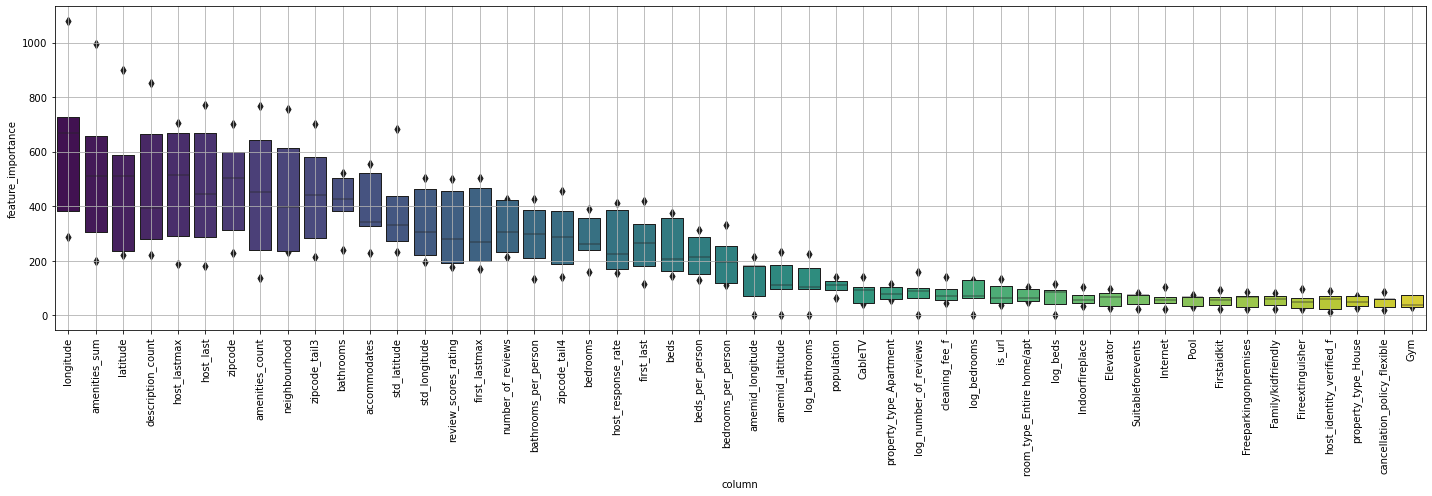

In [46]:
fig, ax = visualize_importance(models, x)

# submit

In [47]:
preprocessed_test.head()

accommodates  bathrooms  bedrooms  beds  host_response_rate   latitude  \
55583             6        2.0       2.0   2.0                 100  42.359278   
55584             3        1.0       1.0   1.0                 100  34.084747   
55585             2        1.0       0.0   1.0                 100  40.720541   
55586             4        1.0       1.0   2.0                   0  40.681117   
55587             3        1.5       1.0   2.0                 100  34.150995   

        longitude  neighbourhood  number_of_reviews  review_scores_rating  \
55583  -71.069962             42                 58                  90.0   
55584 -118.367355            582                  4                 100.0   
55585  -73.959192            605                  0                   NaN   
55586  -73.944091             44                  0                   NaN   
55587 -118.409359            619                  6                  92.0   

       zipcode  population  cost_dollar     pop_cost  amenities_count  \
55583        7      617594         3211   192.336967              293   
55584      478     3792621         2899  1308.251466              352   
55585      262     8175133         3956  2066.514914              113   
55586      221     8175133         3956  2066.514914              232   
55587      671     3792621         2899  1308.251466              209   

       Wideentryway  Fireplaceguards  Elevatorinbuilding  Handorpapertowel  \
55583             0                0                   0                 0   
55584             0                0                   0                 0   
55585             0                0                   0                 0   
55586             0                0                   0                 0   
55587             0                0                   0                 0   

       Hotwater  Luggagedropoffallowed  Otherpet(s)  Patioorbalcony  \
55583         0                      0            0               0   
55584         0                      0            0               0   
55585         0                      0            0               0   
55586         0                      0            0               0   
55587         0                      0            0               0   

       Essentials  Shampoo  Grab-railsforshowerandtoilet  \
55583       64004    49464                             0   
55584       64004    49464                             0   
55585       64004        0                             0   
55586       64004    49464                             0   
55587           0        0                             0   

       Widehallwayclearance  Doorman  Singlelevelhome  Freeparkingonstreet  \
55583                     0        0                0                    0   
55584                     0        0                0                    0   
55585                     0        0                0                    0   
55586                     0        0                0                    0   
55587                     0        0                0                    0   

       Bathtubwithshowerchair  Lockonbedroomdoor  \
55583                       0              17982   
55584                       0                  0   
55585                       0                  0   
55586                       0                  0   
55587                       0                  0   

       Wideclearancetoshower&toilet  Dog(s)  Outletcovers  \
55583                             0       0             0   
55584                             0       0             0   
55585                             0       0             0   
55586                             0       0             0   
55587                             0       0             0   

       Accessible-heightbed  Cleaningbeforecheckout  Changingtable  \
55583                     0                       0              0   
55584                     0                       0              0   
55

In [48]:
y_pred = np.array([model.predict(preprocessed_test.values) for model in models])
y_pred = np.mean(y_pred, axis=0)
y_pred = np.where(y_pred < 0, 0, y_pred)

In [49]:
y_pred

array([235.3468253 , 137.89089913, 113.48786201, ..., 192.29038662,
       126.26043888,  42.74767406])

In [50]:
test_submit_df = pd.read_csv('../input/test.csv')
test_submit_df.head()

id  accommodates                                          amenities  \
0   0             6  {TV,"Cable TV","Wireless Internet","Air condit...   
1   1             3  {TV,"Cable TV",Internet,"Wireless Internet","A...   
2   2             2  {TV,"Wireless Internet","Air conditioning",Kit...   
3   3             4  {TV,"Cable TV",Internet,"Wireless Internet","A...   
4   4             3  {TV,Internet,"Wireless Internet","Air conditio...   

   bathrooms  bed_type  bedrooms  beds cancellation_policy    city  \
0        2.0  Real Bed       2.0   2.0              strict  Boston   
1        1.0  Real Bed       1.0   1.0            moderate      LA   
2        1.0  Real Bed       0.0   1.0            flexible     NYC   
3        1.0  Real Bed       1.0   2.0              strict     NYC   
4        1.5  Real Bed       1.0   2.0              strict      LA   

  cleaning_fee                                        description  \
0            t  Feel free to book INSTANTLY. You can check-in ...   
1            t  The guest house is close to: Equinox West Holl...   
2            f  Private room in a three bedroom apartment in N...   
3            f  The apartment is located in historic Bed Stuy ...   
4            t  Our cozy, pet friendly one bedroom apartment/l...   

  first_review host_has_profile_pic host_identity_verified host_response_rate  \
0   2017-01-09                    t                      f               100%   
1   2016-08-17                    t                      t               100%   
2          NaN                    t                      t               100%   
3          NaN                    t                      t                NaN   
4   2015-08-01                    t                      t               100%   

   host_since instant_bookable last_review   latitude   longitude  \
0  2016-08-23                t  2017-09-25  42.359278  -71.069962   
1  2014-09-03                f  2017-05-02  34.084747 -118.367355   
2  2012-10-17                f         NaN  40.720541  -73.959192   
3  2013-01-23                f         NaN  40.681117  -73.944091   
4  2014-12-28                f  2016-09-11  34.150995 -118.409359   

                                                name       neighbourhood  \
0             Gorgeous 2BR/2BA Duplex in Beacon Hill         Beacon Hill   
1        Luxury 1 Bedroom West Hollywood City Center      West Hollywood   
2  Bedroom with Patio in Prime Williamsburg Locat...        Williamsburg   
3                         Cozy apartment in Brooklyn  Bedford-Stuyvesant   
4                 Cozy, sunny, pet friendly loft/apt                 NaN   

   number_of_reviews property_type  review_scores_rating        room_type  \
0                 58         House                  90.0  Entire home/apt   
1                  4    Guesthouse                 100.0  Entire home/apt   
2                  0     Apartment                   NaN     Private room   
3                  0     Apartment                   NaN  Entire home/apt   
4                  6          Loft                  92.0  Entire home/apt   

                                       thumbnail_url  zipcode  
0  https://a0.muscache.com/im/pictures/7e4808b4-5...    02114  
1  https://a0.muscache.com/im/pictures/5392fbd6-6...    90046  
2  https://a0.muscache.com/im/pictures/544d3b89-d...  11249.0  
3  https://a0.muscache.com/im/pictures/26baf7ba-0...    11216  
4  https://a0.muscache.com/im/pictures/86107545/9...    91604

In [51]:
result = pd.DataFrame()
result['id'] = test_submit_df['id']
result['y'] = y_pred

In [52]:
result['y'] = result['y'].apply(lambda x:0 if x < 0 else x)

In [53]:
result.head()

id           y
0   0  235.346825
1   1  137.890899
2   2  113.487862
3   3  141.985441
4   4  129.585069

In [54]:
result.to_csv('../output/sample_submit.csv', index = False, header = False)